# **Introduction to this Notebook**

The purpose of this notebook is to show the final analysis outputs and results without walking through every intermediate step. It is mainly intended for readers who already understand the subprocesses or have gone through **`hww_tools`** and are familiar with the recipe behind the workflow.

If you would like to see the complete analysis step by step in a single place, please refer to **`notebooks/HWW_analysis.ipynb`**. (*Recommended*)

> **Note to future me:** Add a hyperlink to the full notebook here.

**Quick tip:** Make sure the **`hww_tools`** folder and this **`Run_analysis.ipynb`** notebook are saved in the **exact same directory**. If they aren't, you'll run into import errors and have to manually update the file paths in the code before it'll run!

In [2]:
# A time stamp to see the last update time 
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')
print(f"Last Updated: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")

Last Updated: 22 February 2026, 21:03 IST


# **Imports** 

We will begin by importing all the necessary modules and libraries required to run this notebook.  

Note that the Python files inside `hww_tools` already include their own required imports, so there is no need to import them again here.

In [4]:
import time  # For tracking execution time and calculating processing rates
import gc    # Garbage collector , essential for manually freeing memory during large batch processing
import pandas as pd  # Data manipulation library, used for constructing, formatting, and saving cutflow DataFrames
from IPython.display import display  
from tqdm.auto import tqdm  # Provides a smart progress bar that automatically adapts to Jupyter or terminal environments

from dask.distributed import Client, LocalCluster, progress, as_completed  # Dask components for parallel computing

%matplotlib inline  

from hww_tools import * # Imports all custom configurations, processor functions, and helpers from your local hww_tools module

print(" \n All imports loaded")

hww_tools loaded successfully.
- Config
- Efficiency_data
- Physics_selection
- Plots_config
- calculations
- cross_section
- cutflow_utils
- cuts
- helper
- json_validation
- dask_utils
- plotting
- processor
 
 All imports loaded


# Setting up **Dask** client

Once all the imports are loaded, we will initialize the Dask client.  

You can monitor the computation in detail through the Dask dashboard using the provided dashboard link.

In [3]:
client = get_client("tls://localhost:8786")
display(client)

<Client: 'tls://192.168.235.20:8786' processes=1 threads=1, memory=2.89 GiB>

## Preparing Dask workers with all the modules

This next part can be a bit tricky.

Since the Dask workers are running in their own separate environments on the cluster, they don't have direct access to the local files saved in our `hww_tools` directory. To solve this, we'll **zip up** the `hww_tools` folder and upload it directly to the workers so they can use our custom functions in the analysis.

Once the upload finishes, a quick verification script runs to test if the workers can successfully import the ```hww_tools``` module. If everything works as expected, it'll print a success message and we're good to go!


> **Note:** **Did you edit `hww_tools`?**
>
>If you make any changes to the files inside your custom tools, **you need to force Dask to refresh its memory**. Otherwise, the workers may continue using an older cached version of your code.
>
>To ensure the latest version is uploaded to the workers:
>
> 1. **Delete** the old `hww_tools.zip` file.  
> 2. Close the Dask client.  
> 3. **Restart** your Jupyter kernel (no need to restart the entire server).  
> 4. Rerun the notebook from the top.

In [4]:
prepare_workers(client)

Zipping hww_tools from /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Run_analysis...
Uploading hww_tools.zip to cluster...
Upload complete. Workers can now import hww_tools.
Verifying import on workers...
  tls://129.93.182.103:33055: SUCCESS: Imported hww_tools from /var/lib/condor/execute/dir_1439747/dask-scratch-space/worker-63yxk4ef/hww_tools.zip/hww_tools/__init__.py


# Loading Files

After that, we'll load the datasets and files we want to process. 

There's also a commented-out line you can use to run a quick test on a small subset of files, just to make sure everything is working properly!

In [5]:
# files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=1)  # TESTING
files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

samples_to_process(files)


FILES TO PROCESS
Data                :   48 files
VG                  :   32 files
ggH_HWW             :   40 files
WW                  :    7 files
Fakes               :  206 files
Diboson             :   73 files
DY_to_Tau_Tau       :   61 files
ggWW                :  112 files
Top_antitop         :  197 files
______________________________________________________________________
TOTAL               :  776 files


# **Run Analysis**

Now, this is the core part of the analysis. It reads the **`processor.py`** script from `hww_tools` and submits it to the Dask workers. The processor applies the actual physics cuts and builds the histograms. To read more about the exact steps involved in the analysis, please refer to the **`HWW_Analysis_Walkthrough.md`**.

Once the workers are done processing, the script will automatically save the histogram results in a ROOT file and dump the cutflow yields into CSV files in the Outputs directory.

In [6]:
print("\n" + "="*70)
print("PROCESSING START!! ")
print(f"Output Directory: {Config.OUTPUT_DIR}")
print("="*70)

project_path = os.getcwd()

# Load Configuration
stage_names = Config.stage_names
cutflow_stages = Config.cutflow_stages
VARIATIONS = Config.VARIATIONS
variables_to_plots = Plots_config.variables_to_plots

# Load Golden JSON
golden_json_data = None
if Config.GOLDEN_JSON_PATH.exists():
    with open(Config.GOLDEN_JSON_PATH, 'r') as f:
        golden_json_data = json.load(f)
    # print(f"Loaded Golden JSON: {len(golden_json_data)} runs")

# 2. PREPARE PROCESSOR
processing_task = processor.make_processor(
    golden_json_data=golden_json_data,
    sample_info_detailed=cross_section.sample_info_detailed, 
    luminosity=cross_section.LUMINOSITY,                        
    run_periods=Config.RUN_PERIODS_2016,
    project_dir=project_path 
)

# 3. PREPARE ACCUMULATORS
print("Initializing storage...")
hist_data_final = {}
cutflow_final = {}
weighted_cutflow_final = {}

for label in files.keys():
    # Use helper to initialize structure
    hist_data_final[label] = helper.initialize_stage_histograms(stage_names, variables_to_plots, VARIATIONS)
    cutflow_final[label] = {stage: 0 for stage in cutflow_stages}
    weighted_cutflow_final[label] = {stage: 0.0 for stage in cutflow_stages}

# 4. SUBMIT TO CLUSTER
arg_labels = []
arg_urls = []
arg_indices = []

for label, urls in files.items():
    for file_idx, file_url in enumerate(urls):
        arg_labels.append(label)
        arg_urls.append(file_url)
        arg_indices.append(file_idx)

print(f"\nSubmitting {len(arg_urls)} files to the cluster...")
start_time = time.perf_counter()

futures = client.map(
    processing_task, 
    arg_labels, arg_urls, arg_indices,
    retries=1  
)

# 5. STREAMING MERGE LOOP
print("Processing and merging results as they arrive...")
error_count = 0

# Progress bar
for future in tqdm(as_completed(futures), total=len(futures), unit="file"):
    try:
        result = future.result()
        if not result: continue
        
        label, stage_histograms, cutflow, weighted_cutflow, error = result
        
        if error:
            error_count += 1
            print(f" ERROR: {error}")
            continue

        # A. Merge Cutflows
        if cutflow:
            for stage, count in cutflow.items():
                cutflow_final[label][stage] += count
        
        if weighted_cutflow:
            for stage, count in weighted_cutflow.items():
                weighted_cutflow_final[label][stage] += count
        
        # B. Merge Histograms
        if stage_histograms:
            for stage, vars_dict in stage_histograms.items():
                for var, syst_dict in vars_dict.items():
                    for syst, hist_obj in syst_dict.items():
                        # In-place addition
                        hist_data_final[label][stage][var][syst] += hist_obj
        
        # clear memory
        del result, stage_histograms, cutflow, weighted_cutflow

    except Exception as e:
        print(f"CRITICAL CLIENT ERROR: {e}")
        error_count += 1

elapsed = time.perf_counter() - start_time

# 6. SAVE RESULTS 
helper.save_root_file(hist_data_final, Config.OUTPUT_DIR / "HWW_analysis_output.root")

cutflow_utils.save_cutflows(cutflow_final, weighted_cutflow_final, Config.OUTPUT_DIR)

# 7. FINAL REPORT
print("\n" + "="*70)
print(f"{'SAMPLE':20s} | {'EVENTS':>12s}")
print("-" * 35)
total_events = 0
for label in sorted(files.keys()):
    events = cutflow_final[label].get('total', 0)
    total_events += events
    print(f"{label:20s} | {events:>12,}")
print("-" * 35)
print(f"{'TOTAL':20s} | {total_events:>12,}")
print("="*70)

if error_count > 0:
    print(f"\n WARNING: {error_count} files failed processing.")

print(f"\nTotal Time: {elapsed:.1f}s ({elapsed/60:.1f} min)")
if len(futures) > 0:
    print(f"Rate: {total_events/elapsed:,.0f} events/sec")

# Cleanup
del futures, arg_urls, arg_labels, arg_indices
gc.collect()


PROCESSING START!! 
Output Directory: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs
Initializing storage...

Submitting 776 files to the cluster...
Processing and merging results as they arrive...


  0%|          | 0/776 [00:00<?, ?file/s]


Saving histograms to ROOT file: HWW_analysis_output.root...
  Success! ROOT file saved.
Saved Raw Cutflow to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Cutflow_Raw.csv
Saved Weighted Cutflow to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Cutflow_scaled.csv

SAMPLE               |       EVENTS
-----------------------------------
DY_to_Tau_Tau        |   82,448,537
Data                 |   63,091,128
Diboson              |   15,551,954
Fakes                |  226,680,227
Top_antitop          |  137,367,000
VG                   |   34,915,878
WW                   |    2,900,000
ggH_HWW              |    2,946,000
ggWW                 |   17,662,000
-----------------------------------
TOTAL                |  583,562,724

Total Time: 528.6s (8.8 min)
Rate: 1,104,031 events/sec


73

# **Outputs**

## Cutflow

In [7]:
df = pd.read_csv(Config.OUTPUT_DIR / "Cutflow_scaled.csv", index_col=0)
rows_to_highlight = [df.index[0], df.index[-1]]
styled_df = df.style.format("{:,.2f}") \
    .background_gradient(cmap="Blues", axis=0) \
    .set_properties(
        subset=pd.IndexSlice[rows_to_highlight, :], 
        **{'font-weight': 'bold'}
    )

display(styled_df)

## Plots

Once the processing is done, it is generally not a good idea to rely solely on the results provided by the main processing loop—which in our case is `hist_data_final`. If the server unexpectedly crashes or we disconnect from it, we could lose all our progress. 

Therefore, we will use the `HWW_analysis_output.root` file that we created during the processing stage to load the dictionary containing all our information.

In [8]:
hist_data_final = helper.restore_histograms(
    sample_list=sorted(files.keys()),       
    stage_names=Config.stage_names,
    vars_dict=Plots_config.variables_to_plots,
    variations=Config.VARIATIONS,
    root_file_path=Config.OUTPUT_DIR / "HWW_analysis_output.root"
)

Restoring histograms from: HWW_analysis_output.root
Successfully restored data for 9 samples.


### Superimposed plots

Here are the superimposed plots! We use these to compare the shapes of different processes—both our signal and the backgrounds—across various stages of the analysis.

The main goal here is to see exactly how these processes behave as we apply our cuts. It helps us spot the regions where the signal really stands out, which visually validates the selection criteria we chose for this analysis.

(Keep an eye out for the **`red`**—that's our HIGGS signal!)

Saving superimposed plots to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Kinematics
Processing mass...
Saved plot: mass_stages.png


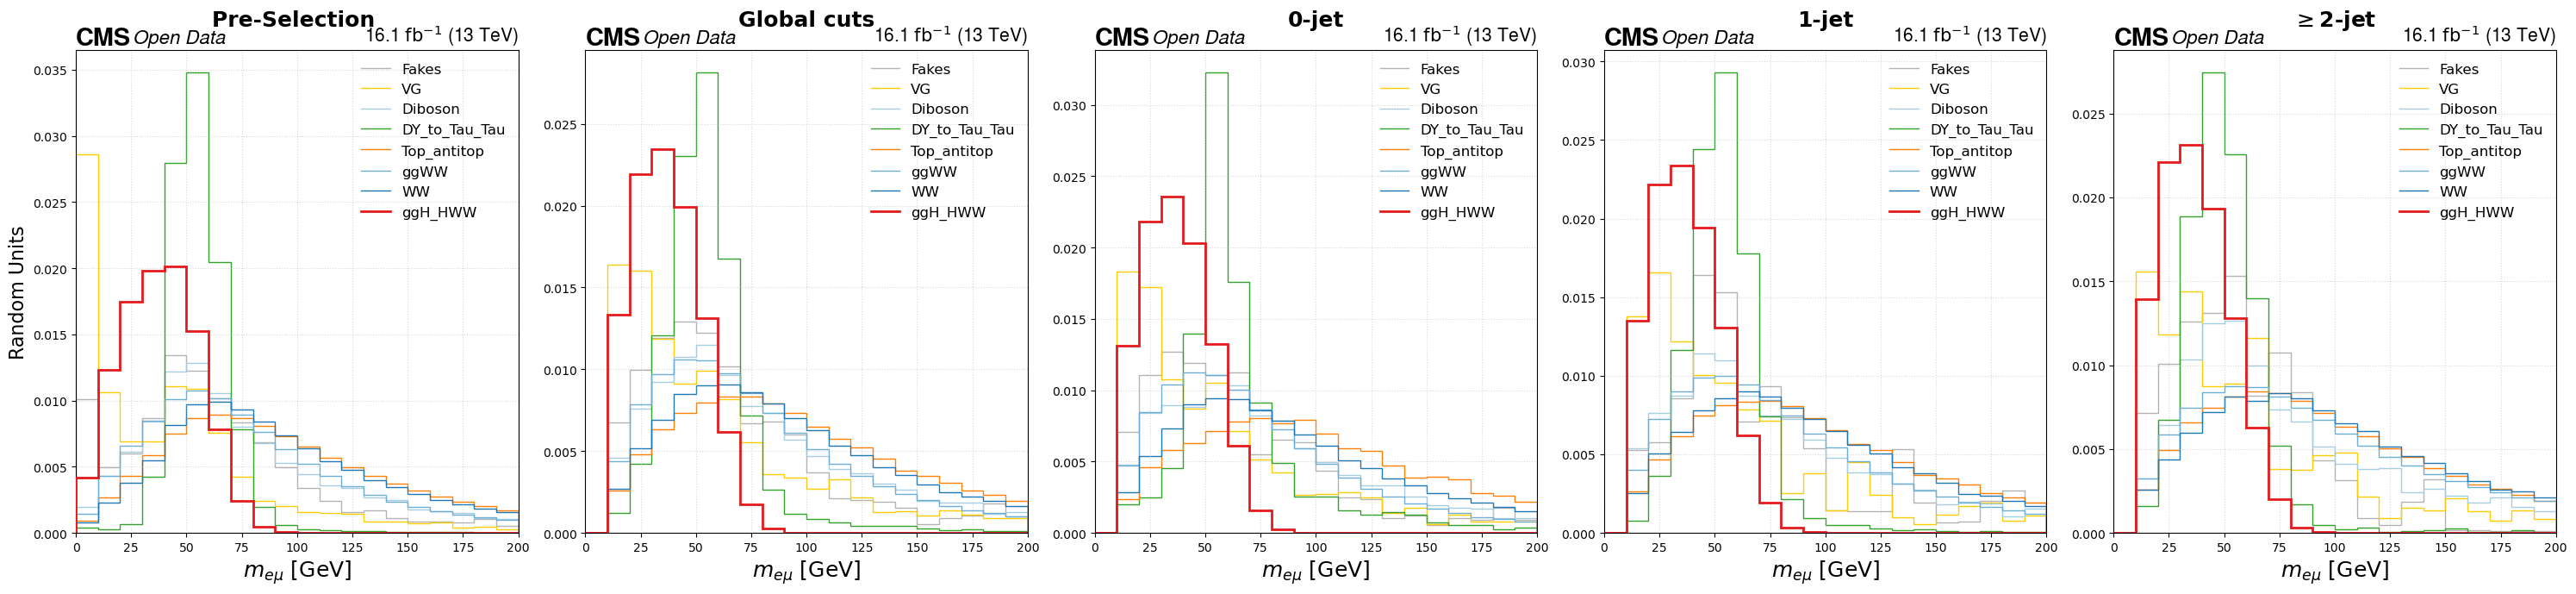

Processing met...
Saved plot: met_stages.png


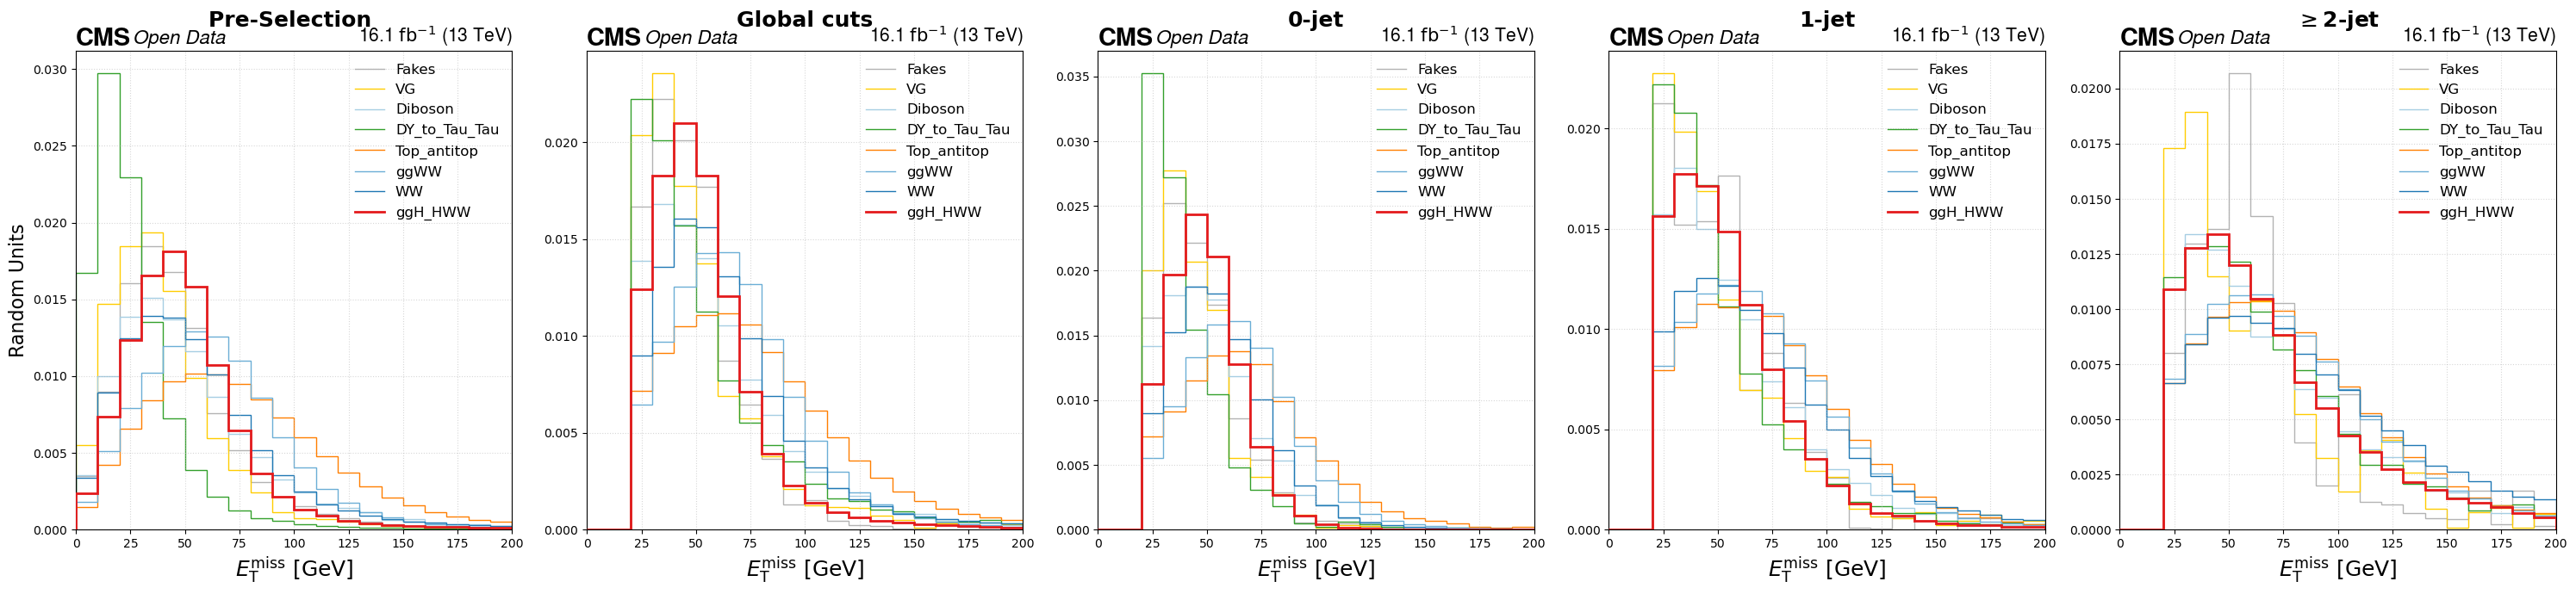

Processing dphi...
Saved plot: dphi_stages.png


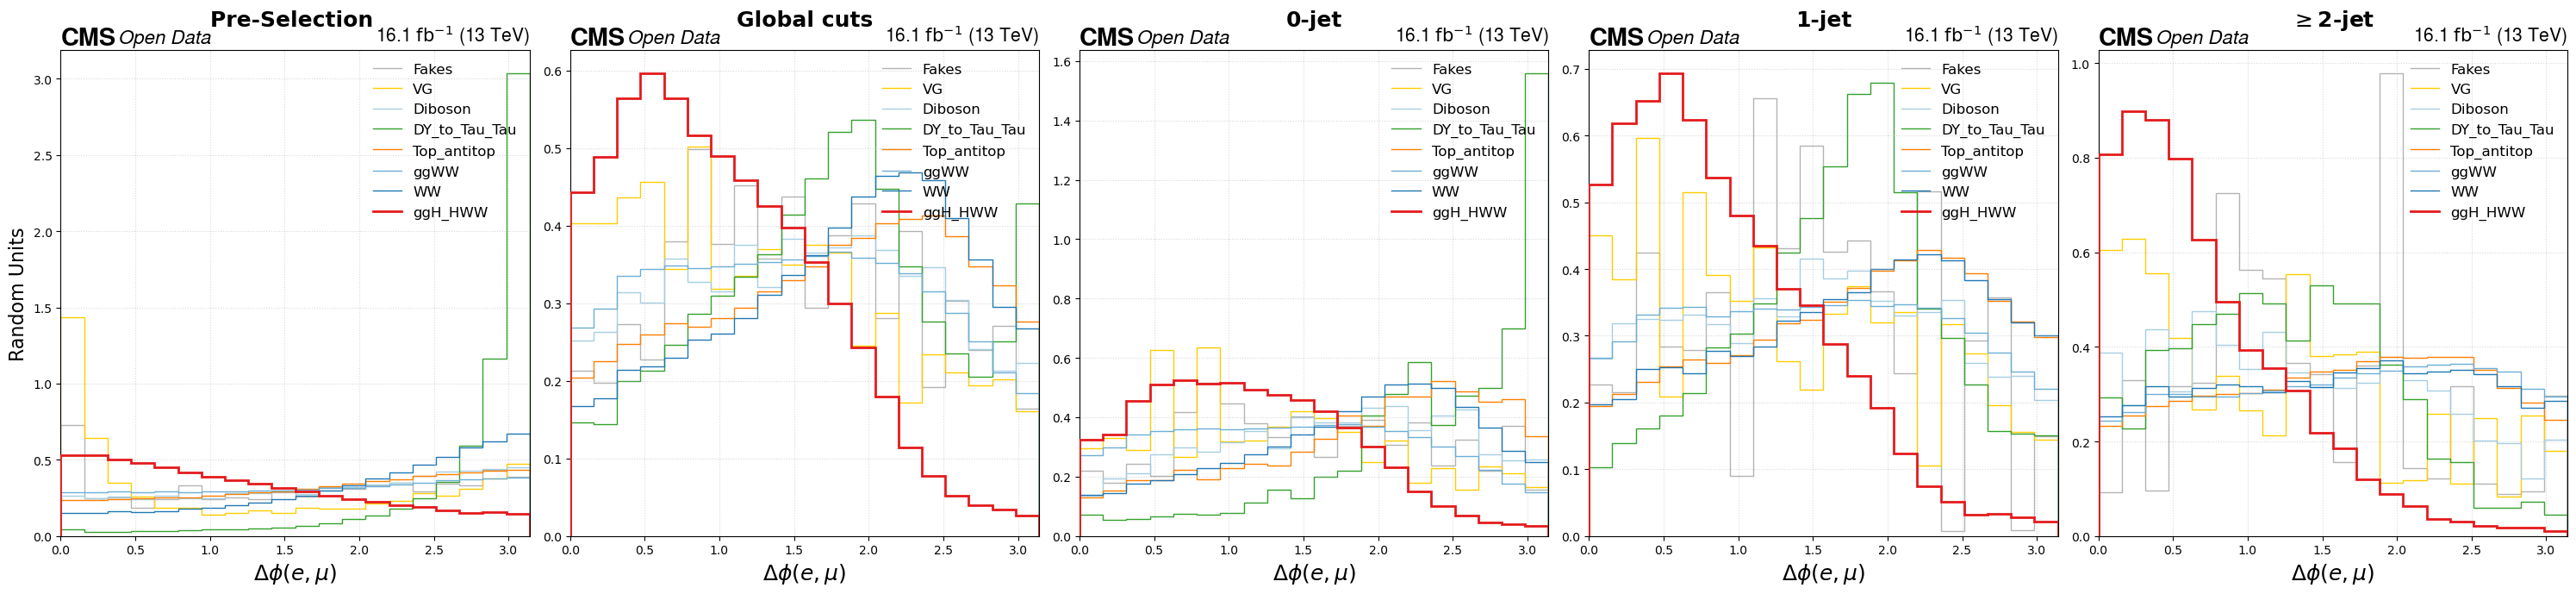

Processing ptll...
Saved plot: ptll_stages.png


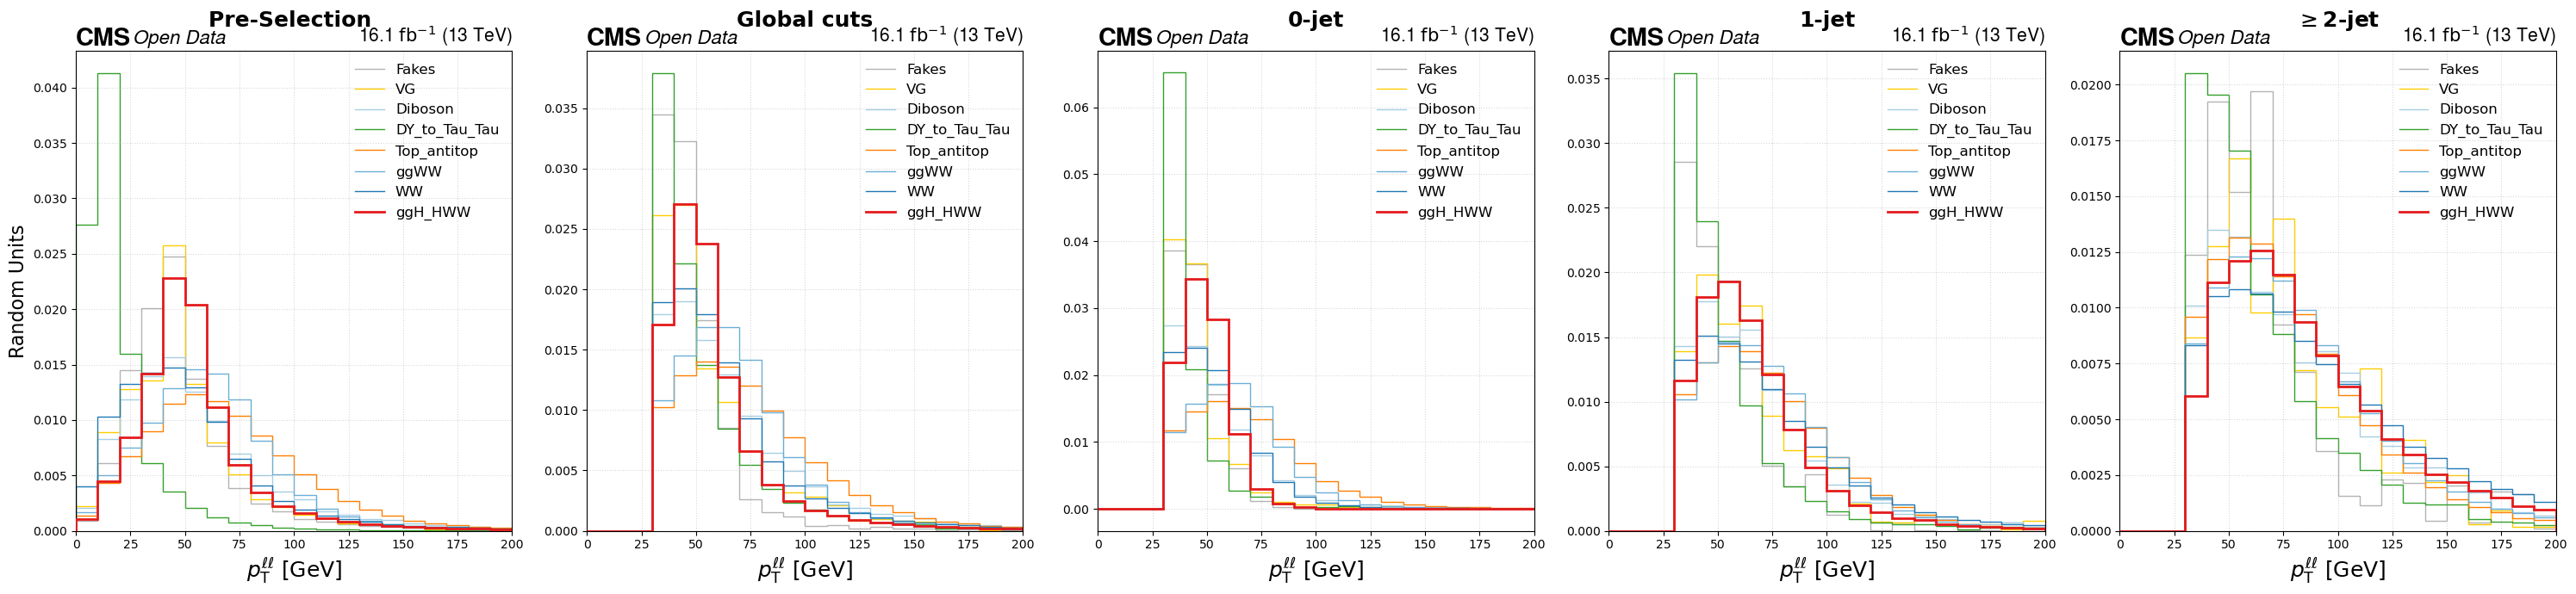

Processing mt_higgs...
Saved plot: mt_higgs_stages.png


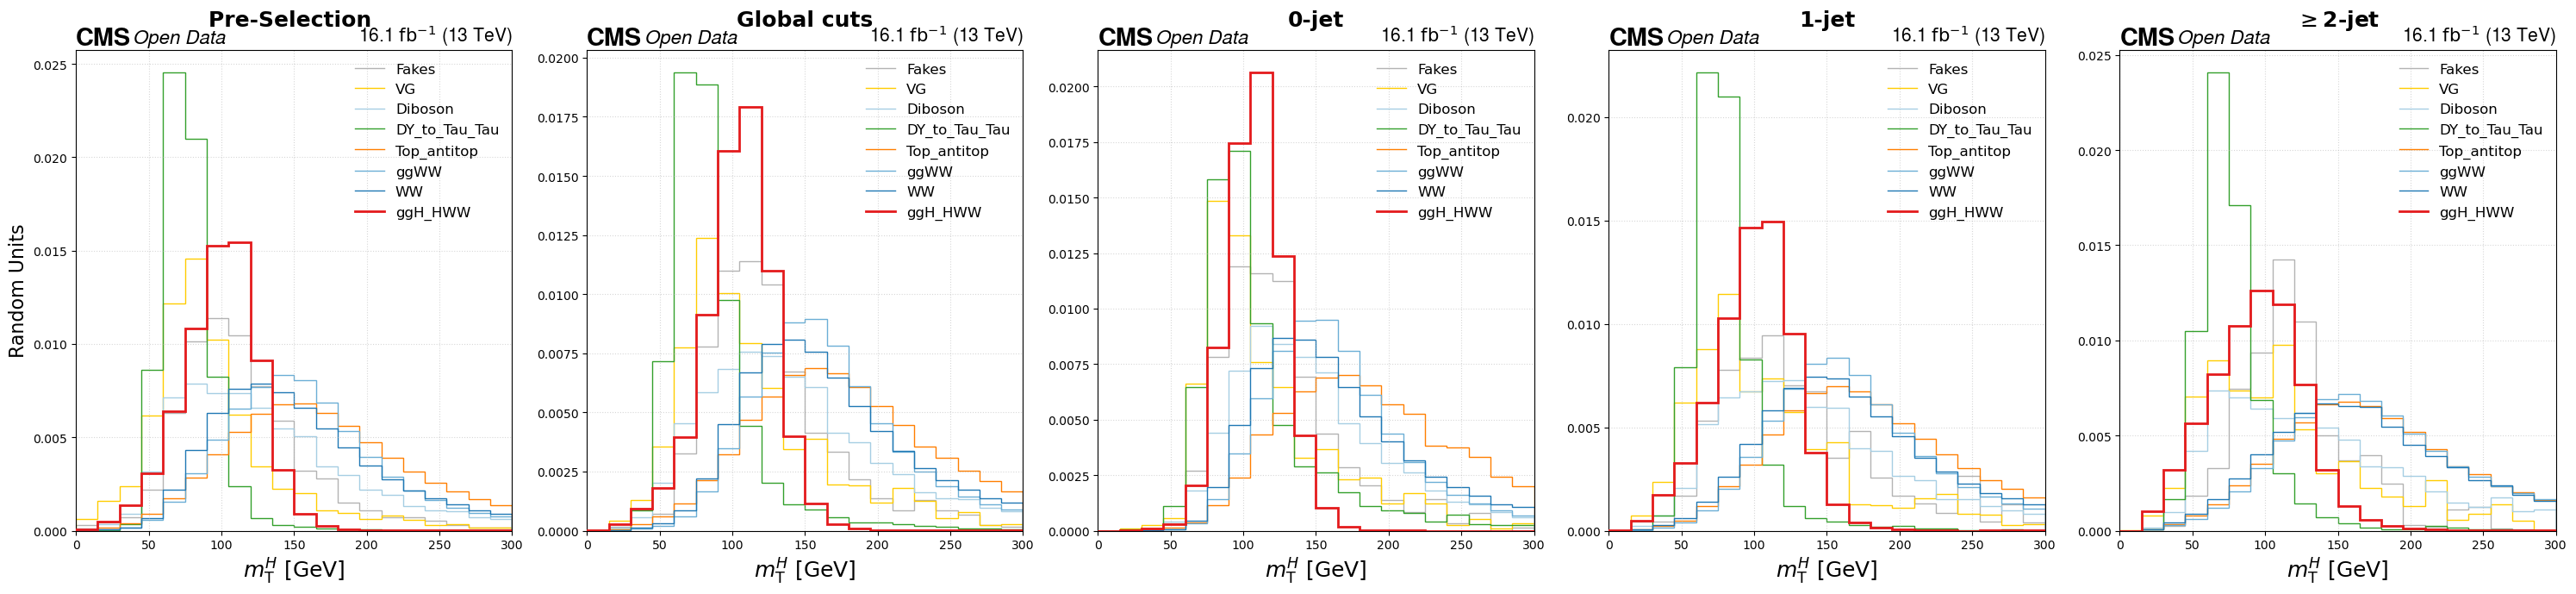

Processing mt_l2_met...
Saved plot: mt_l2_met_stages.png


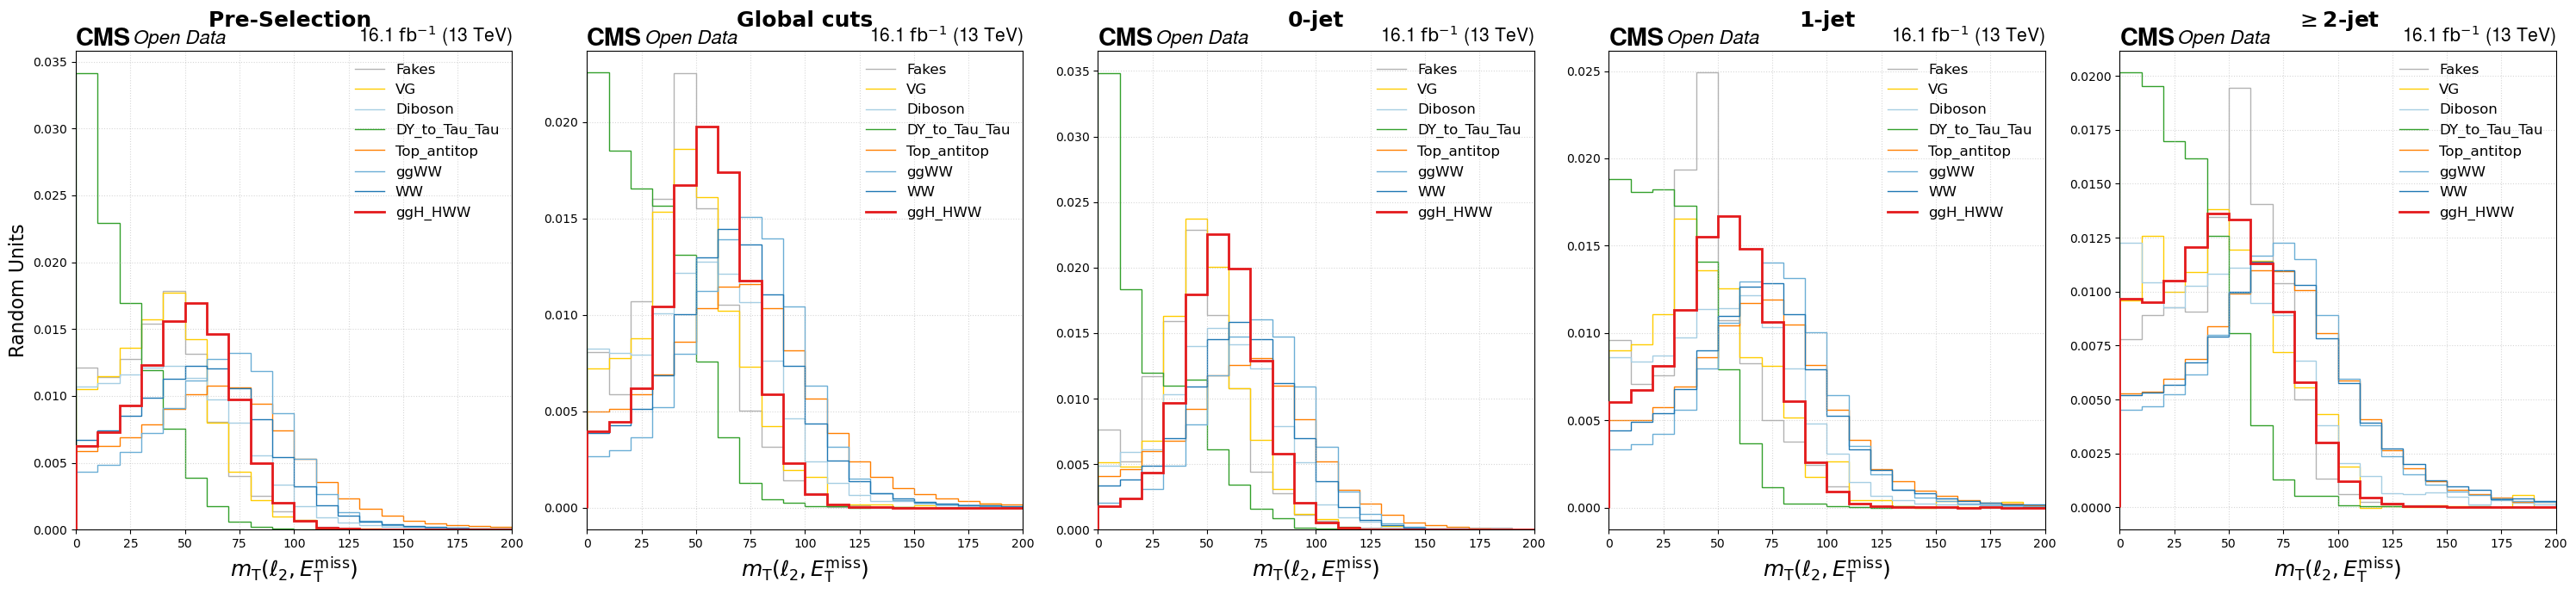

Processing mjj...
Saved plot: mjj_stages.png


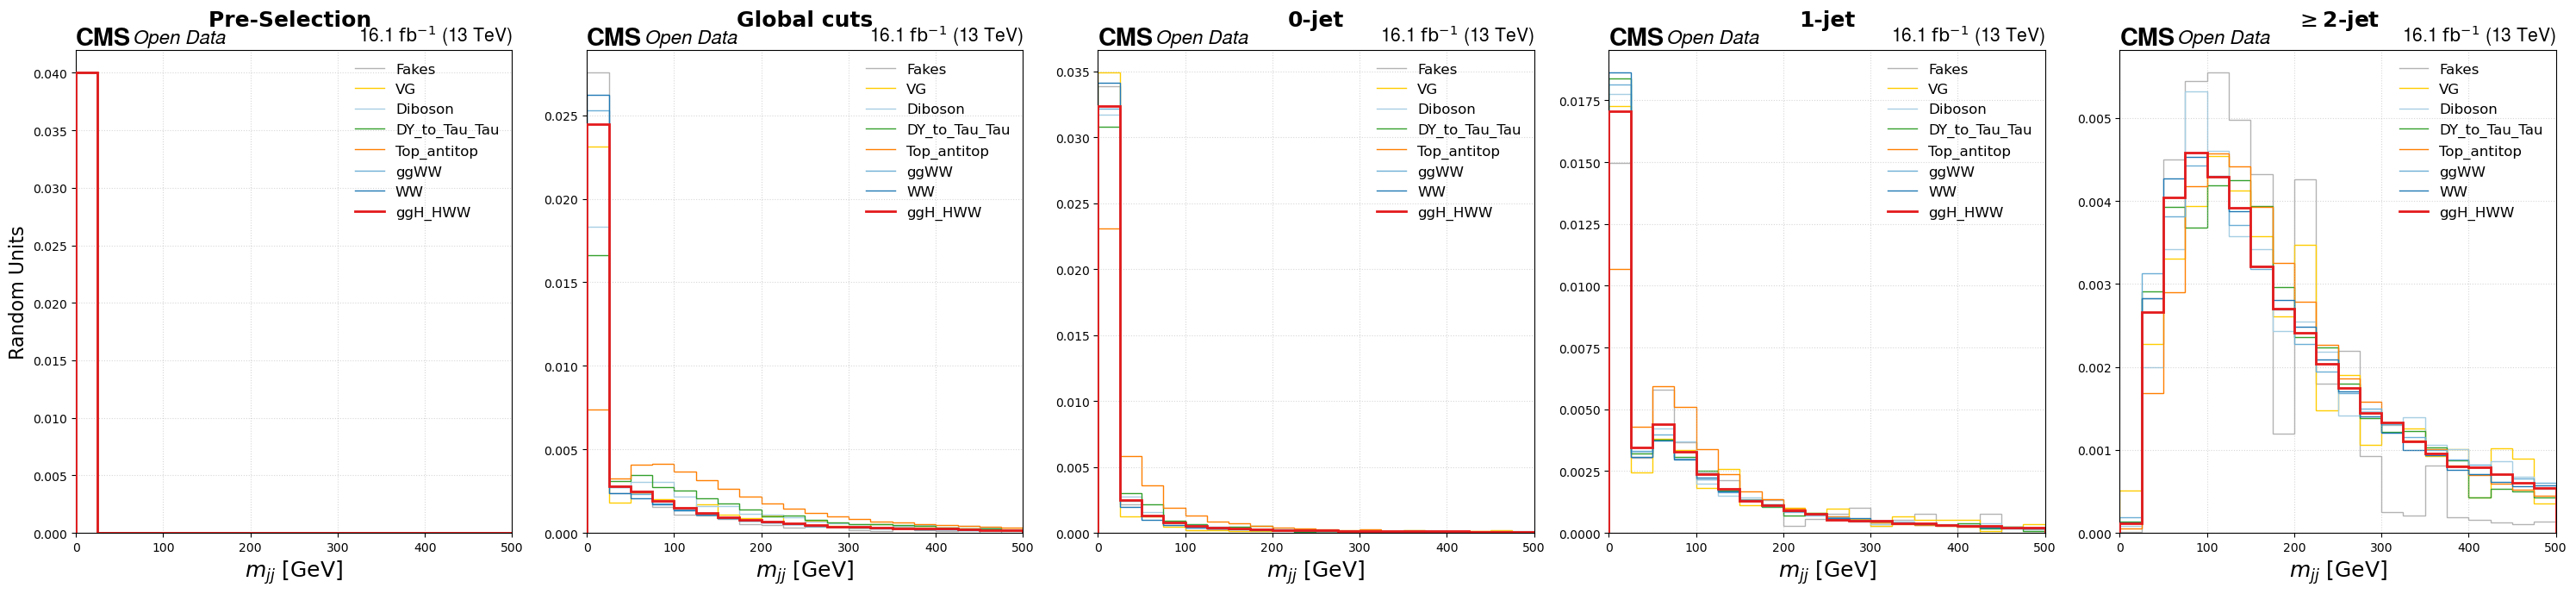

Processing leading_pt...
Saved plot: leading_pt_stages.png


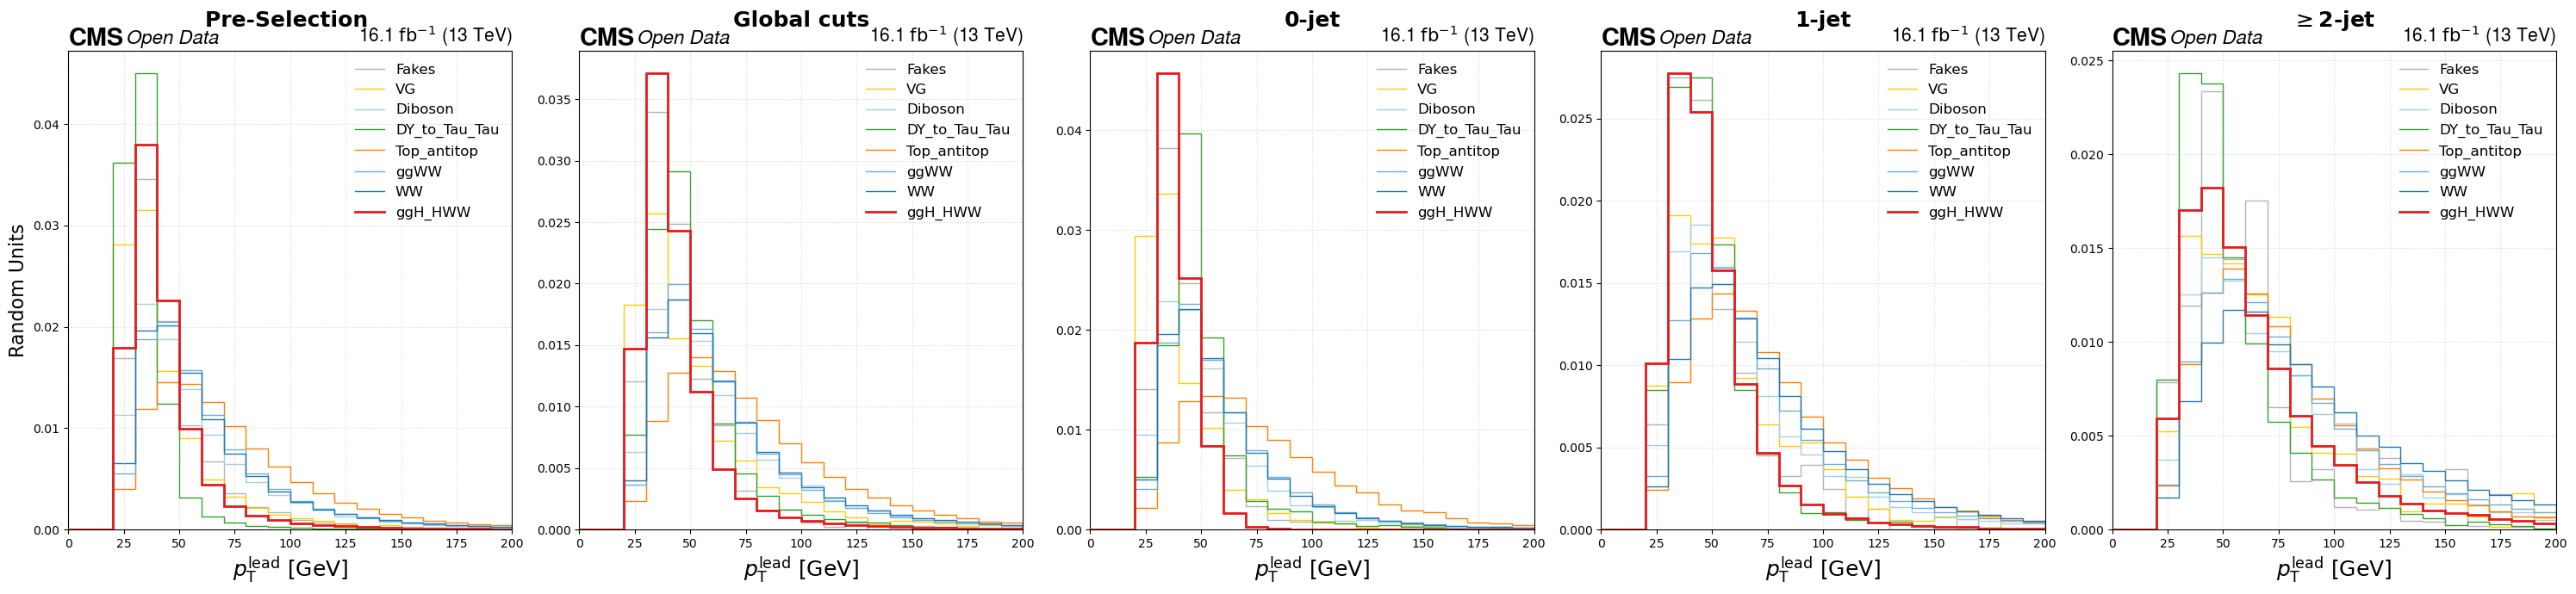

Processing subleading_pt...
Saved plot: subleading_pt_stages.png


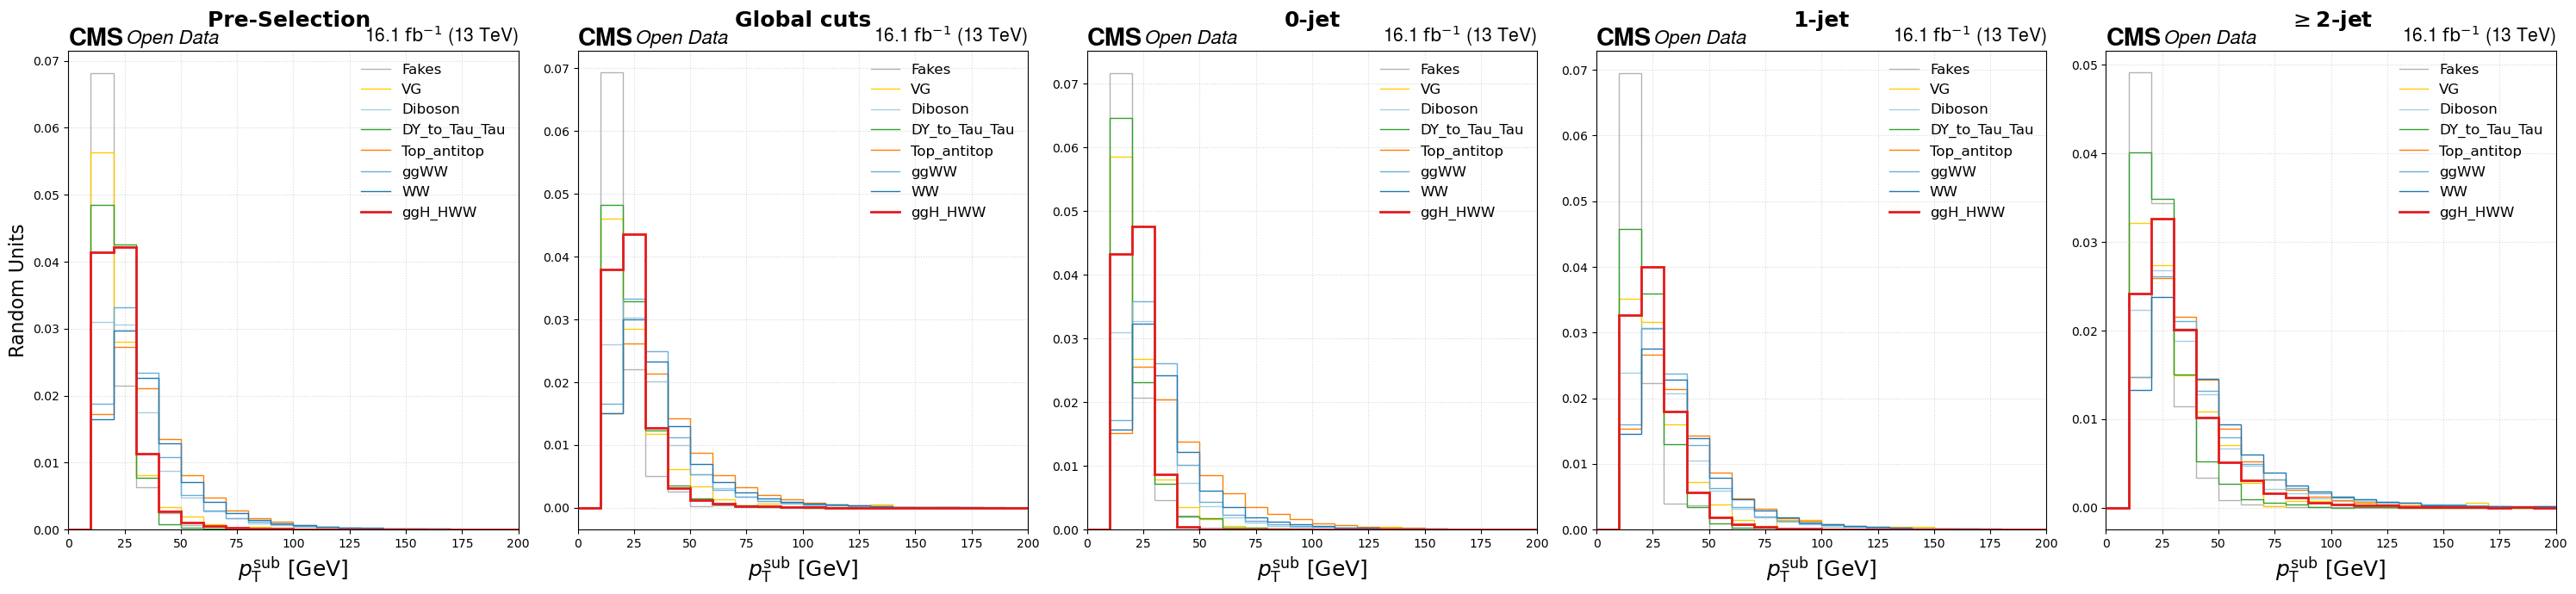

In [9]:
kinematics_dir = PLOTS_DIR / "Kinematics"
kinematics_dir.mkdir(parents=True, exist_ok=True)
print(f"Saving superimposed plots to: {kinematics_dir}")

for var_name, var_props in variables_to_plots.items():
    print(f"Processing {var_name}...")
    fig = create_superimposed_plots(var_name, var_props, hist_data_final, output_dir=PLOTS_DIR / "Kinematics")
    
    plt.show()
    plt.close(fig)

### Stacked plots

Now let's check out the stacked plots!

We use these to look at the overall event yields by stacking all our background processes on top of each other.

**A quick heads-up:** in the signal region, we've magnified the Higgs signal by 10x. The actual Standard Model Higgs production is incredibly small compared to massive backgrounds like Top quarks or WW. Scaling it up just allows us to actually see its kinematic shape and where it stands.

As you'll see, the Higgs signal really peaks in our 0-jet Signal Region (since vetoing jets helps suppress that huge Top background). On the flip side, we also look at the Top quark Control Region. This region is intentionally designed to be flooded with Top events so we can check if our Monte Carlo (MC) simulation accurately models reality. If the MC matches well in the control region, it gives us confidence that our background estimates are solid when we look at the signal region.


GENERATING STACKED PLOTS...
Plotting mass in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mass.png


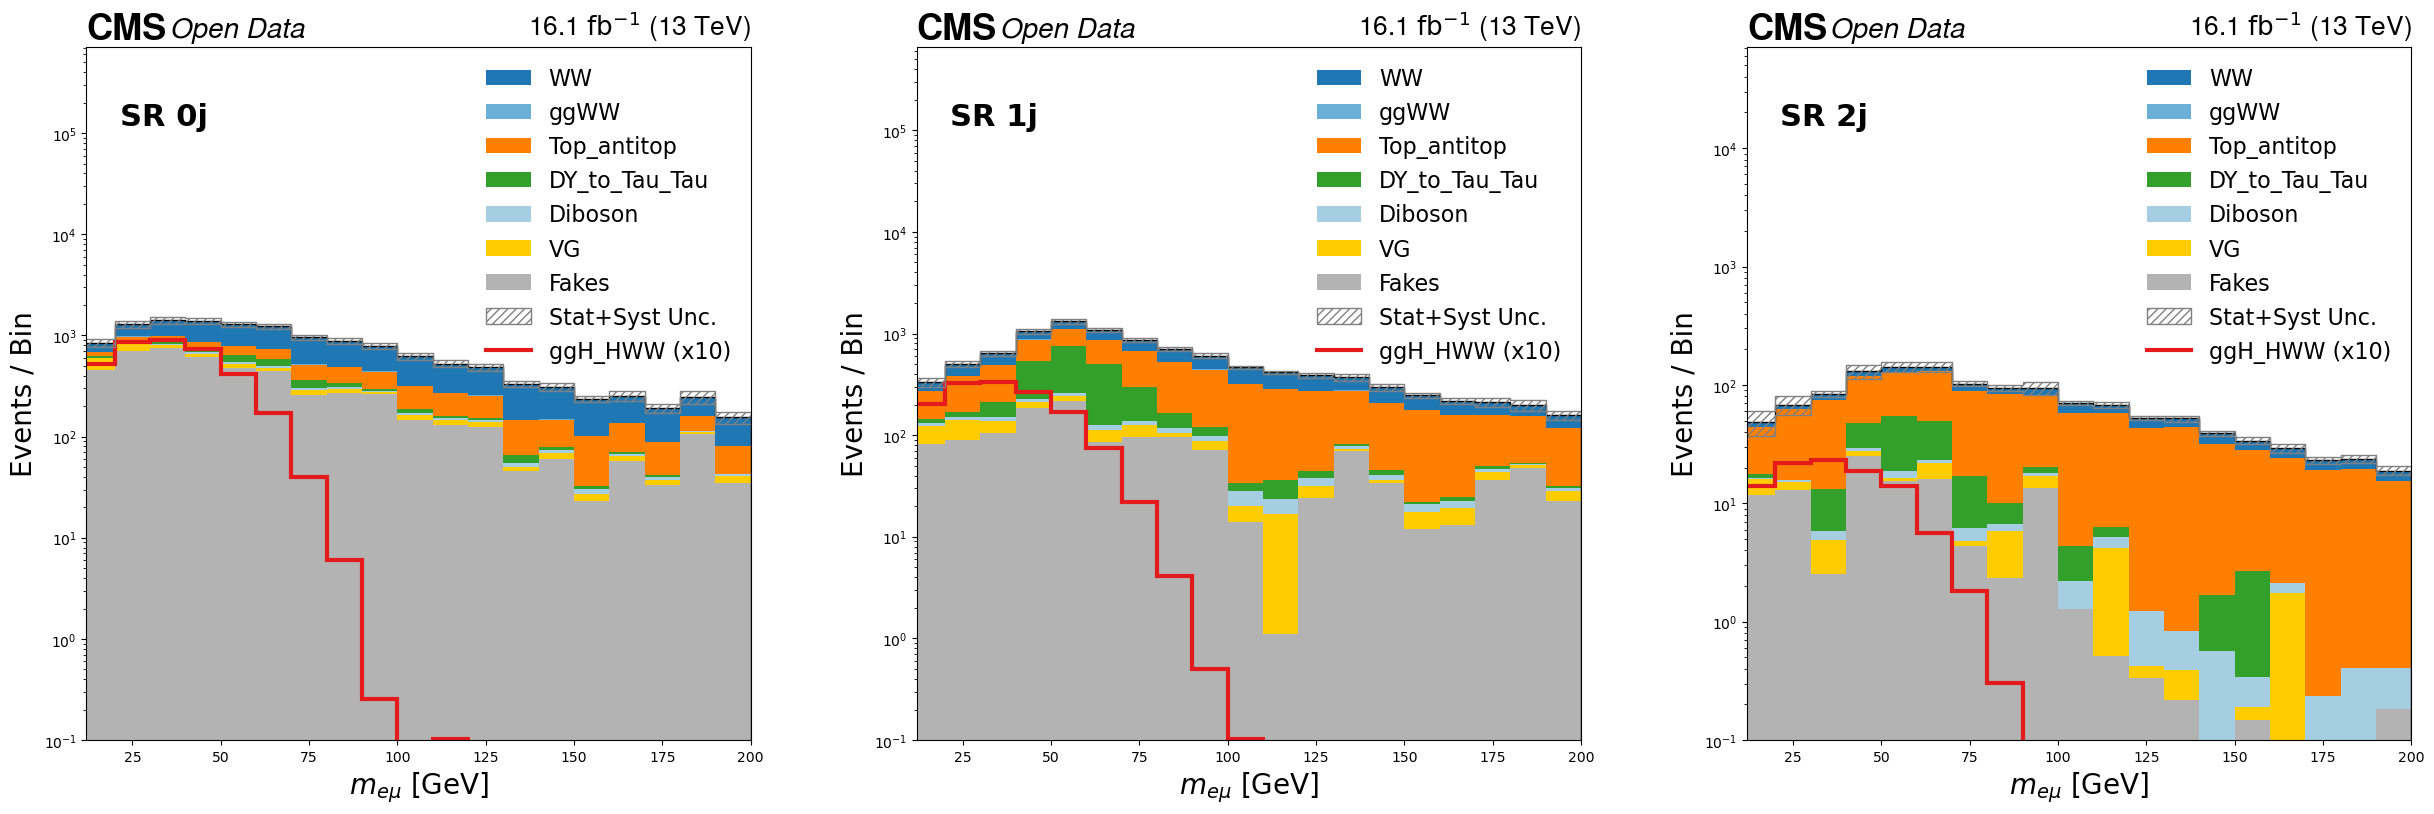

Plotting mass in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mass.png


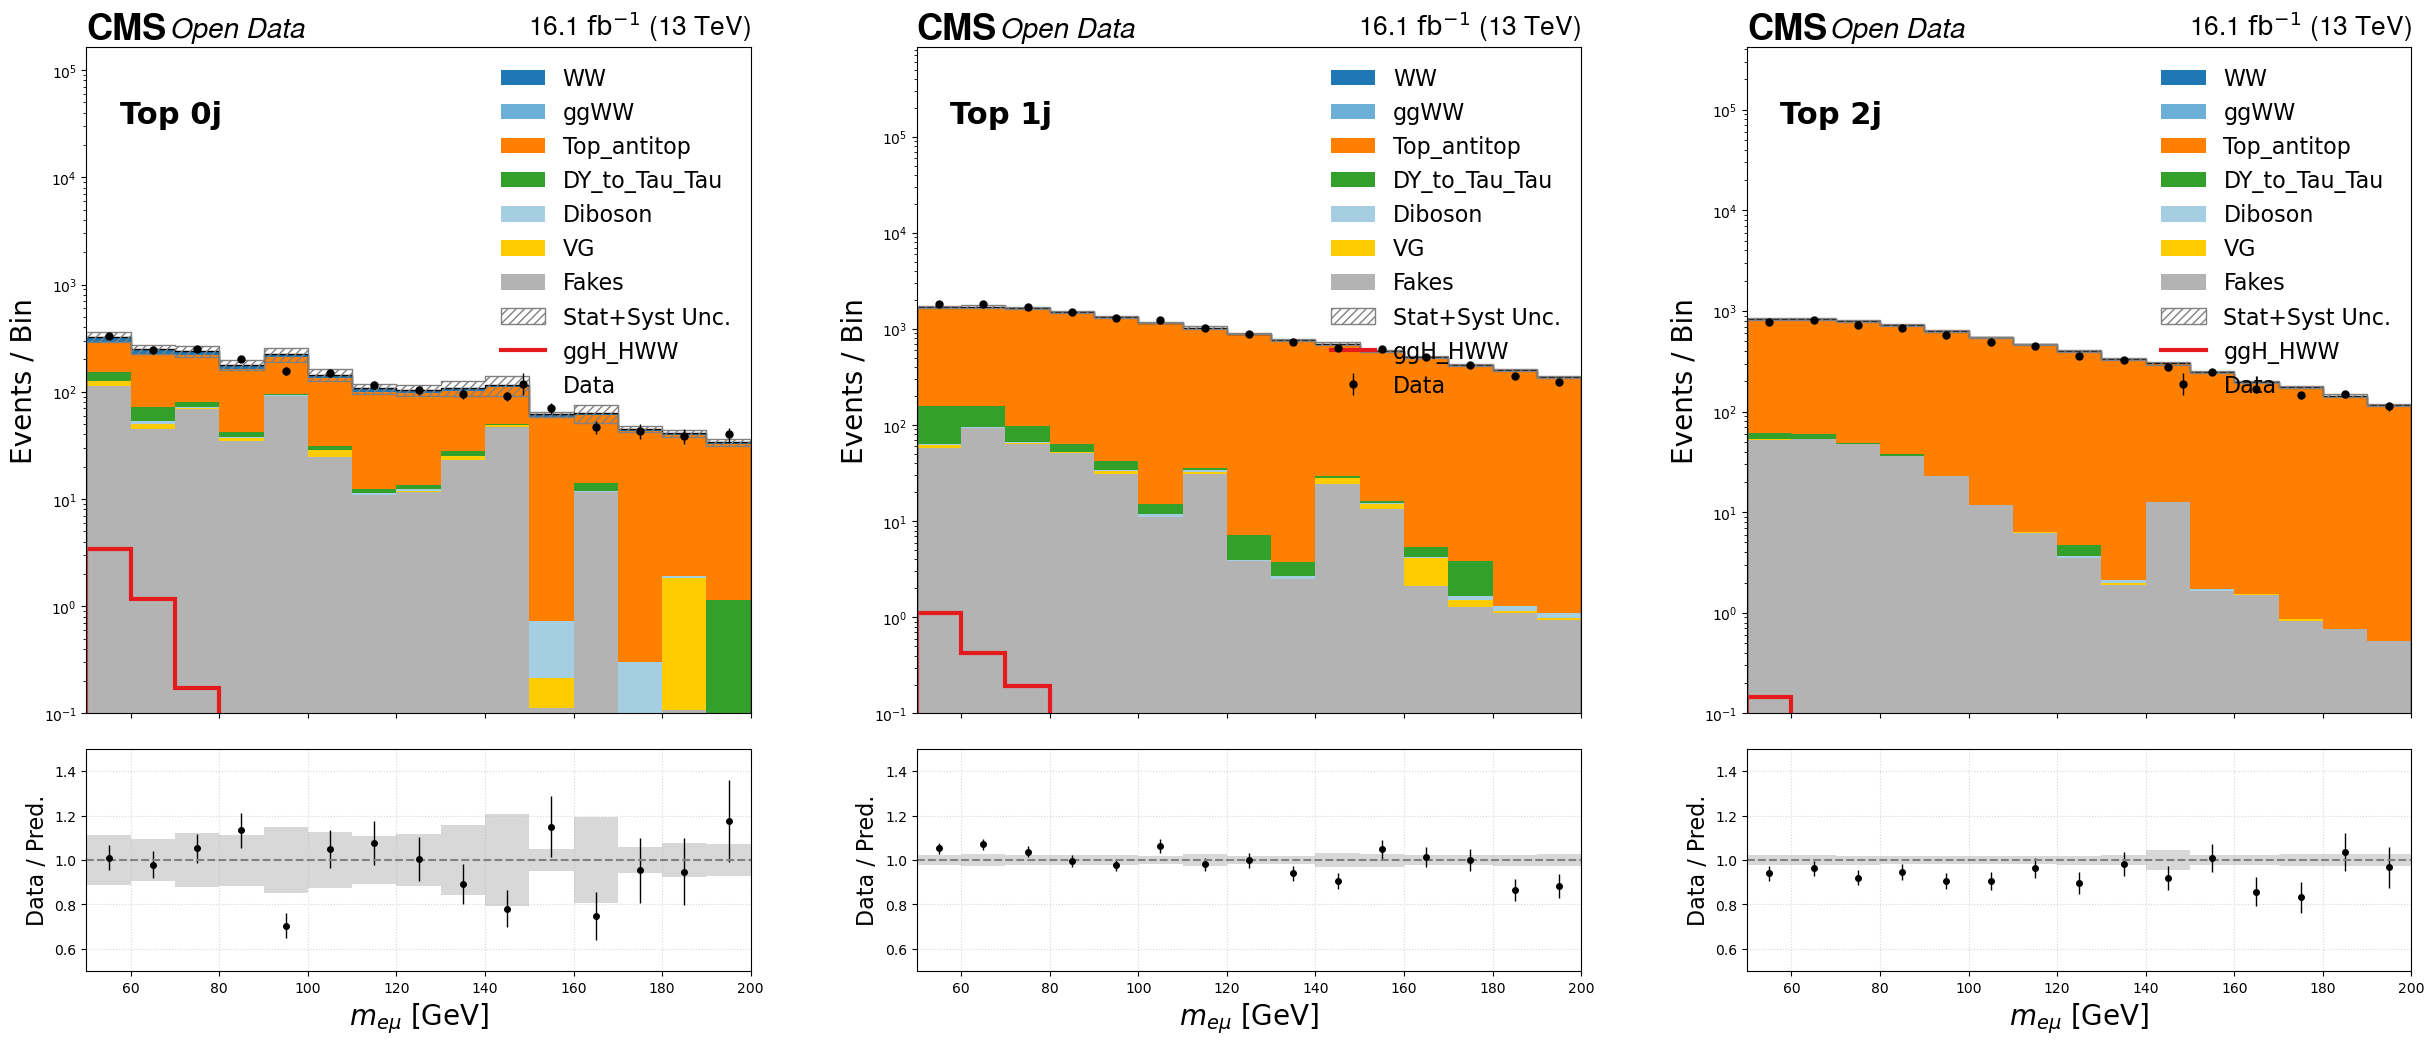

Plotting mass in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mass.png


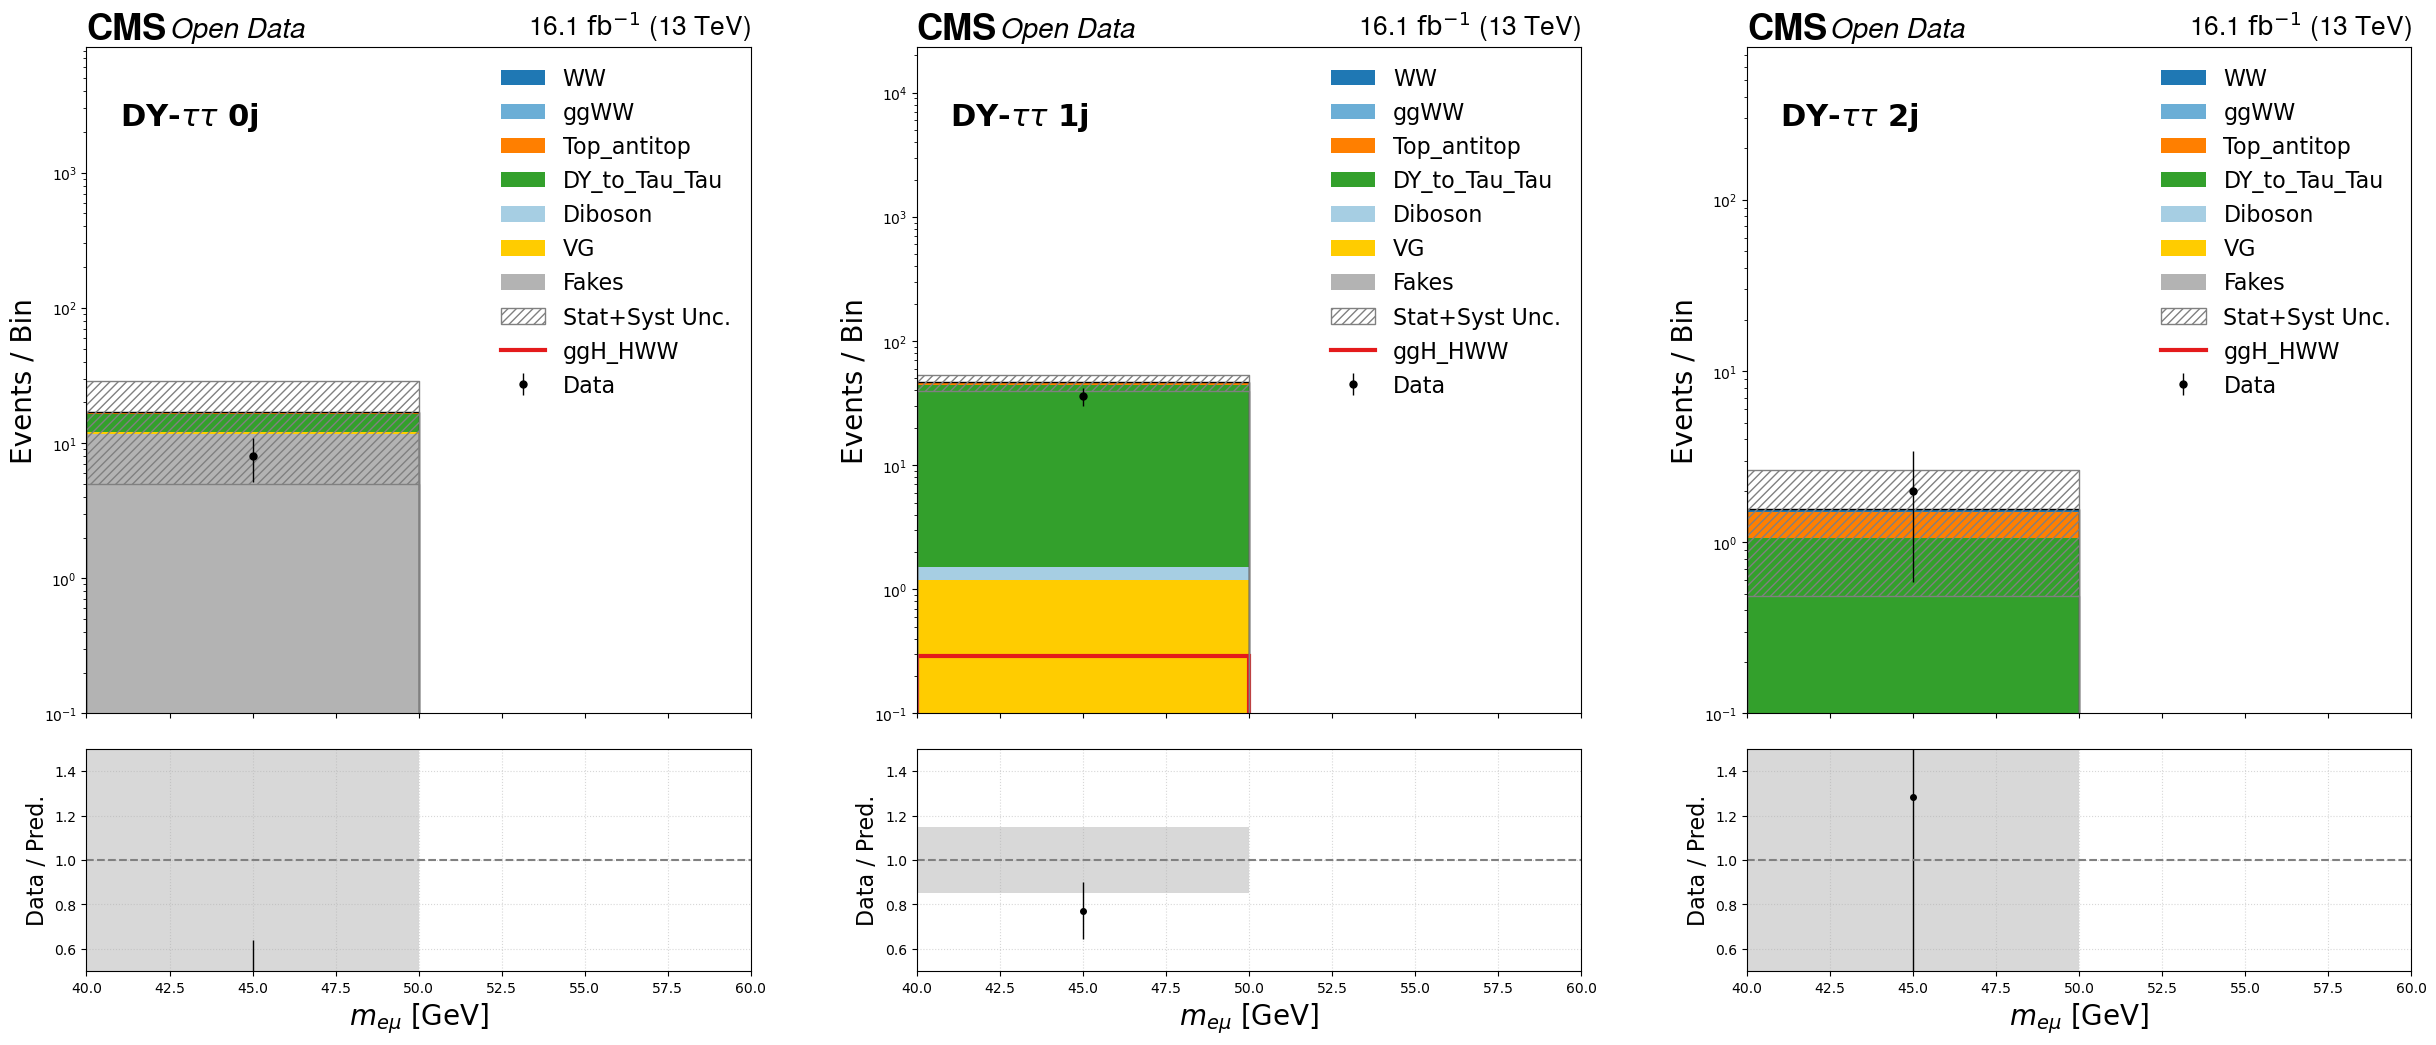

Plotting met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_met.png


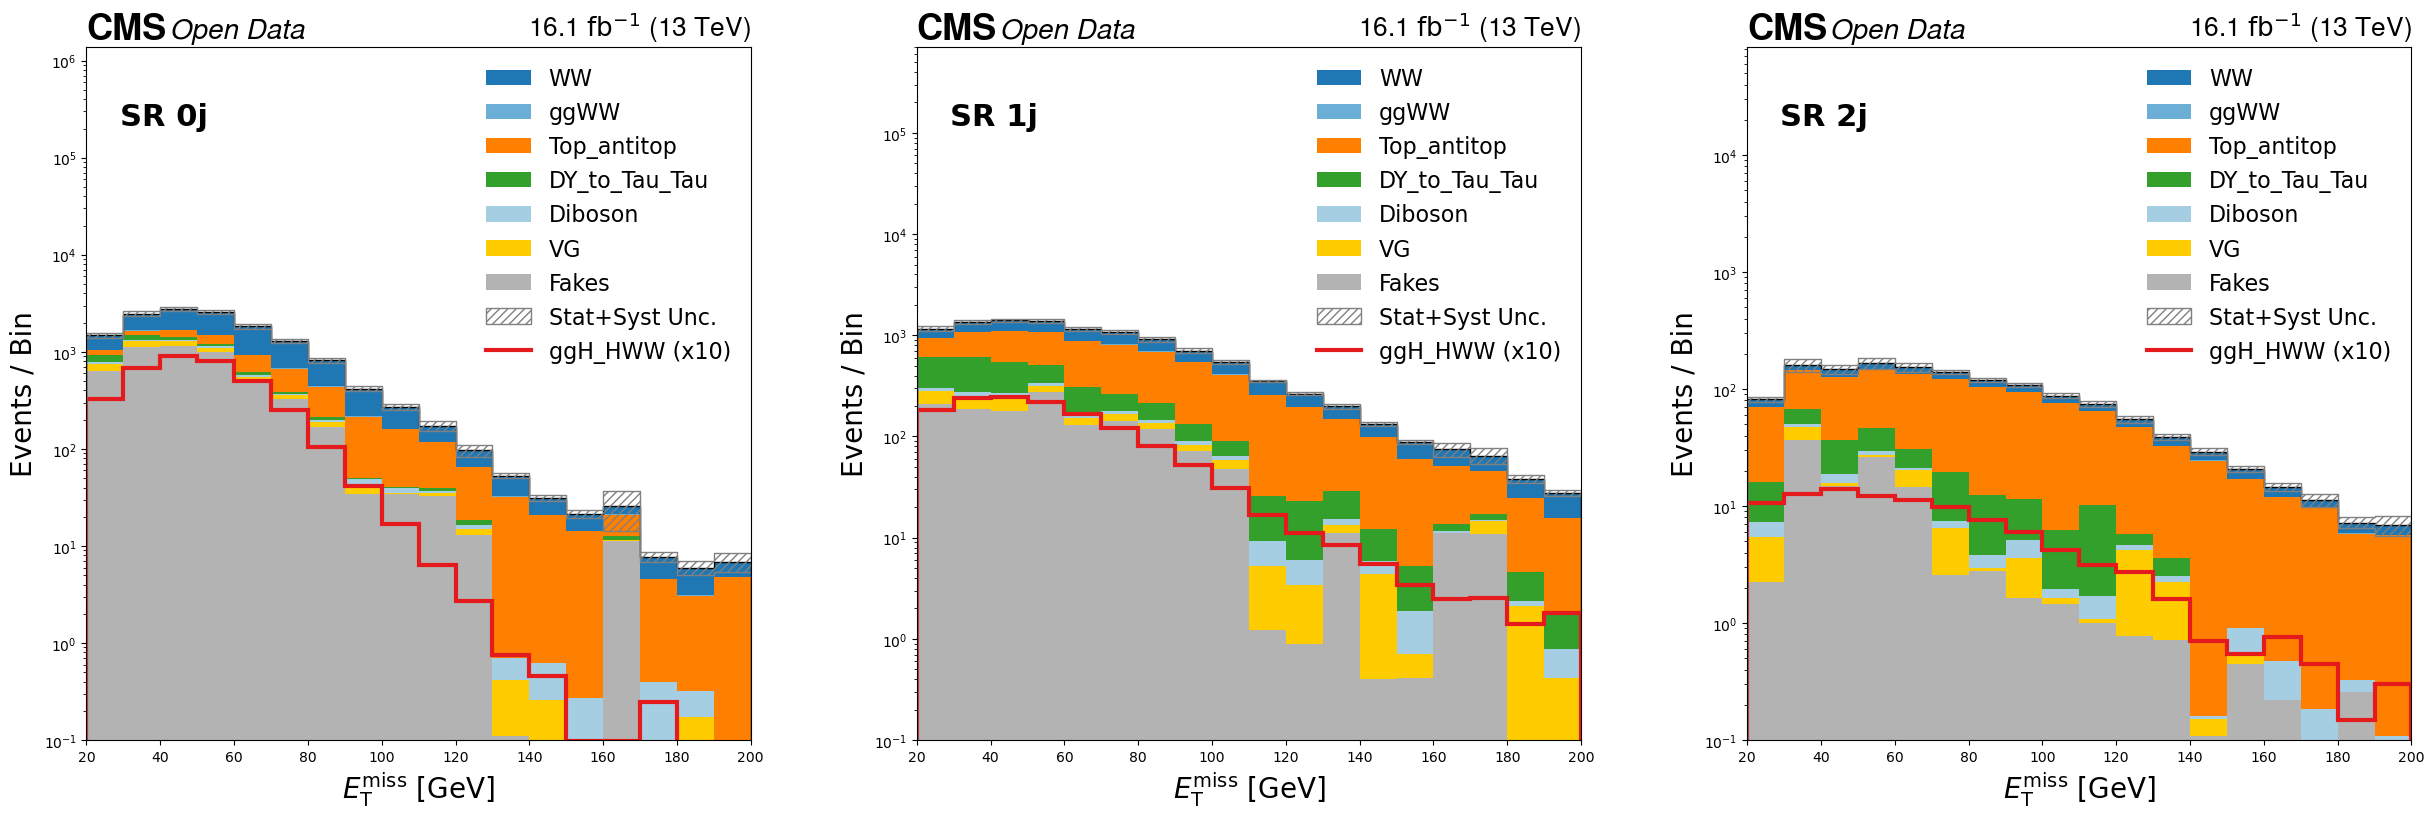

Plotting met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_met.png


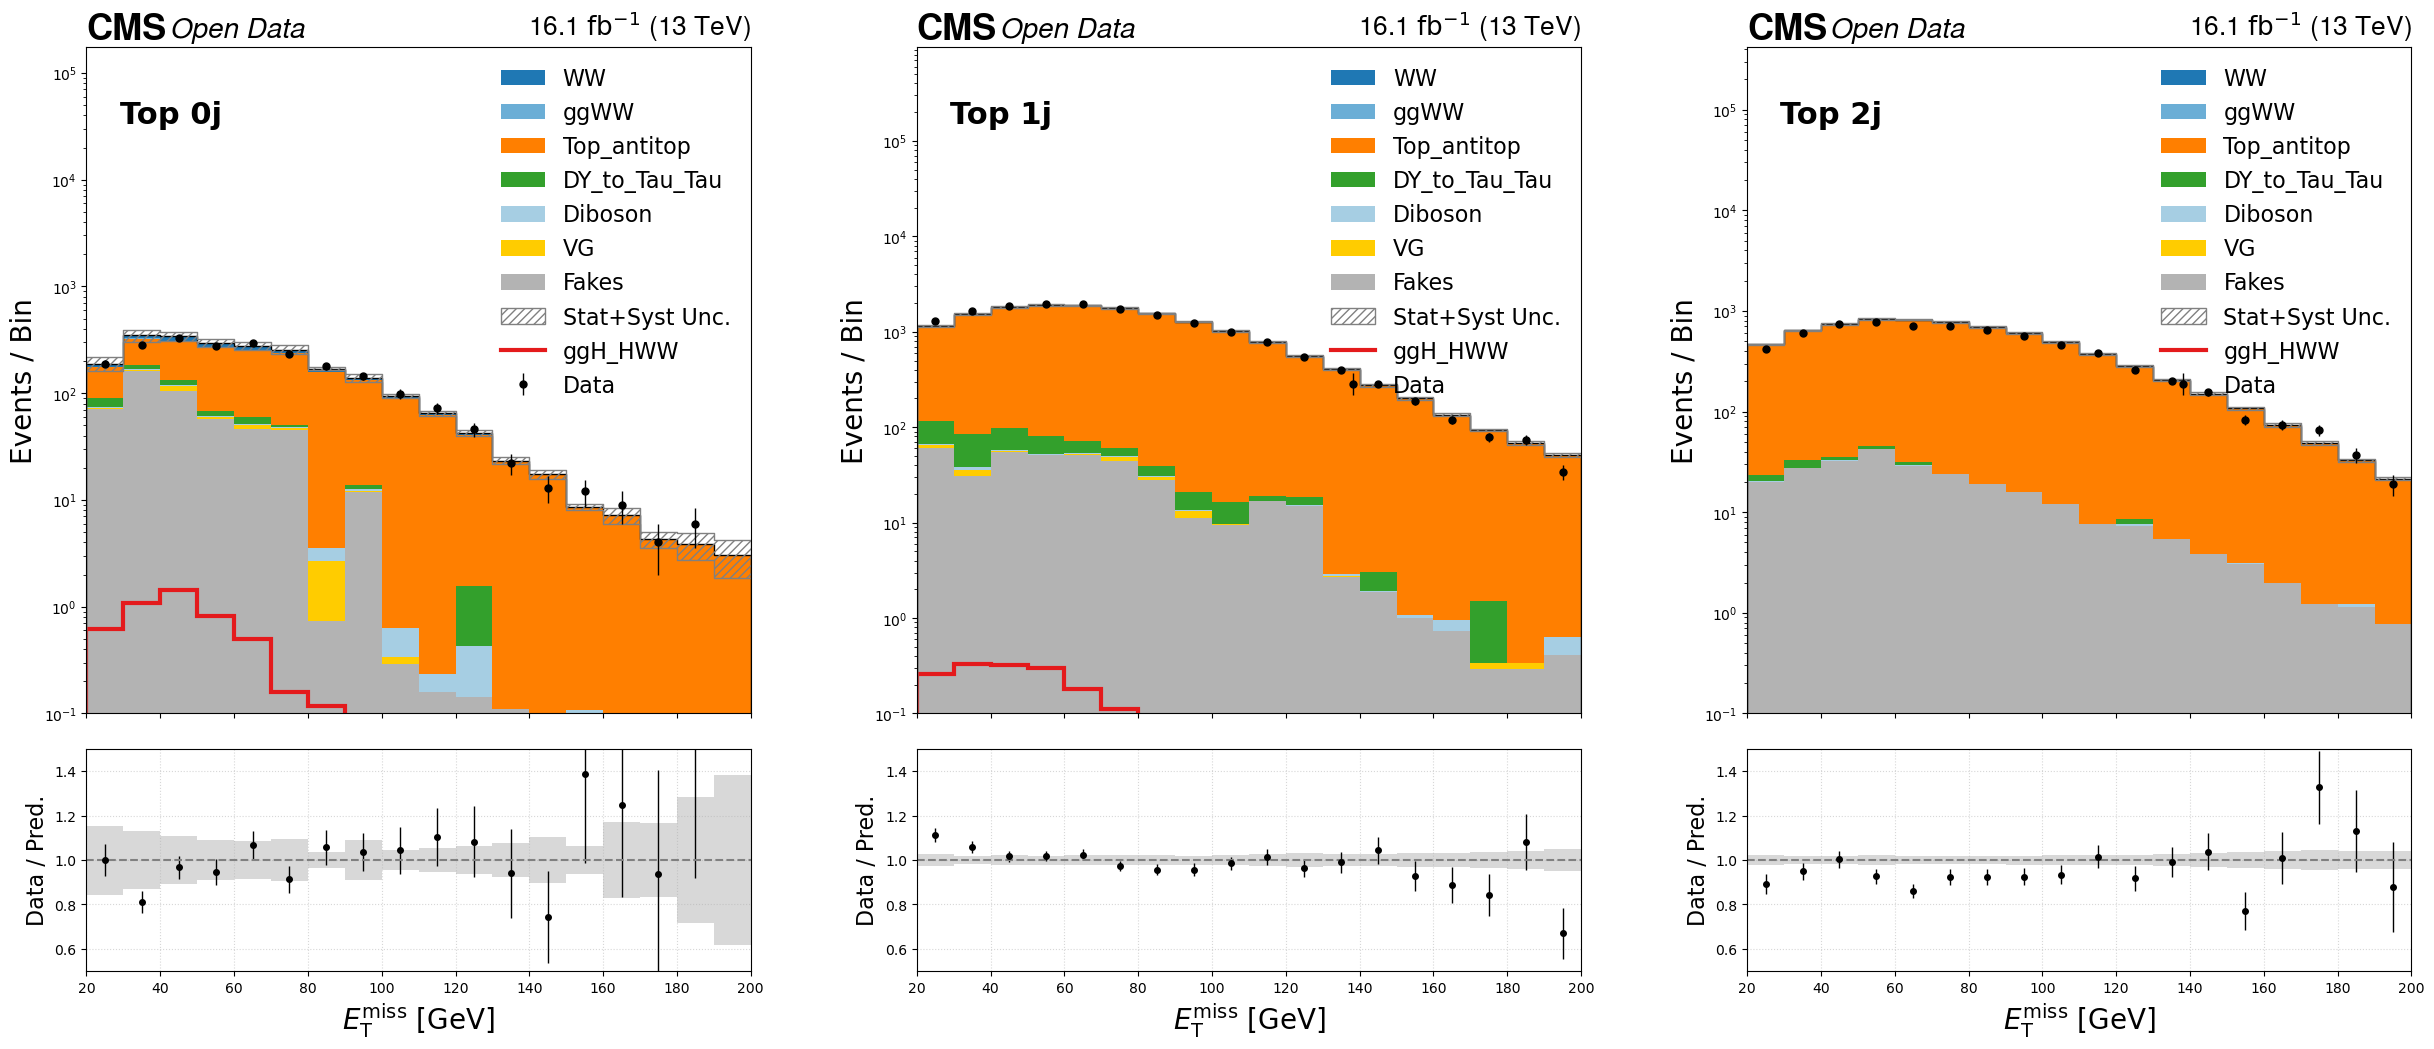

Plotting met in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_met.png


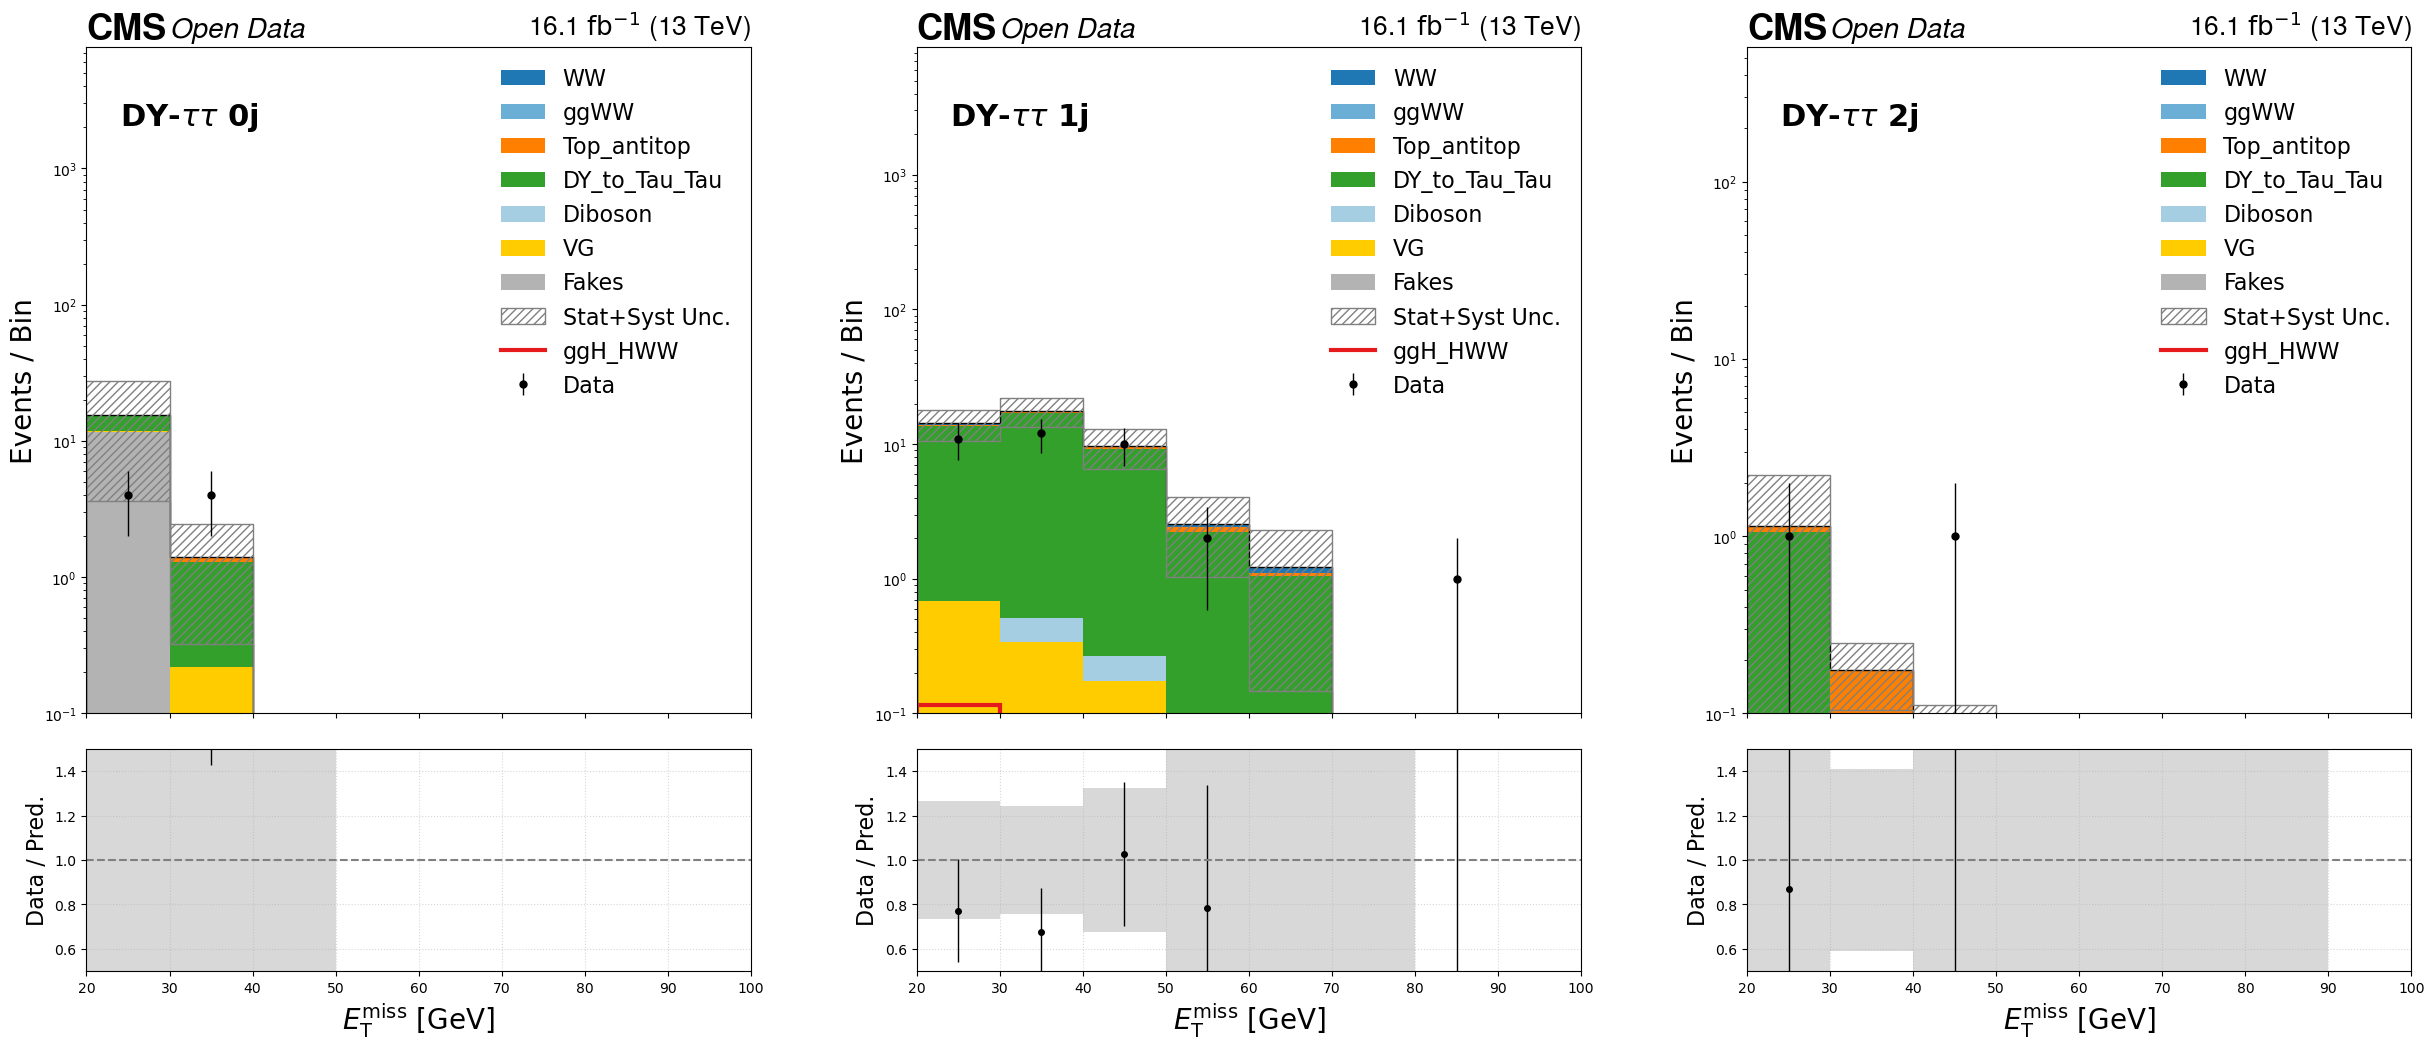

Plotting ptll in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_ptll.png


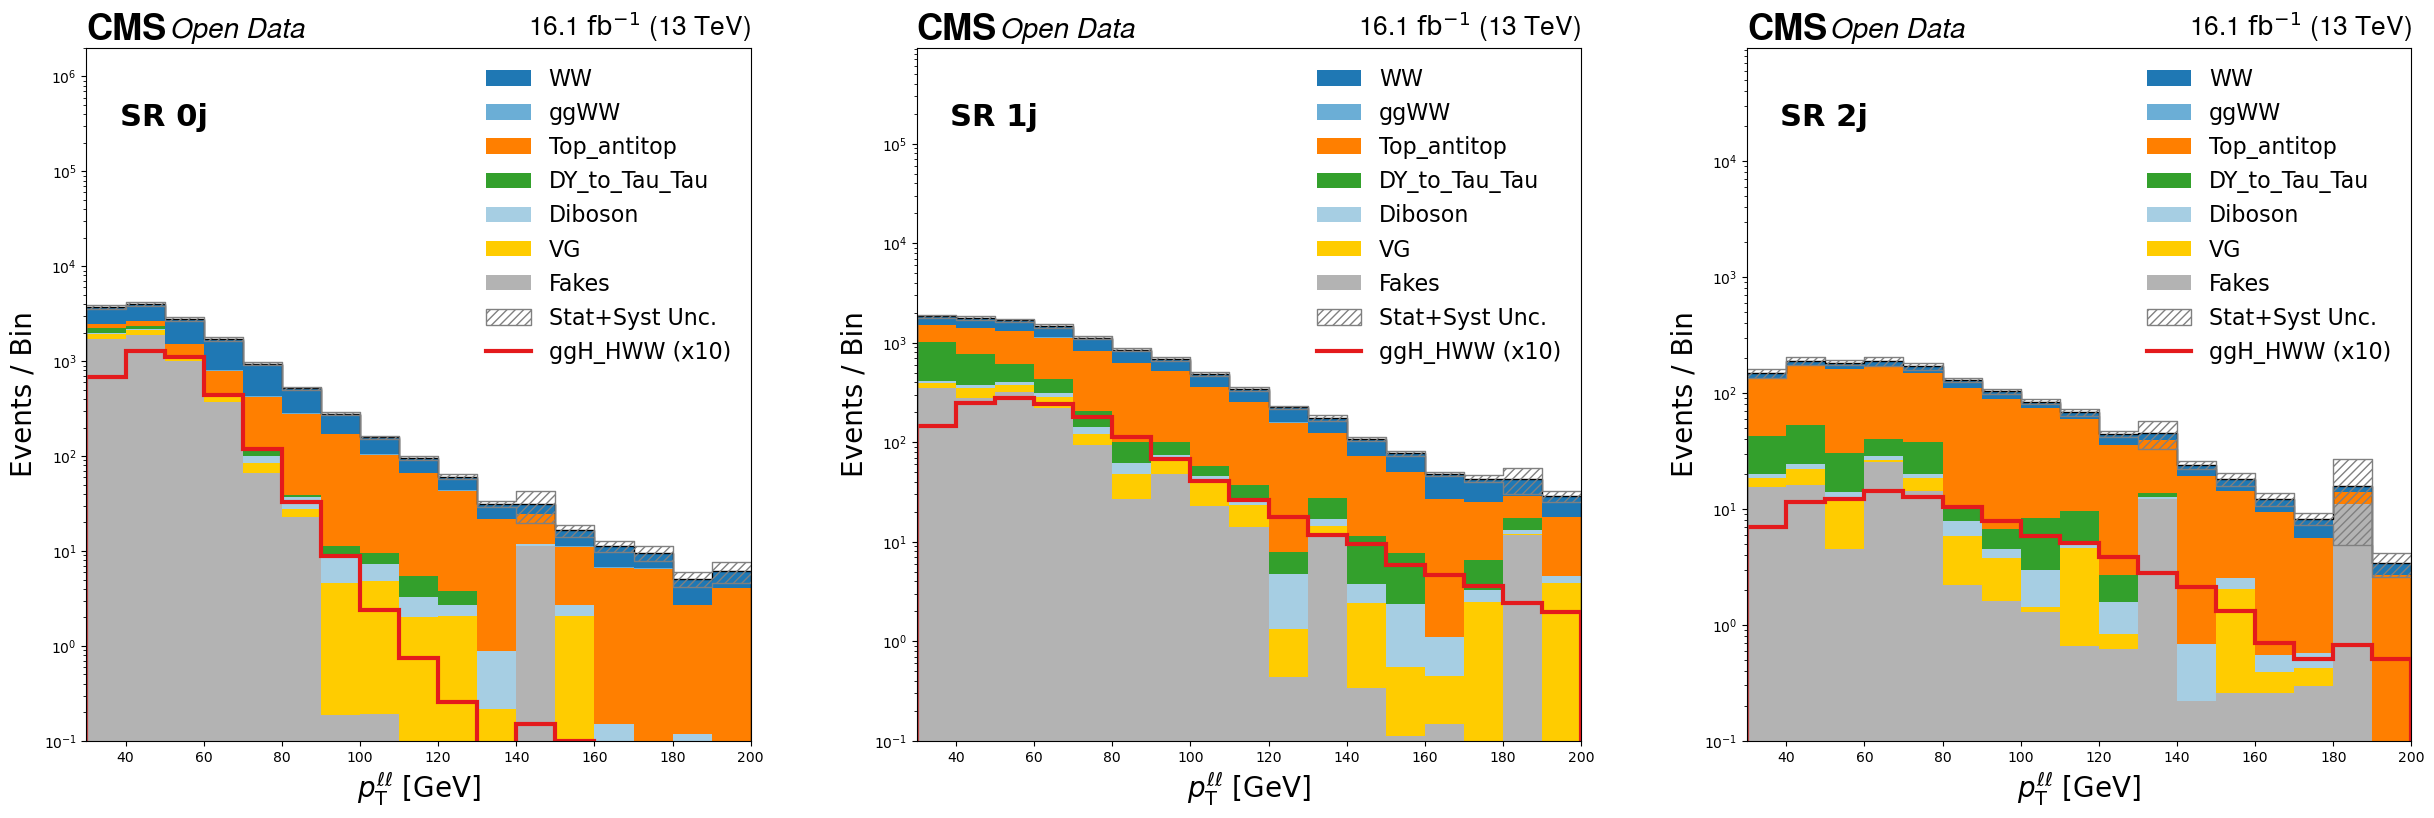

Plotting ptll in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_ptll.png


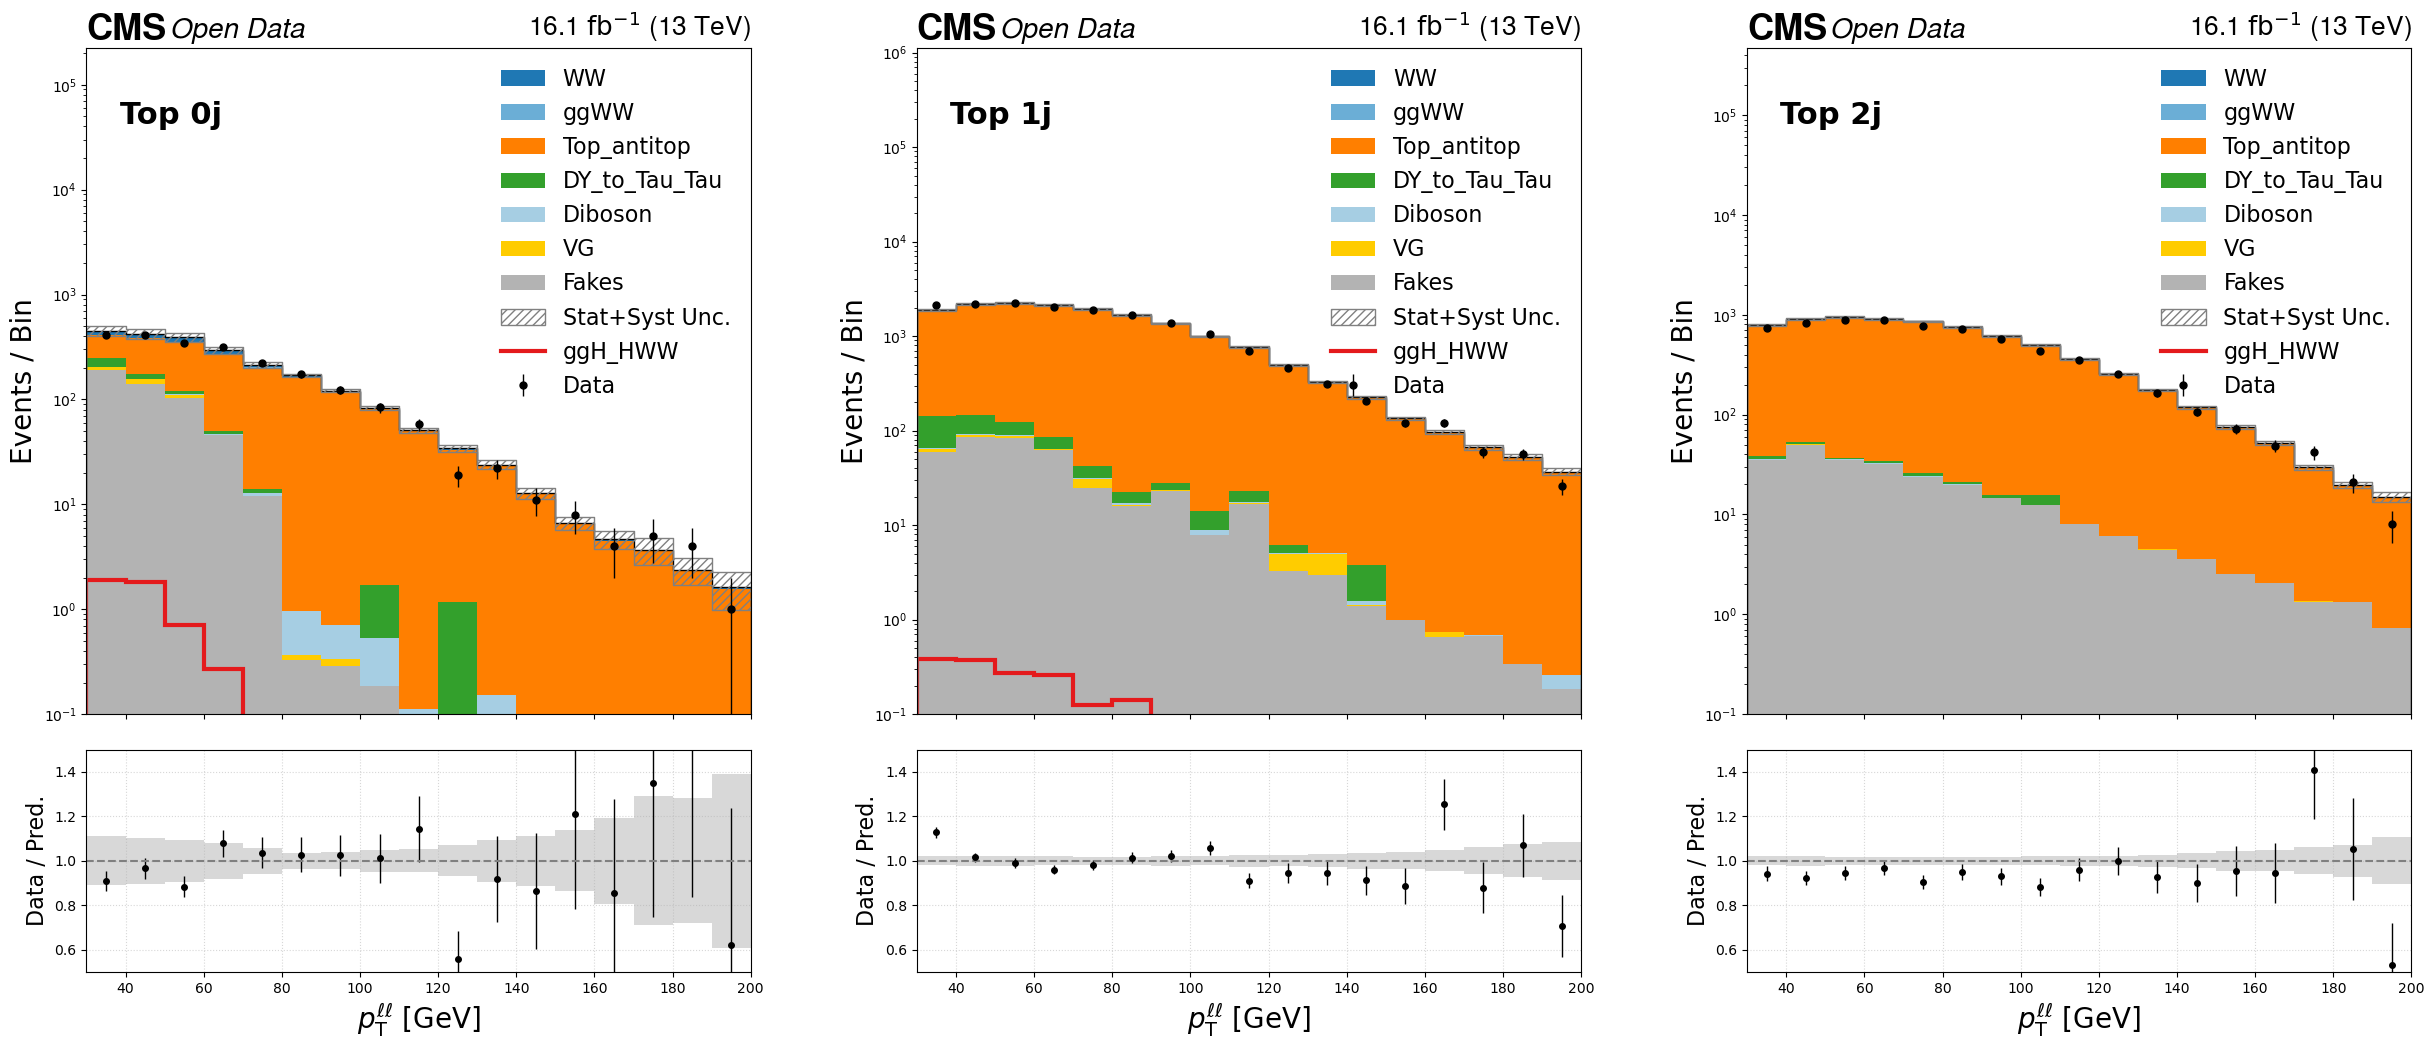

Plotting ptll in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_ptll.png


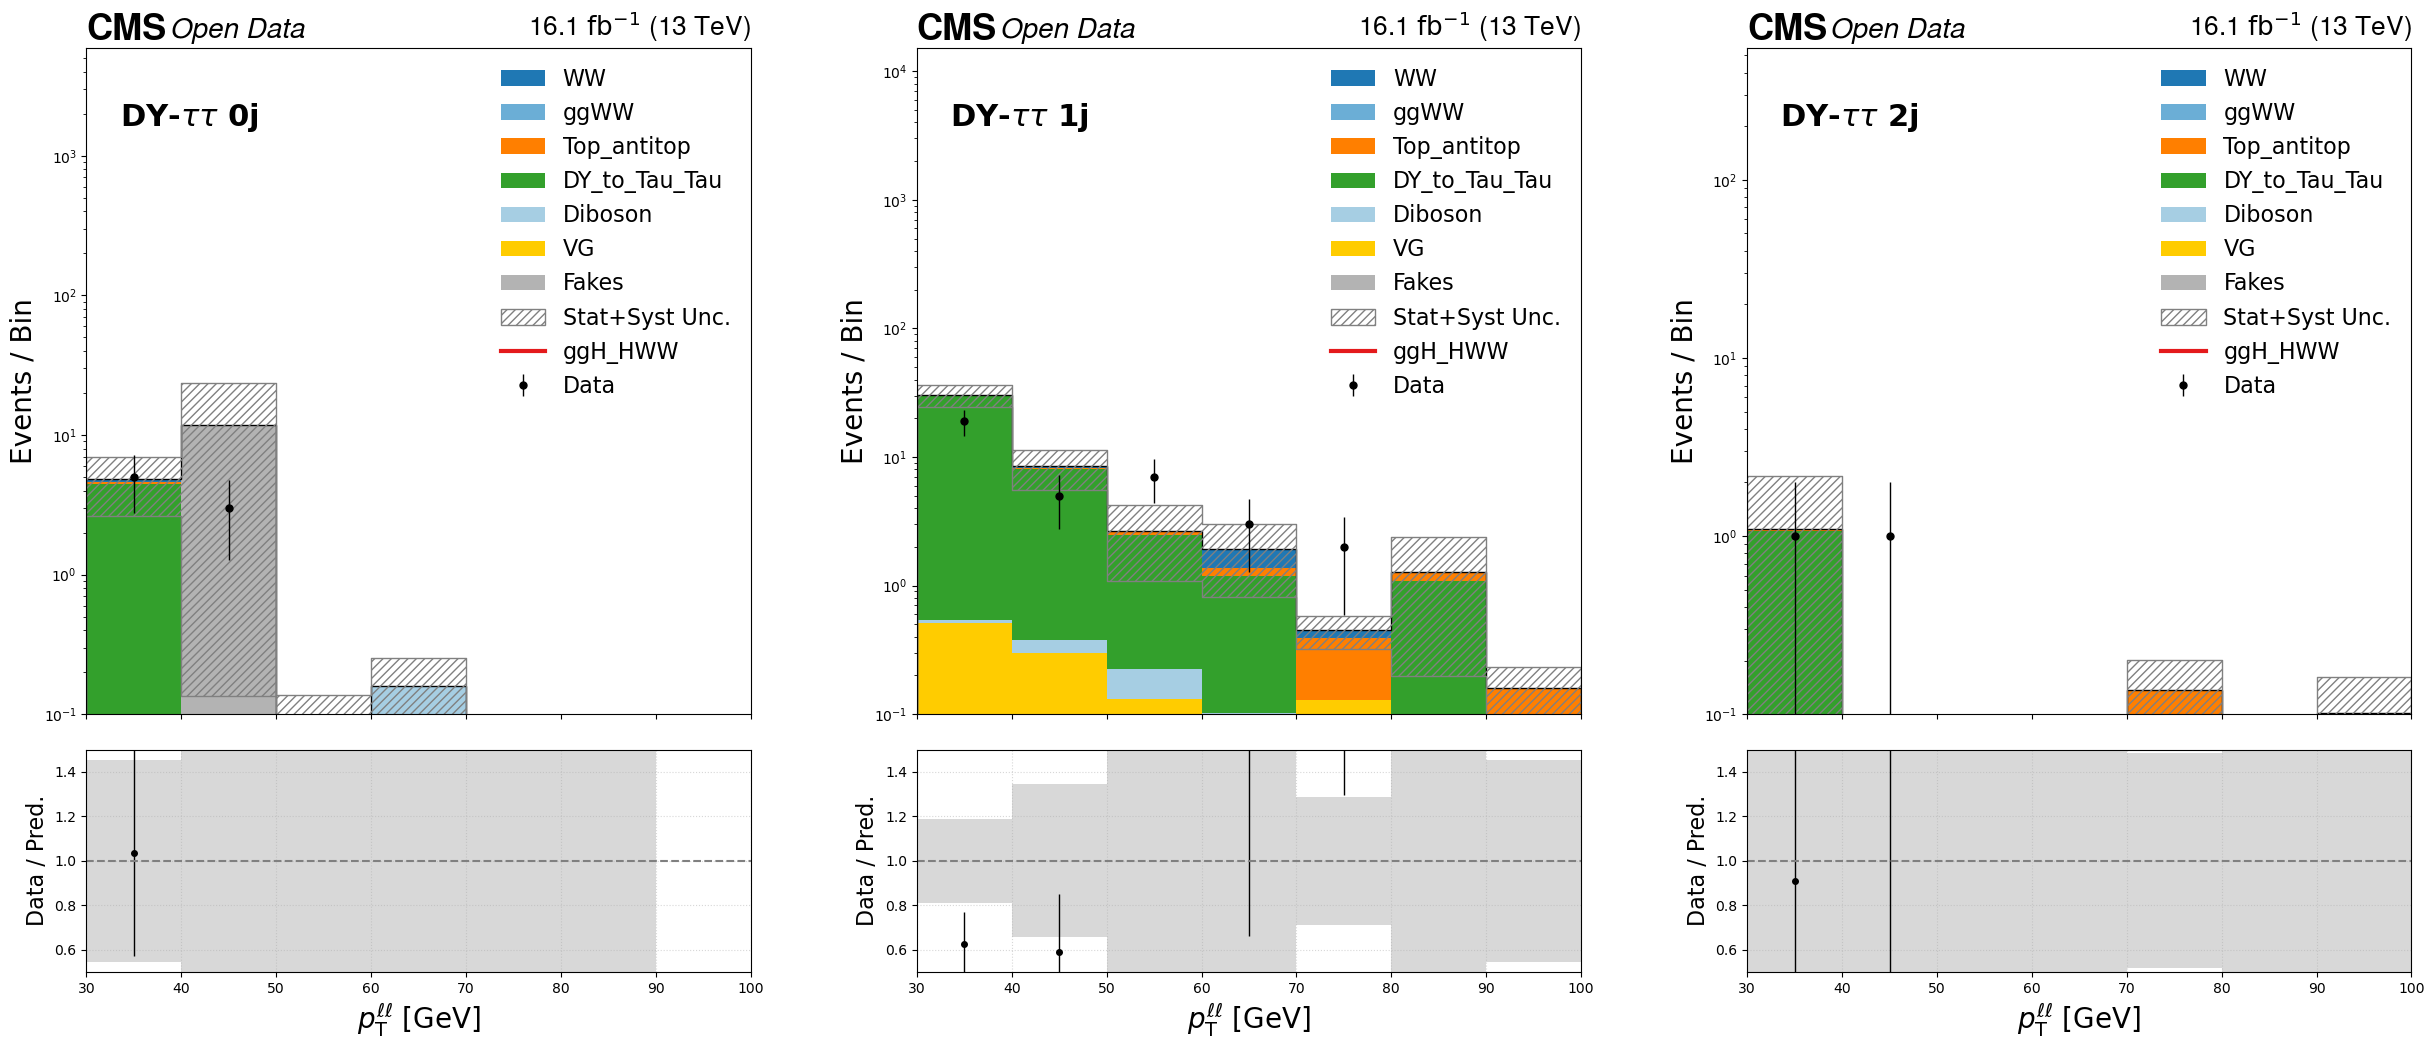

Plotting dphi in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_dphi.png


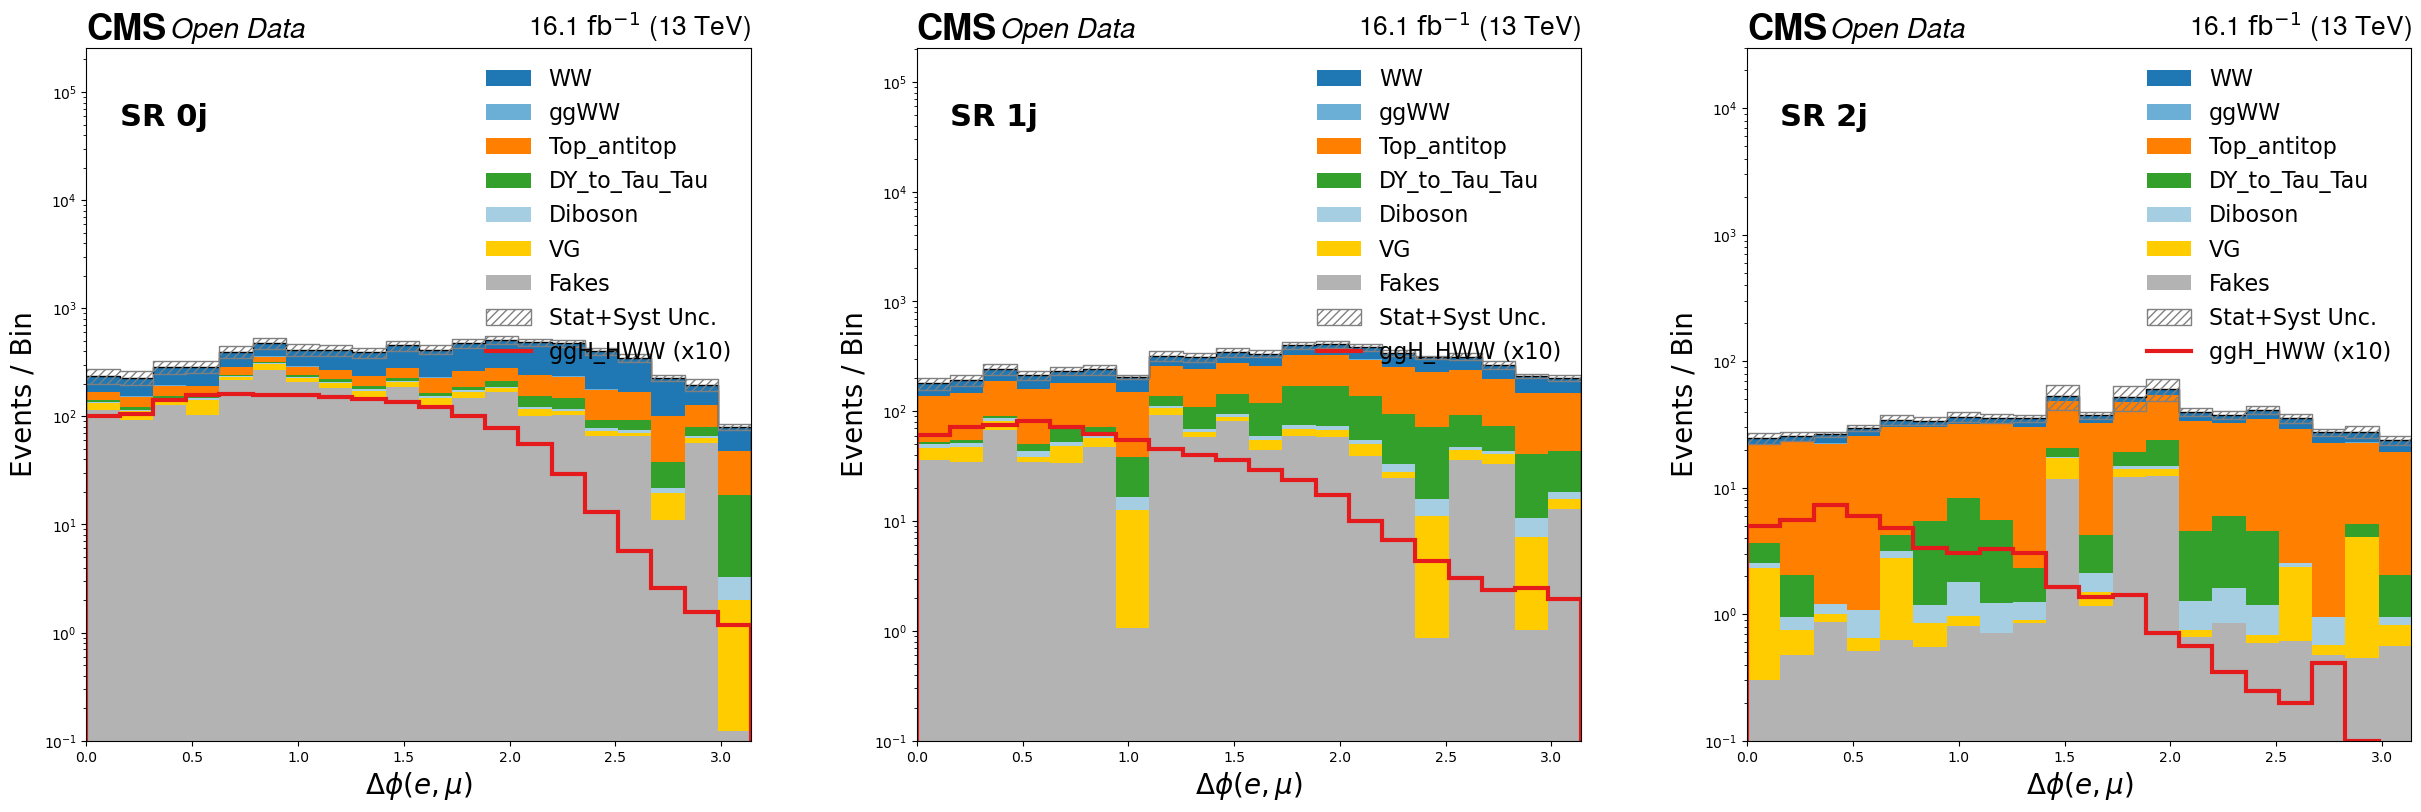

Plotting dphi in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_dphi.png


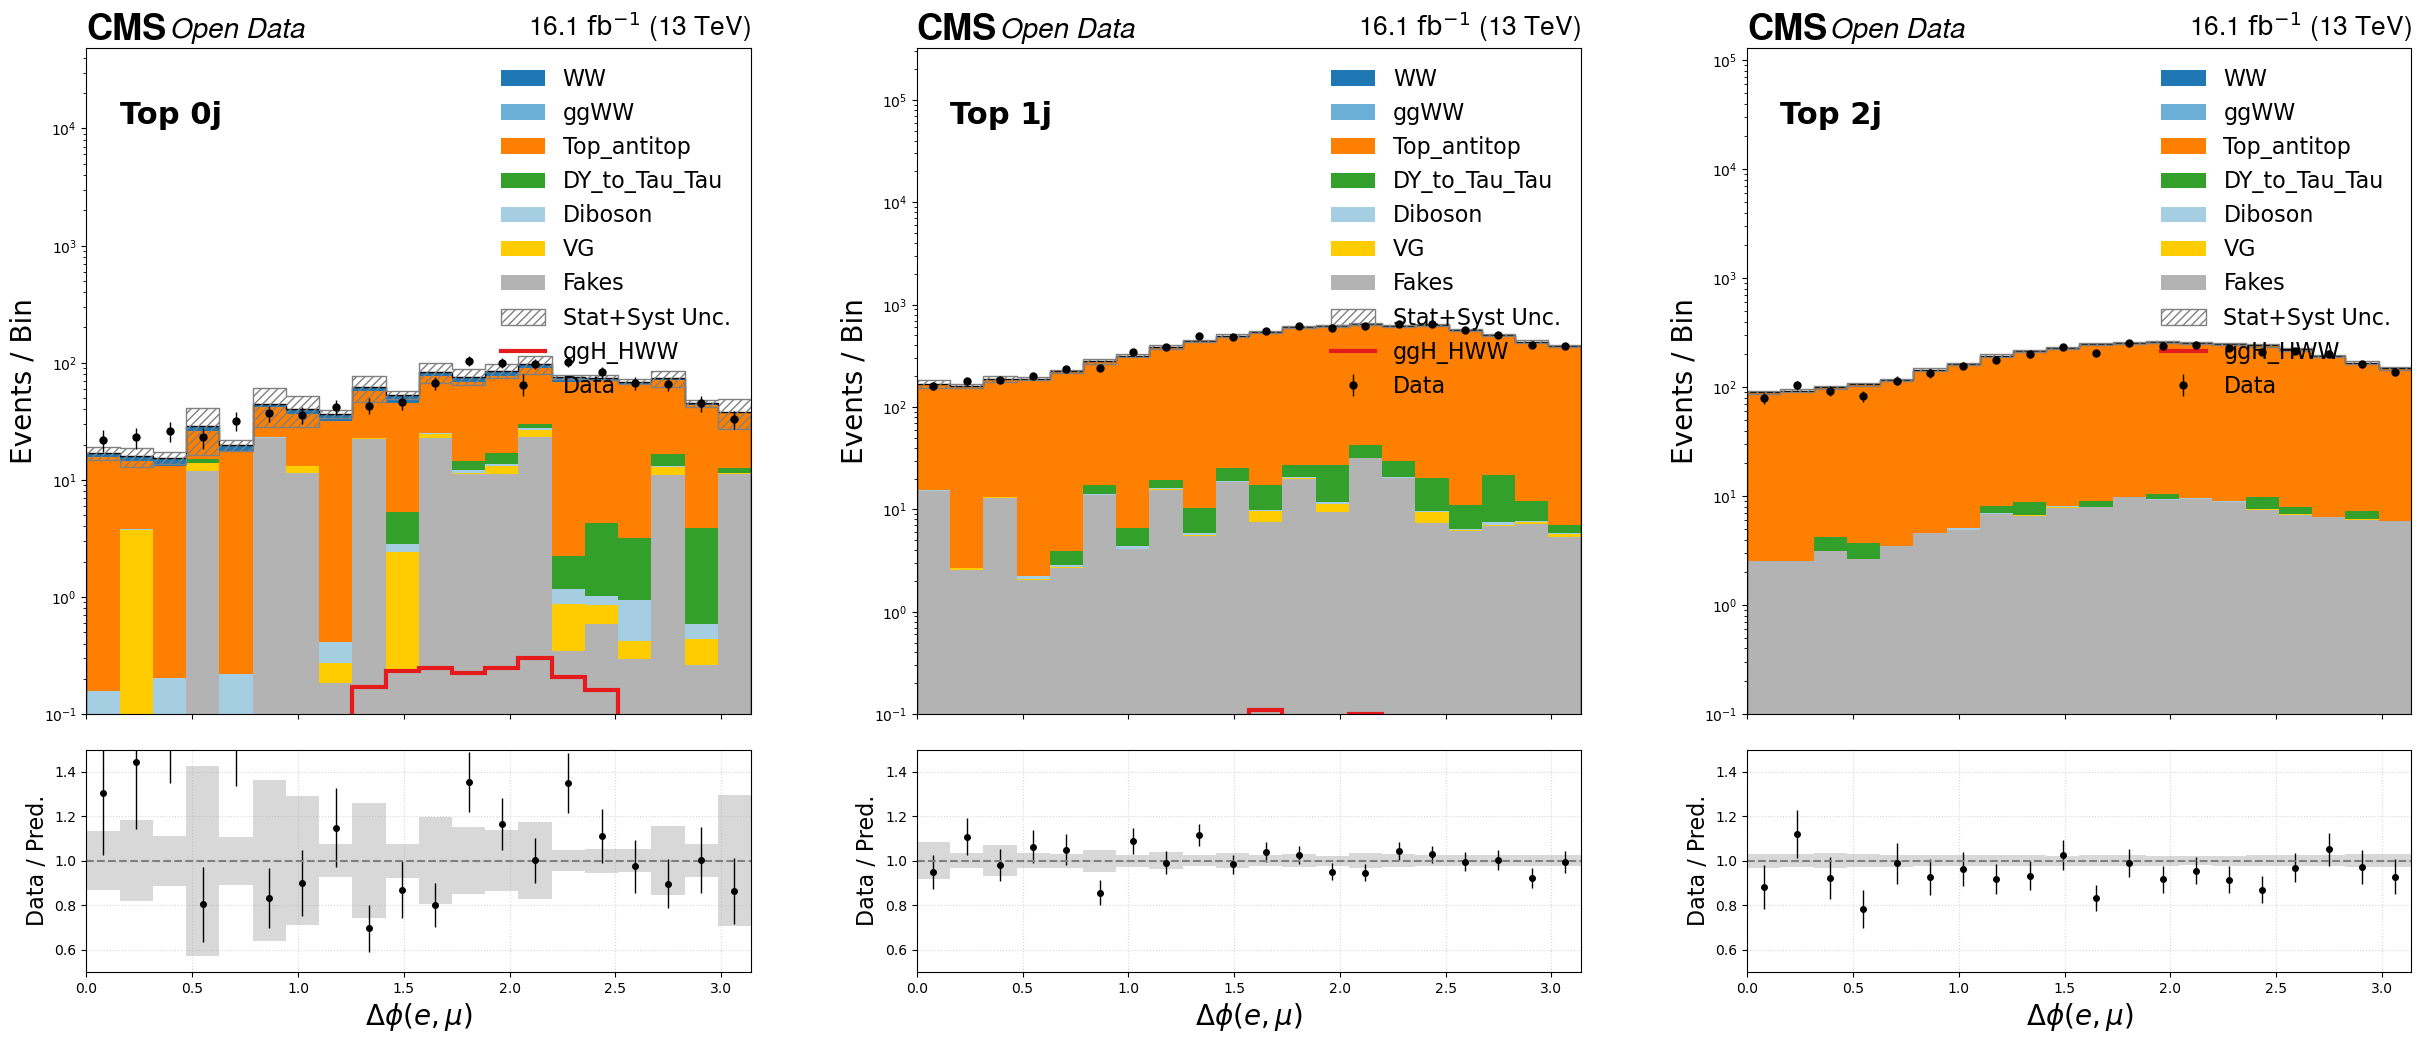

Plotting dphi in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_dphi.png


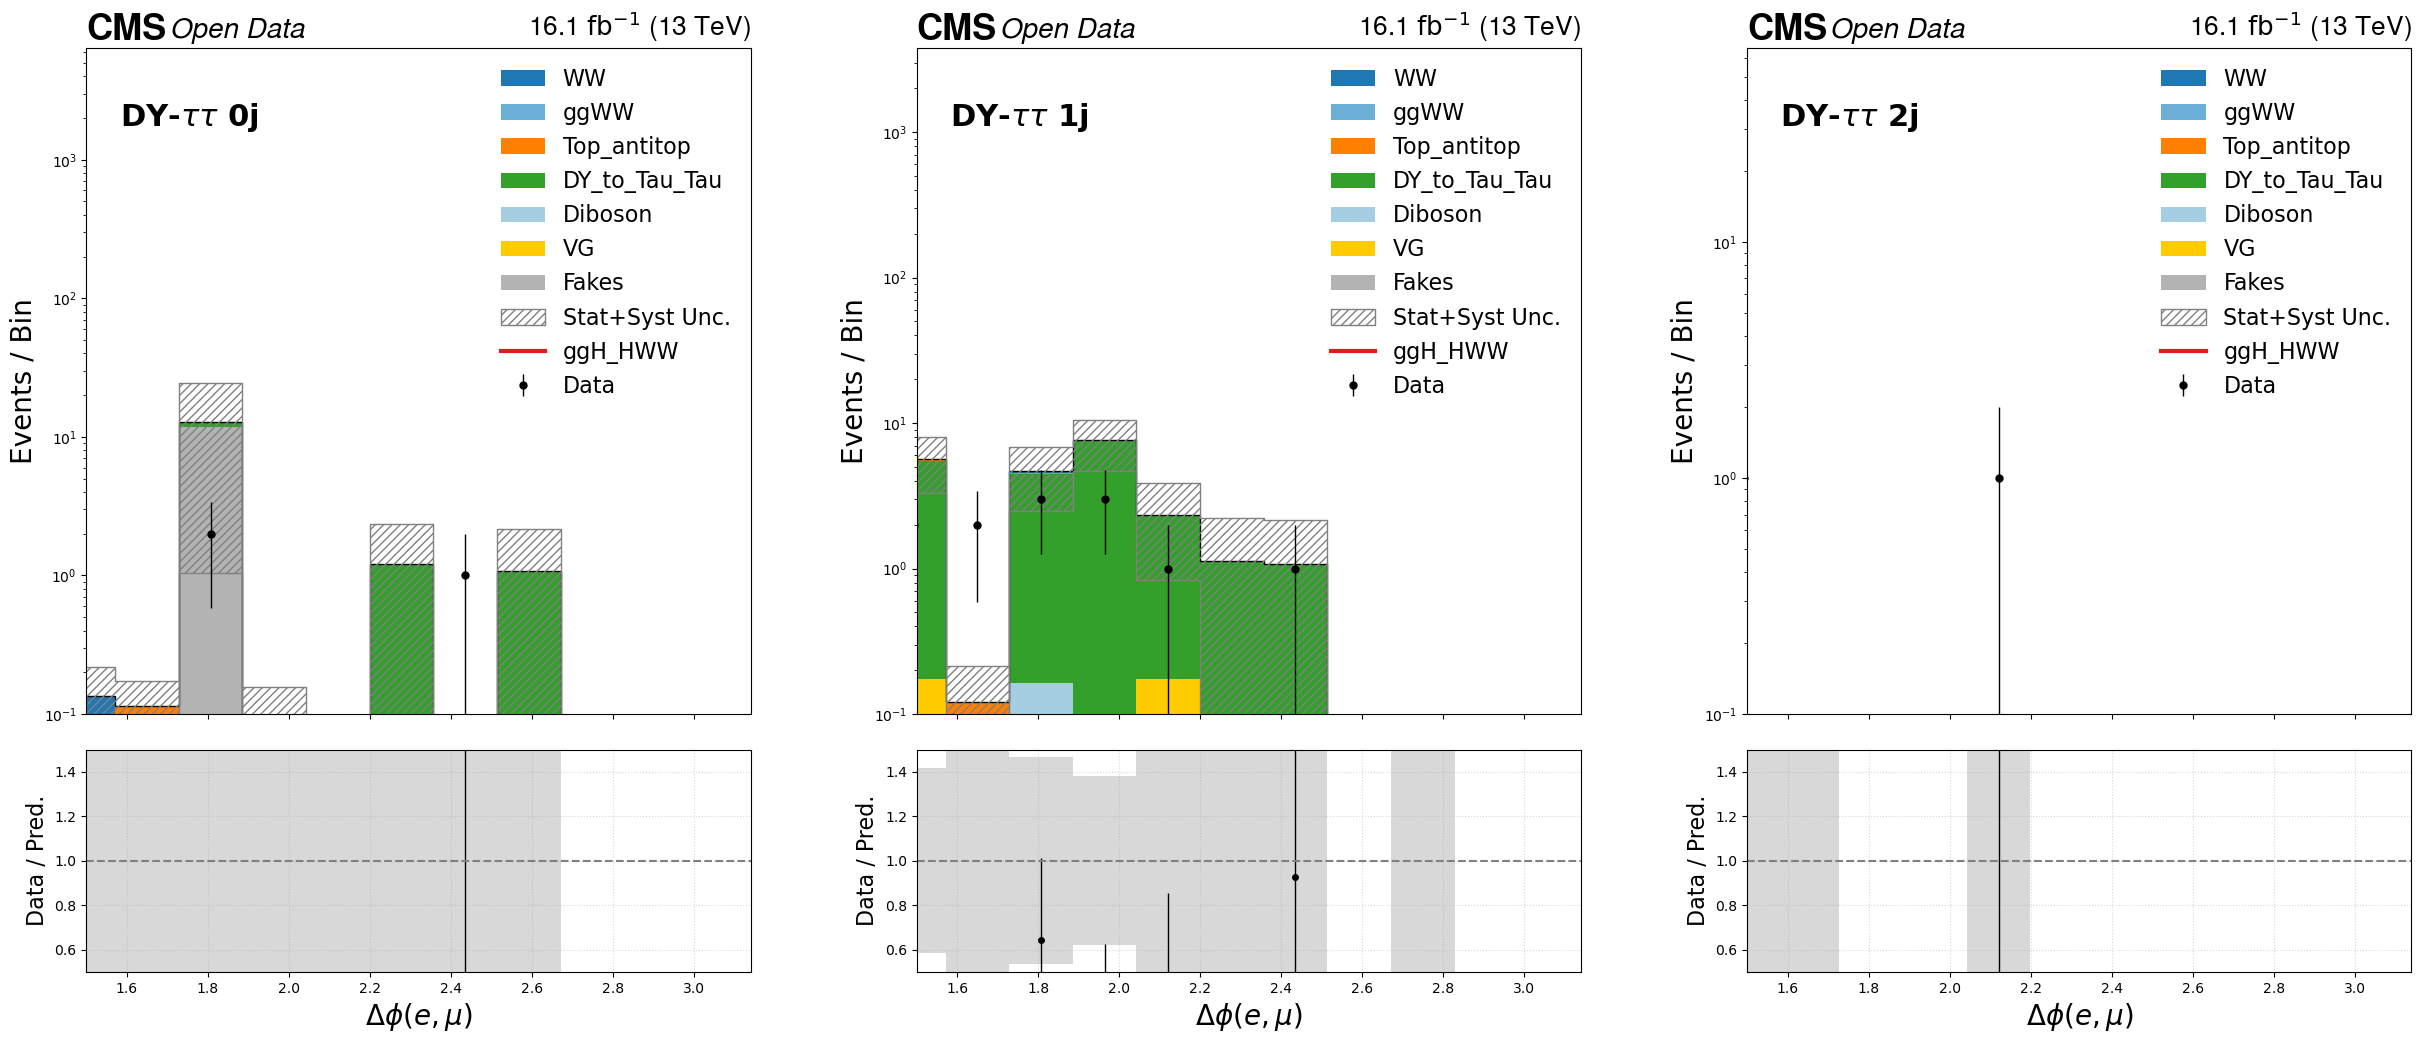

Plotting mt_higgs in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_higgs.png


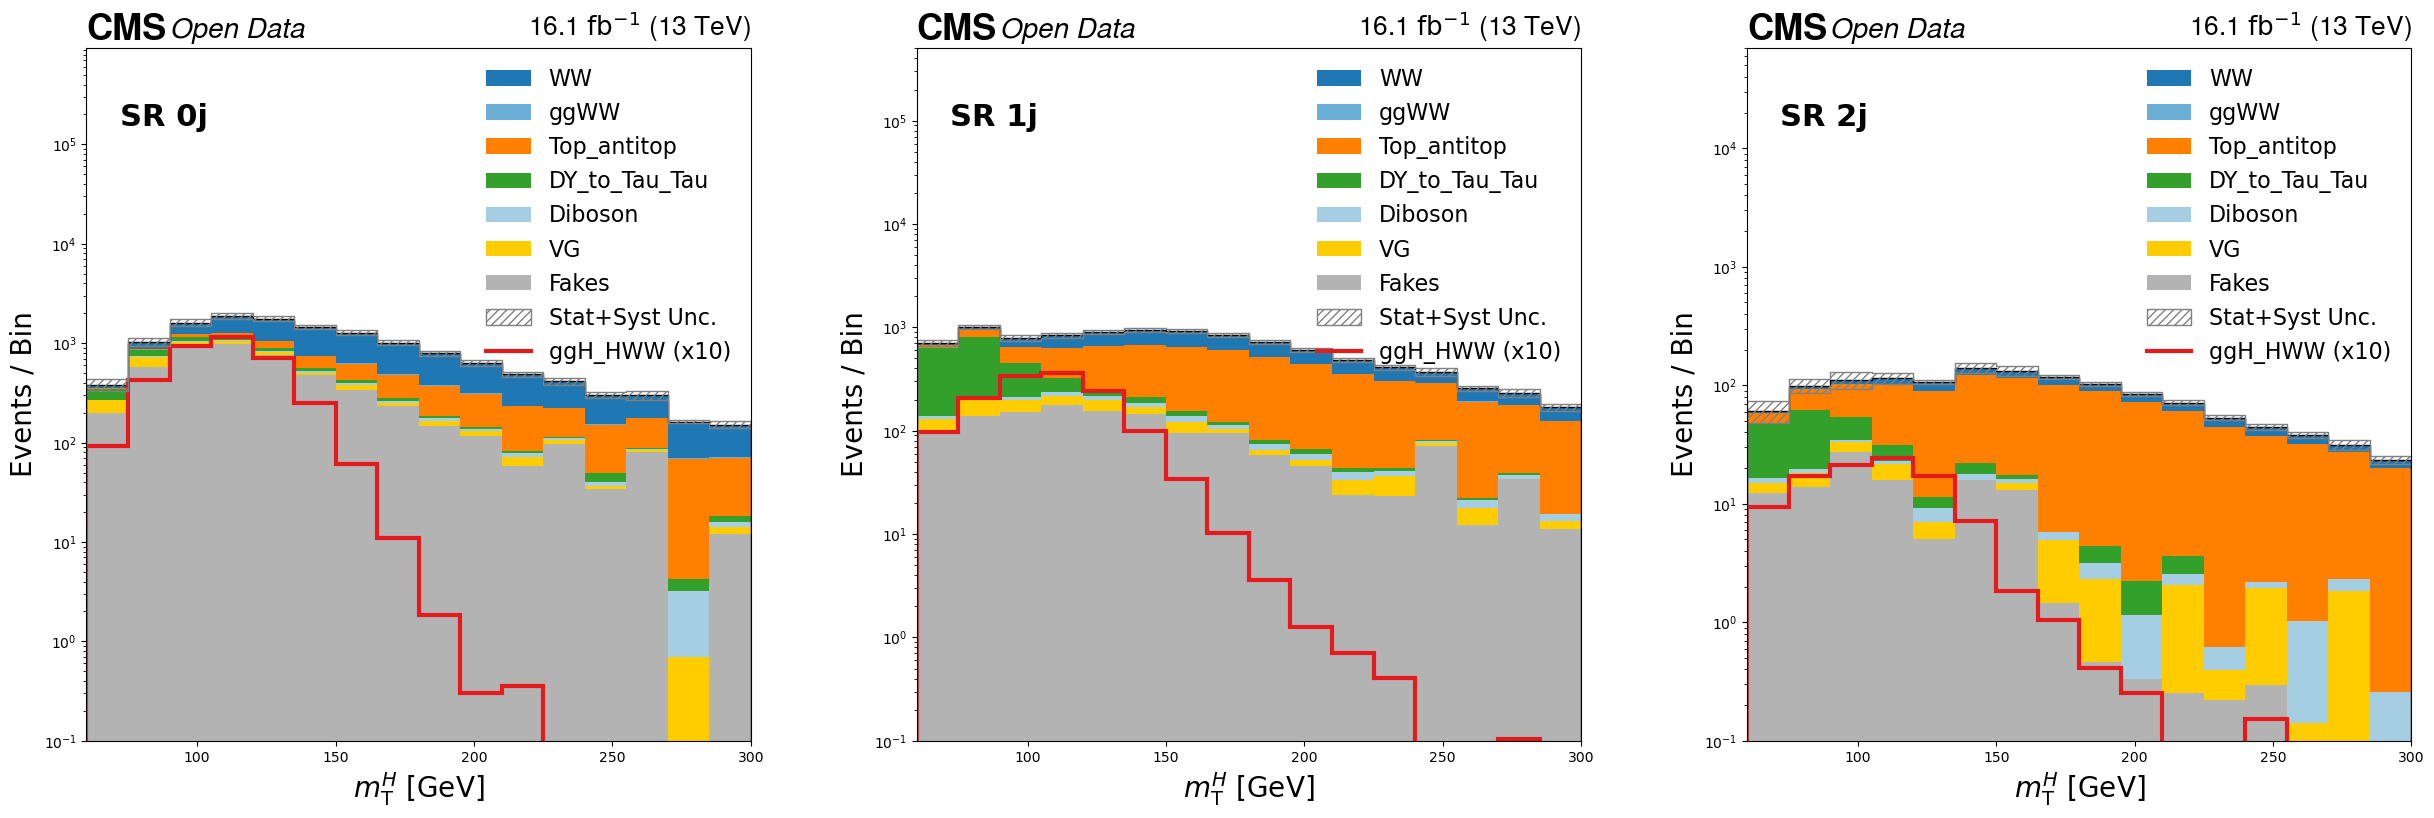

Plotting mt_higgs in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_higgs.png


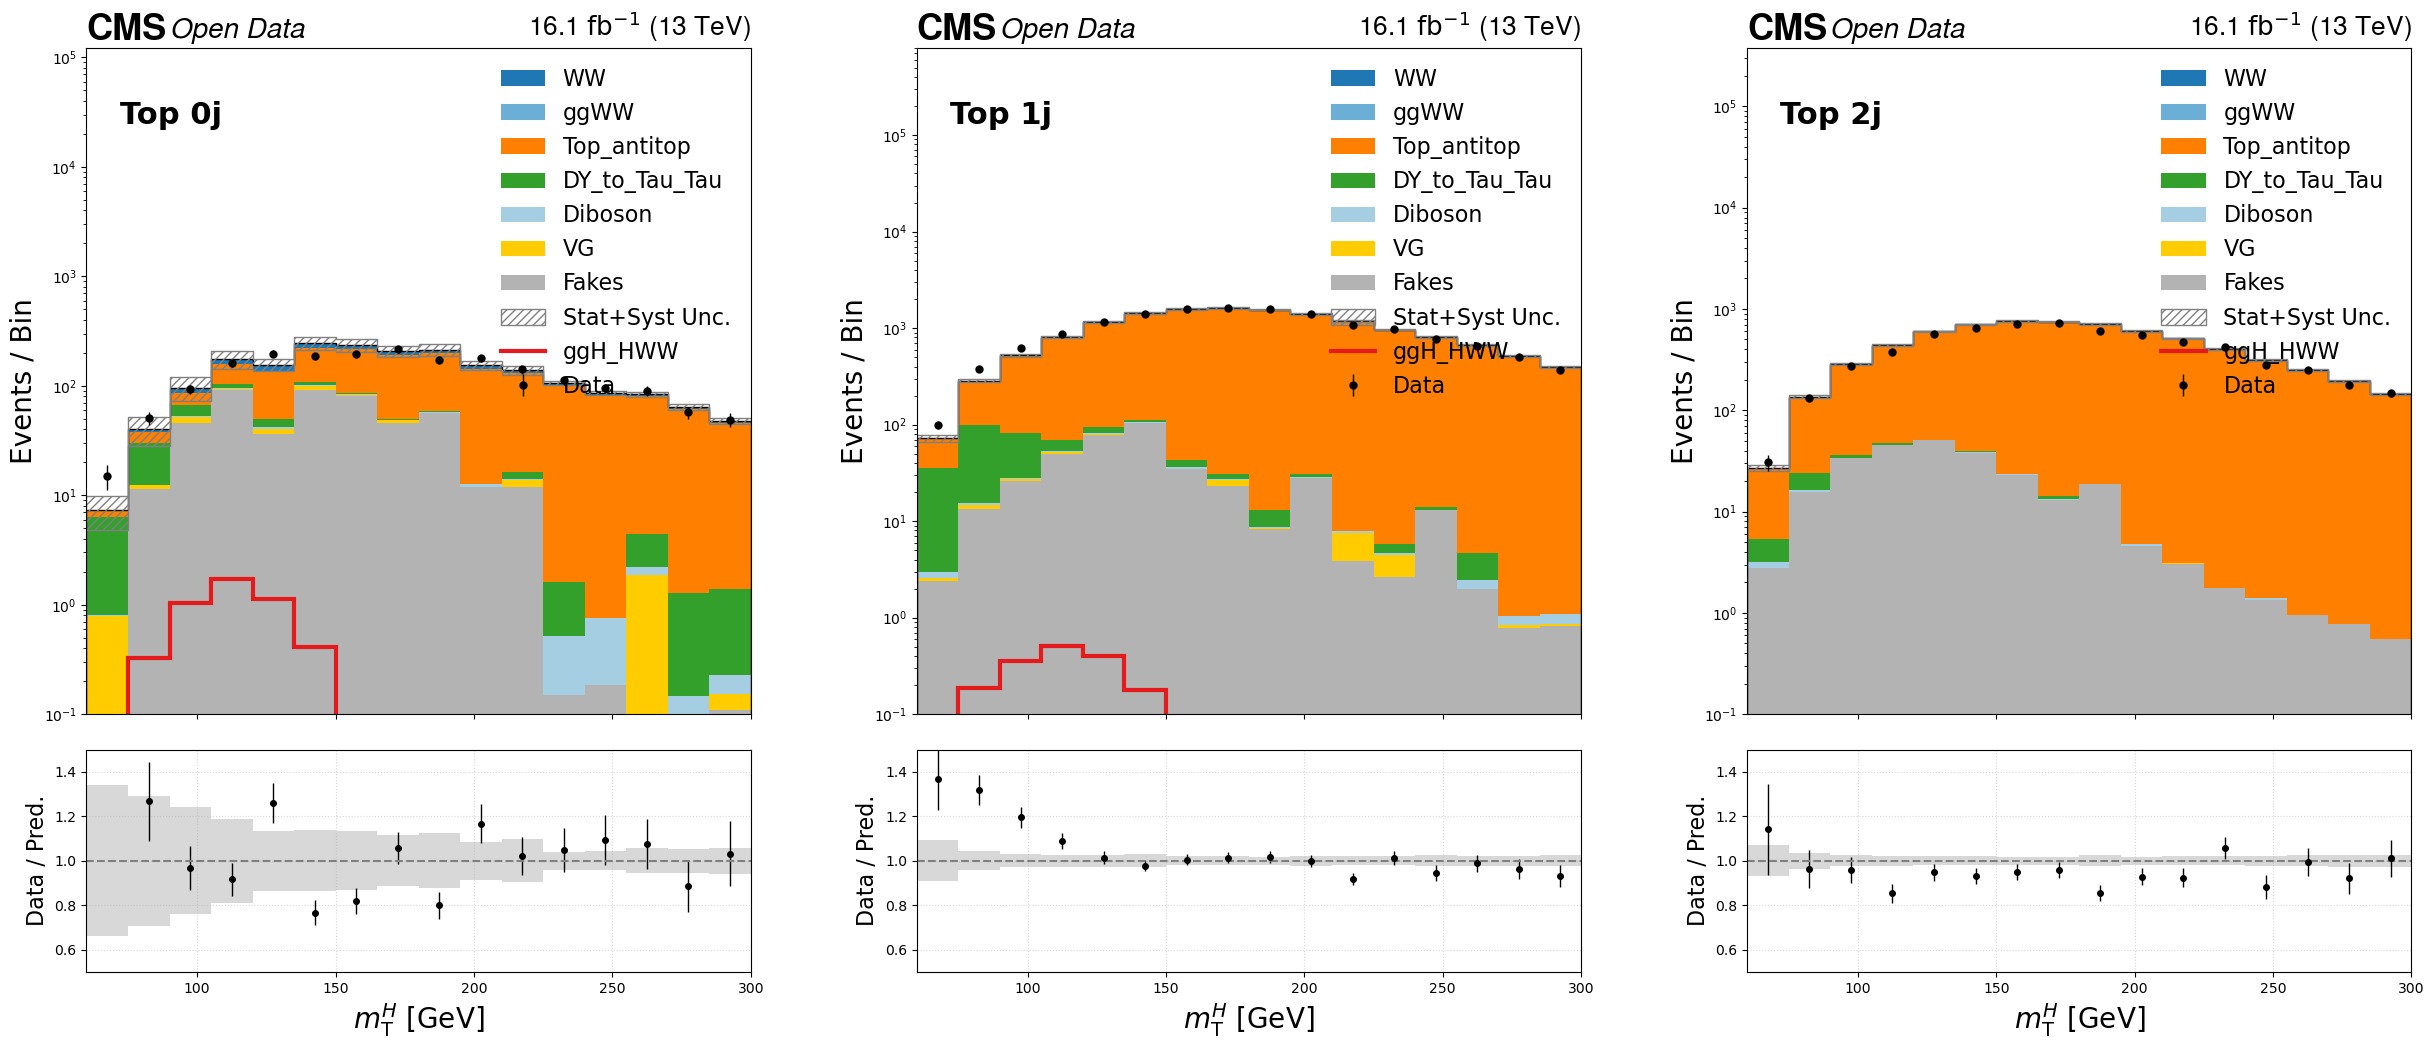

Plotting mt_higgs in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_higgs.png


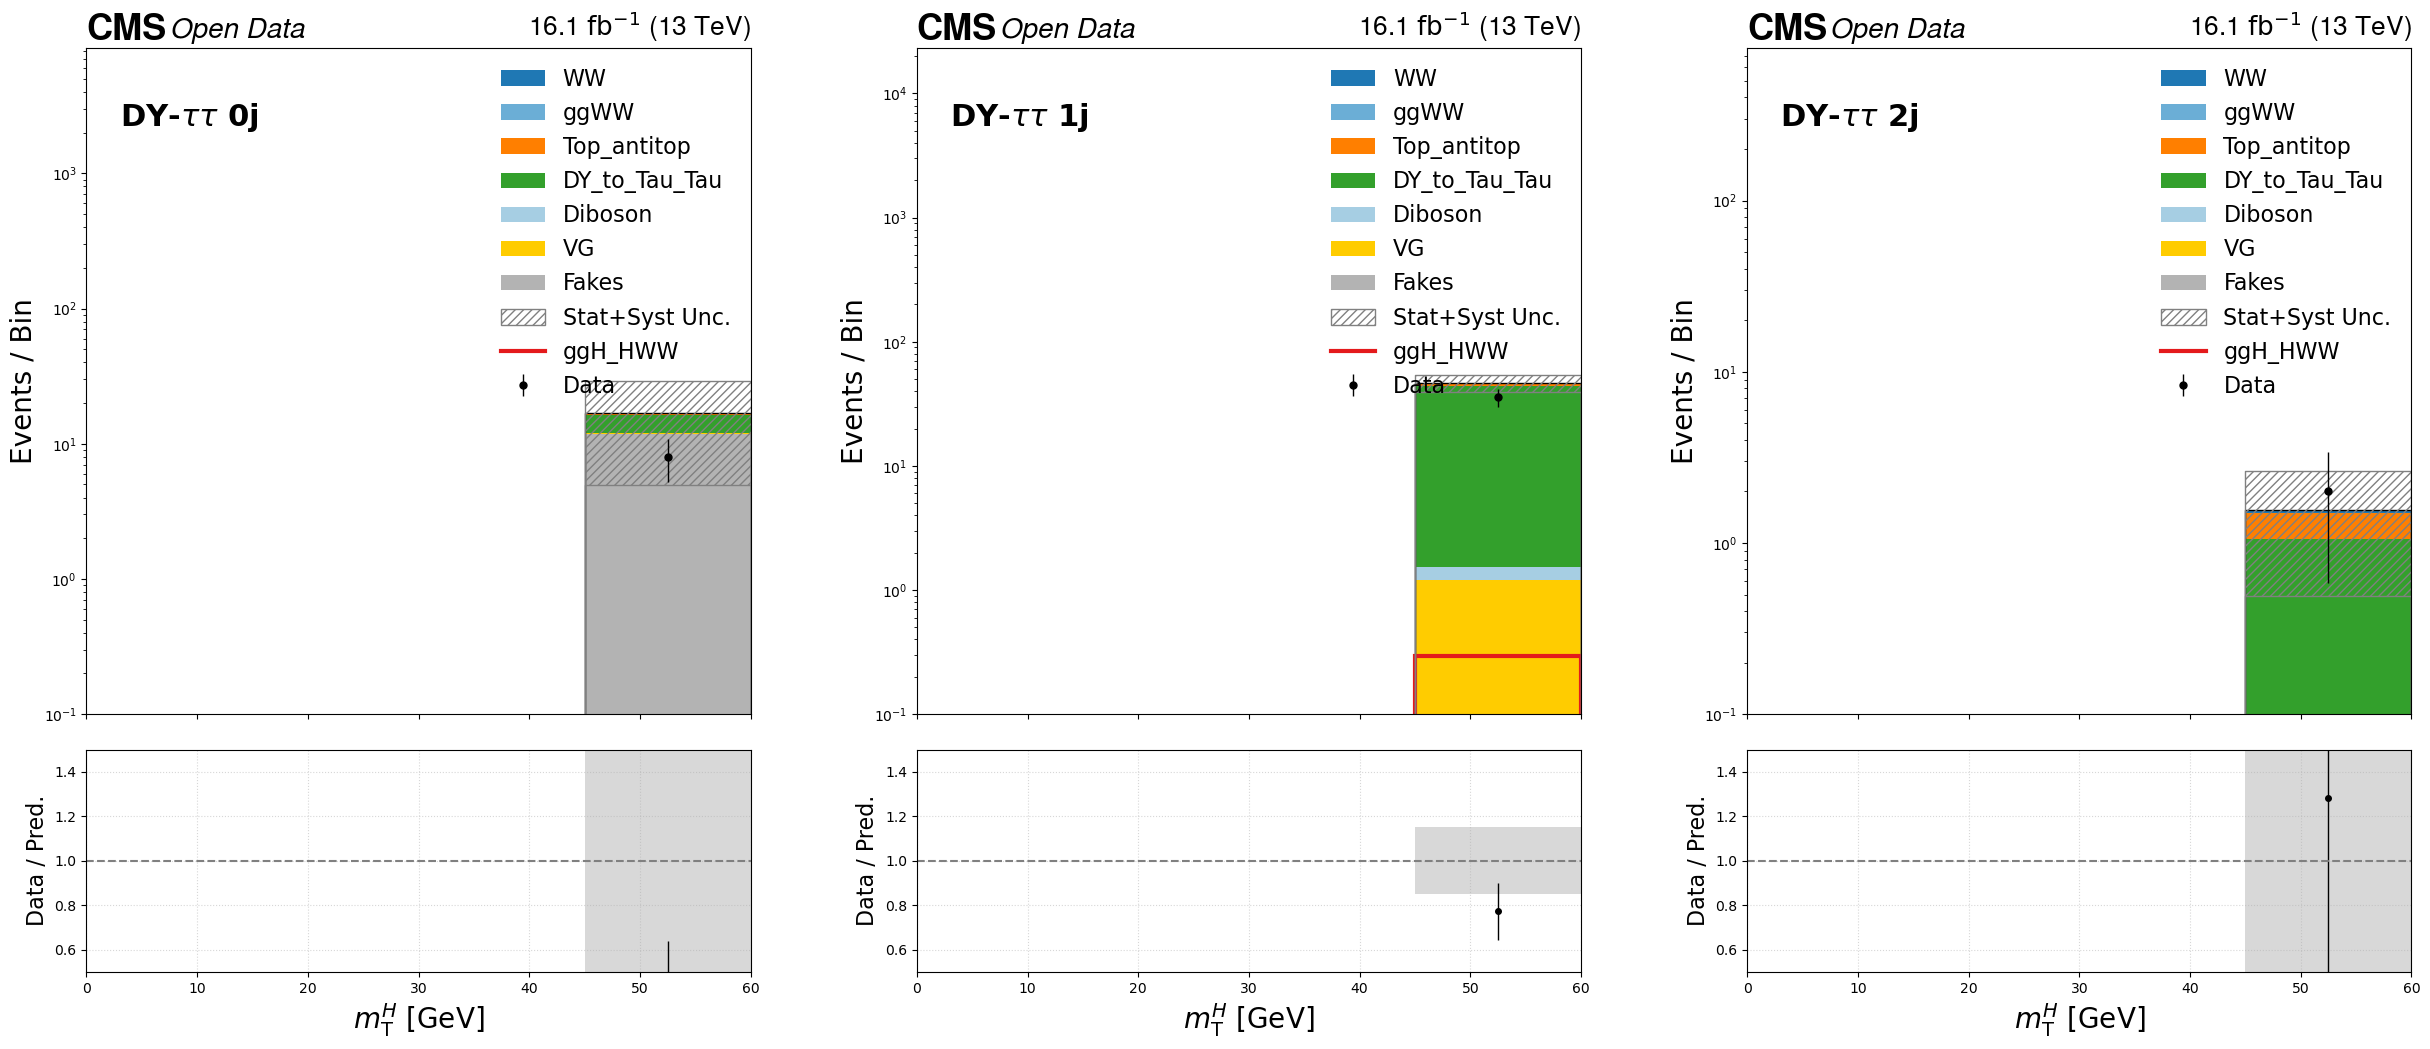

Plotting mt_l2_met in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mt_l2_met.png


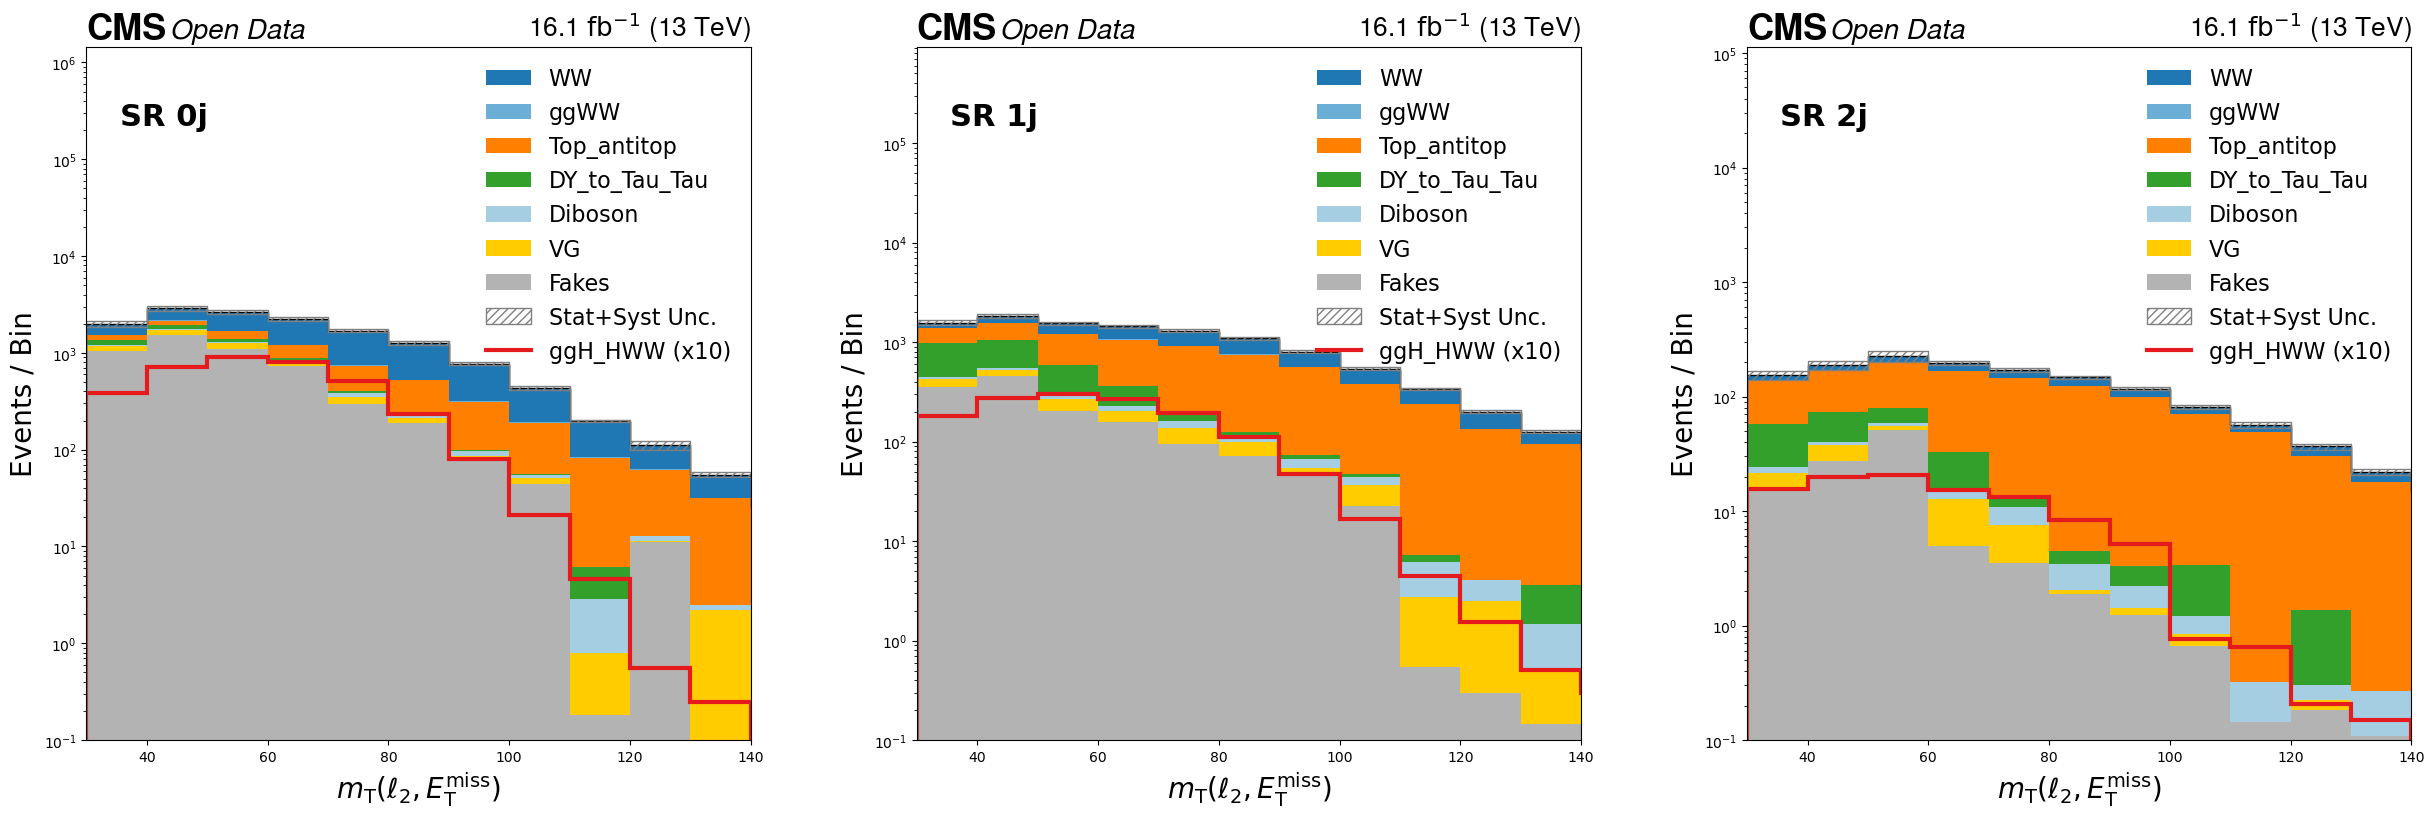

Plotting mt_l2_met in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mt_l2_met.png


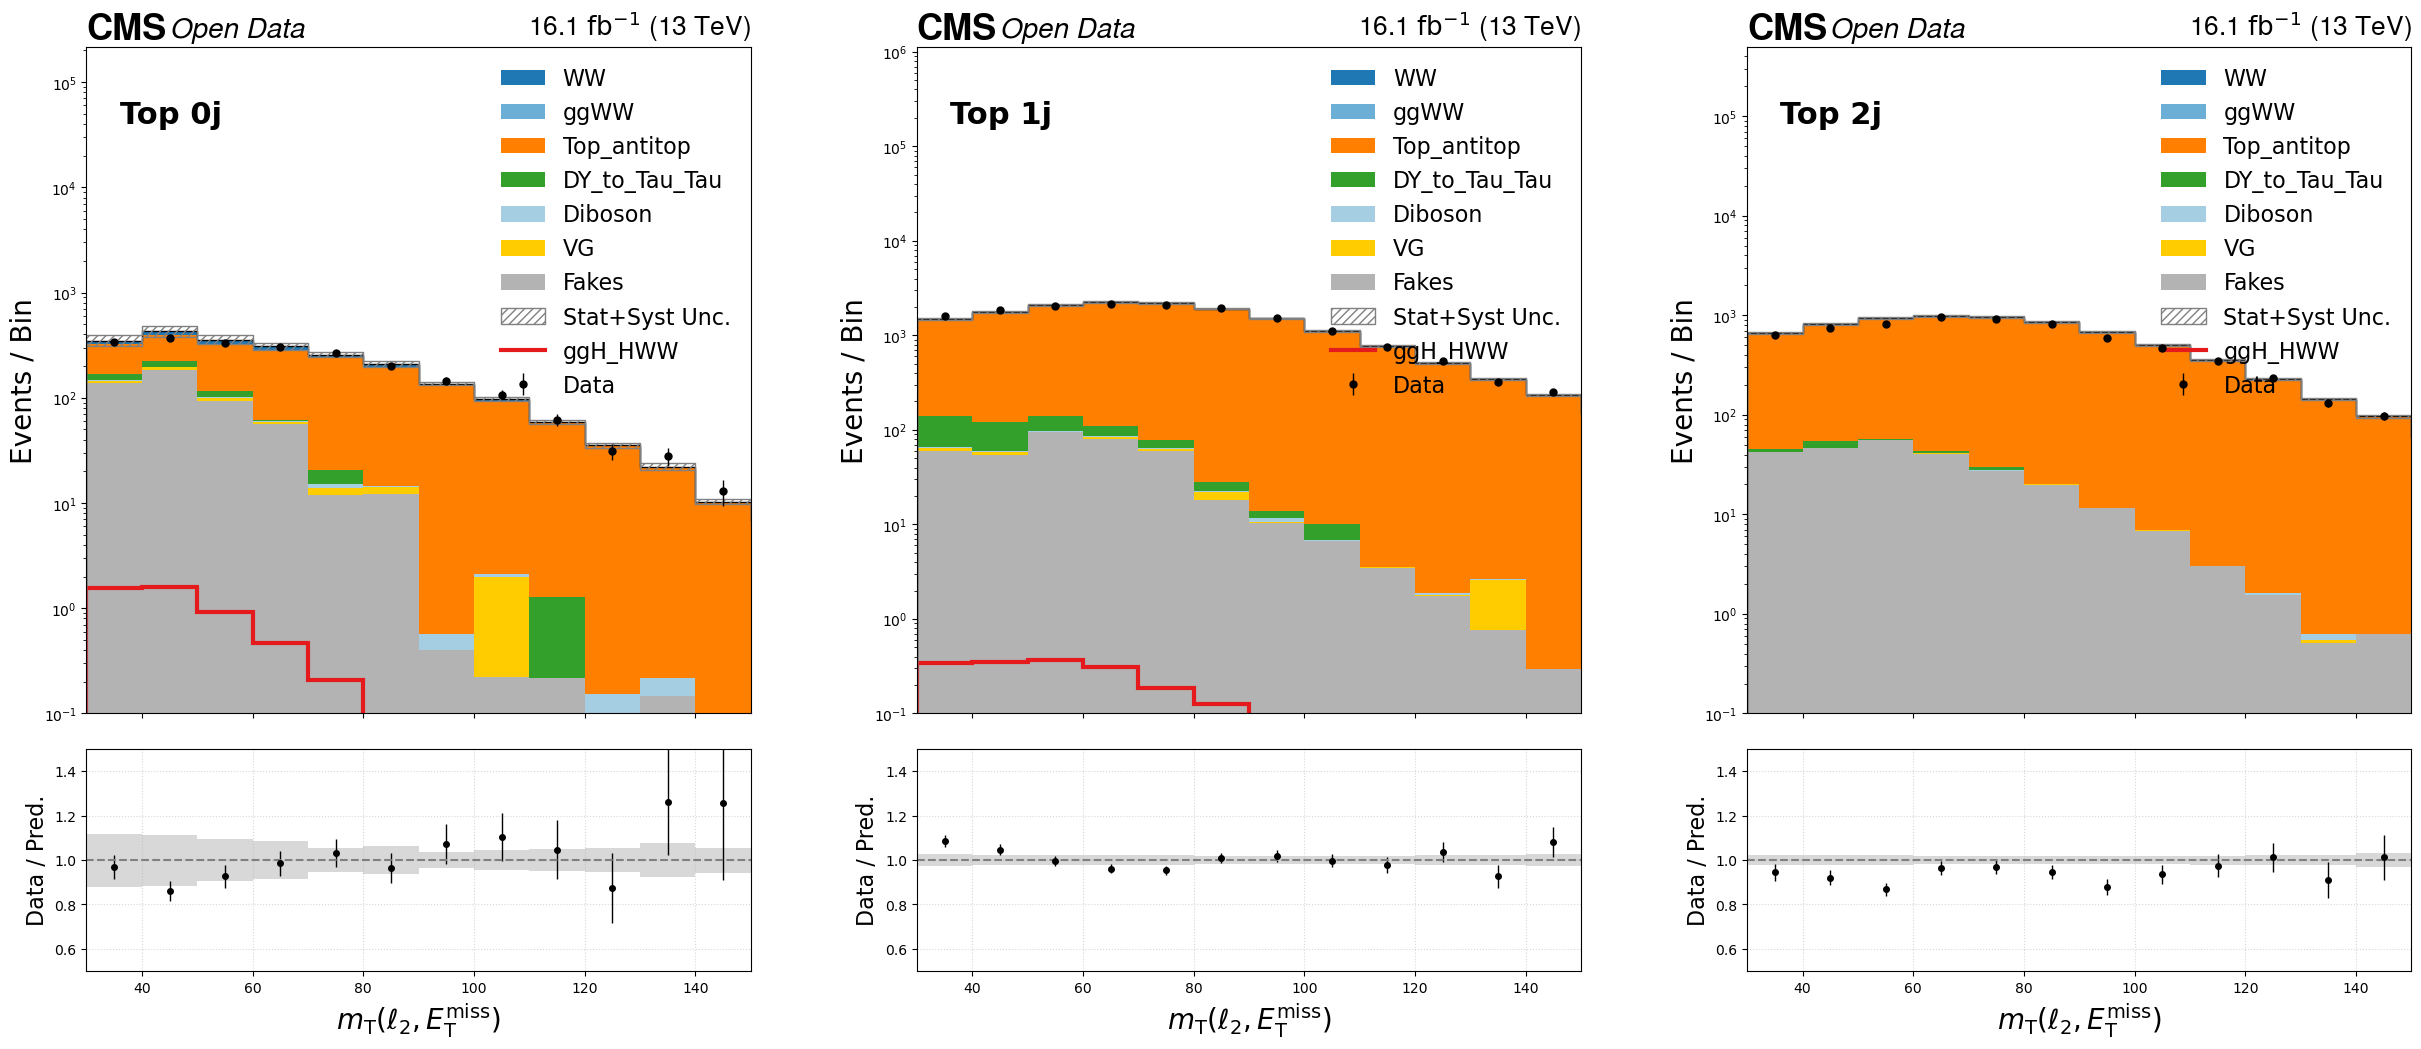

Plotting mt_l2_met in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mt_l2_met.png


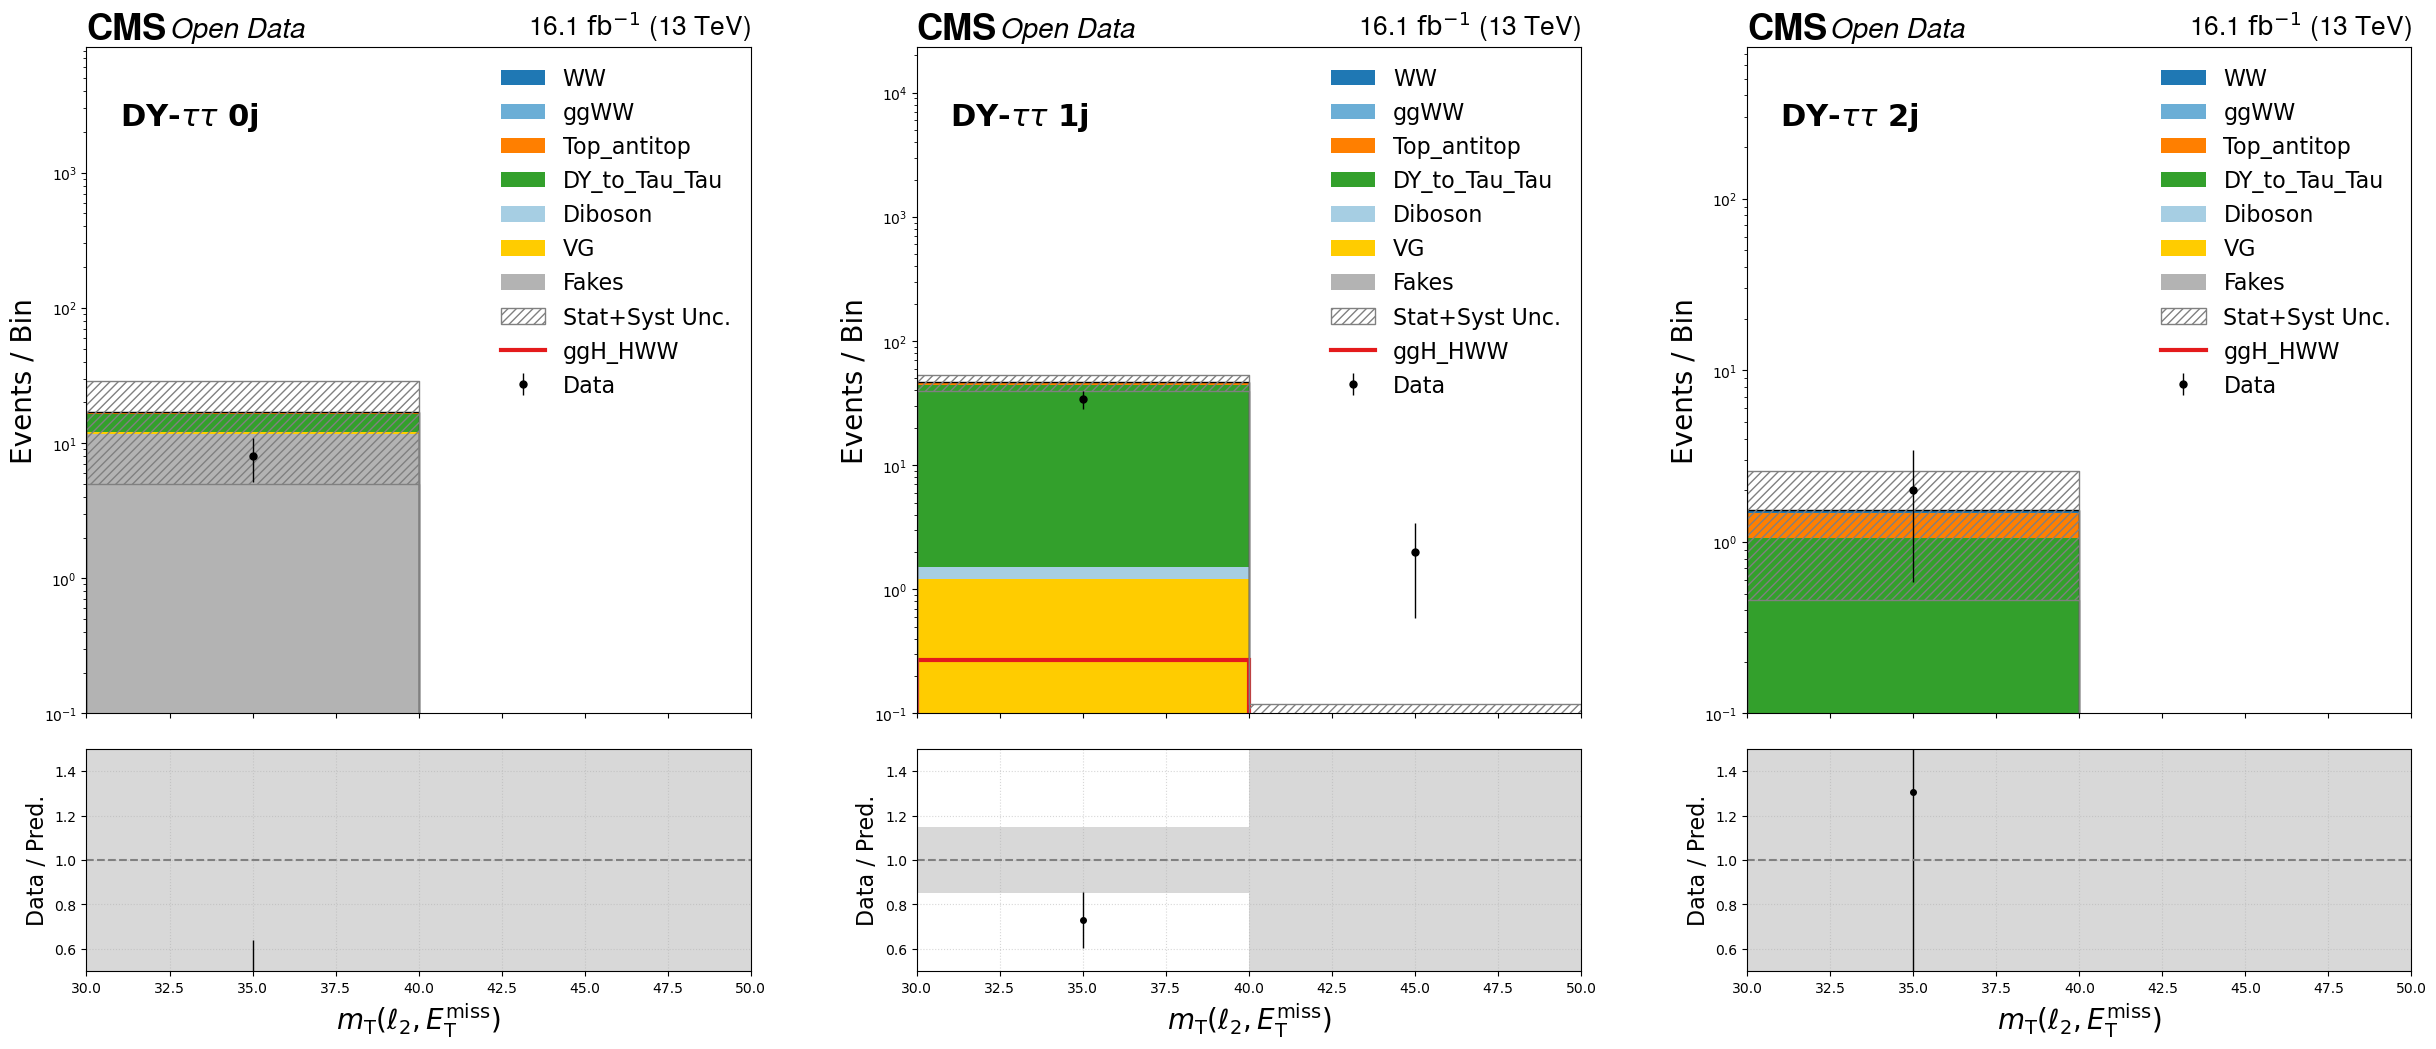

Plotting mjj in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_mjj.png


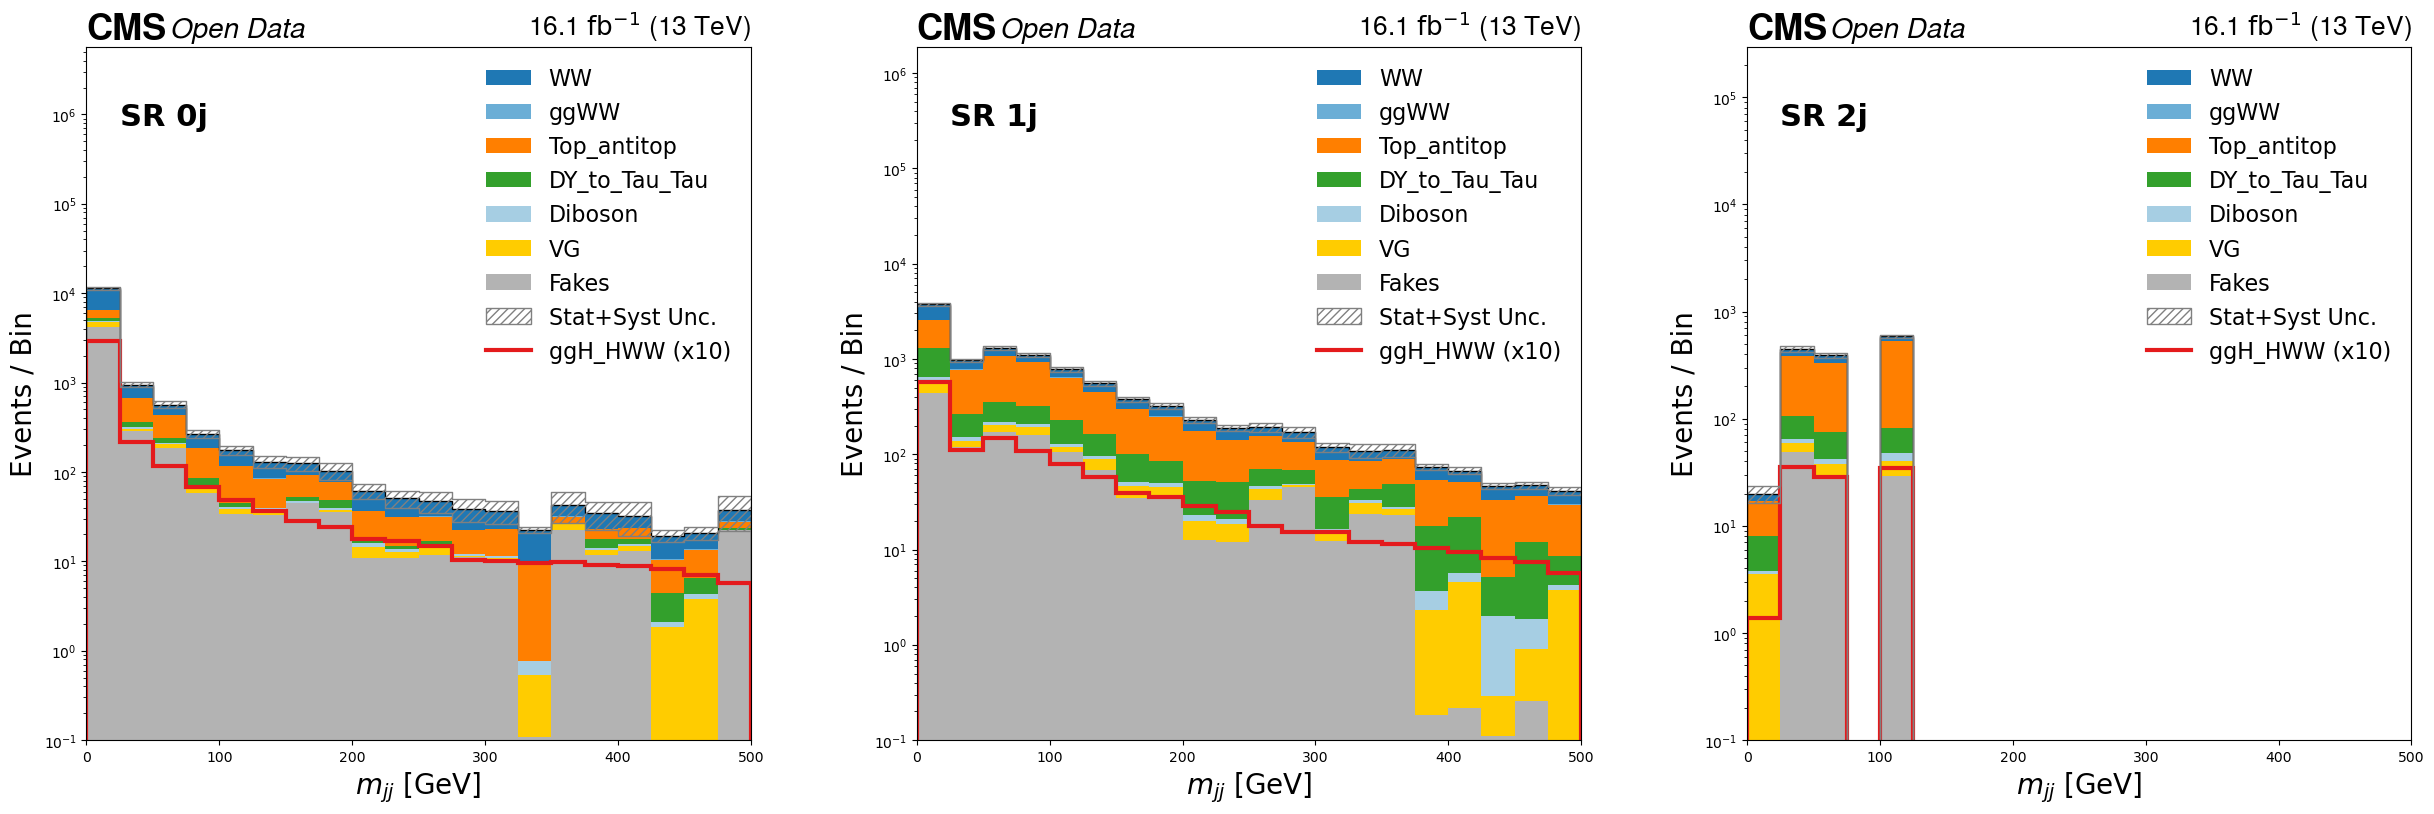

Plotting mjj in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_mjj.png


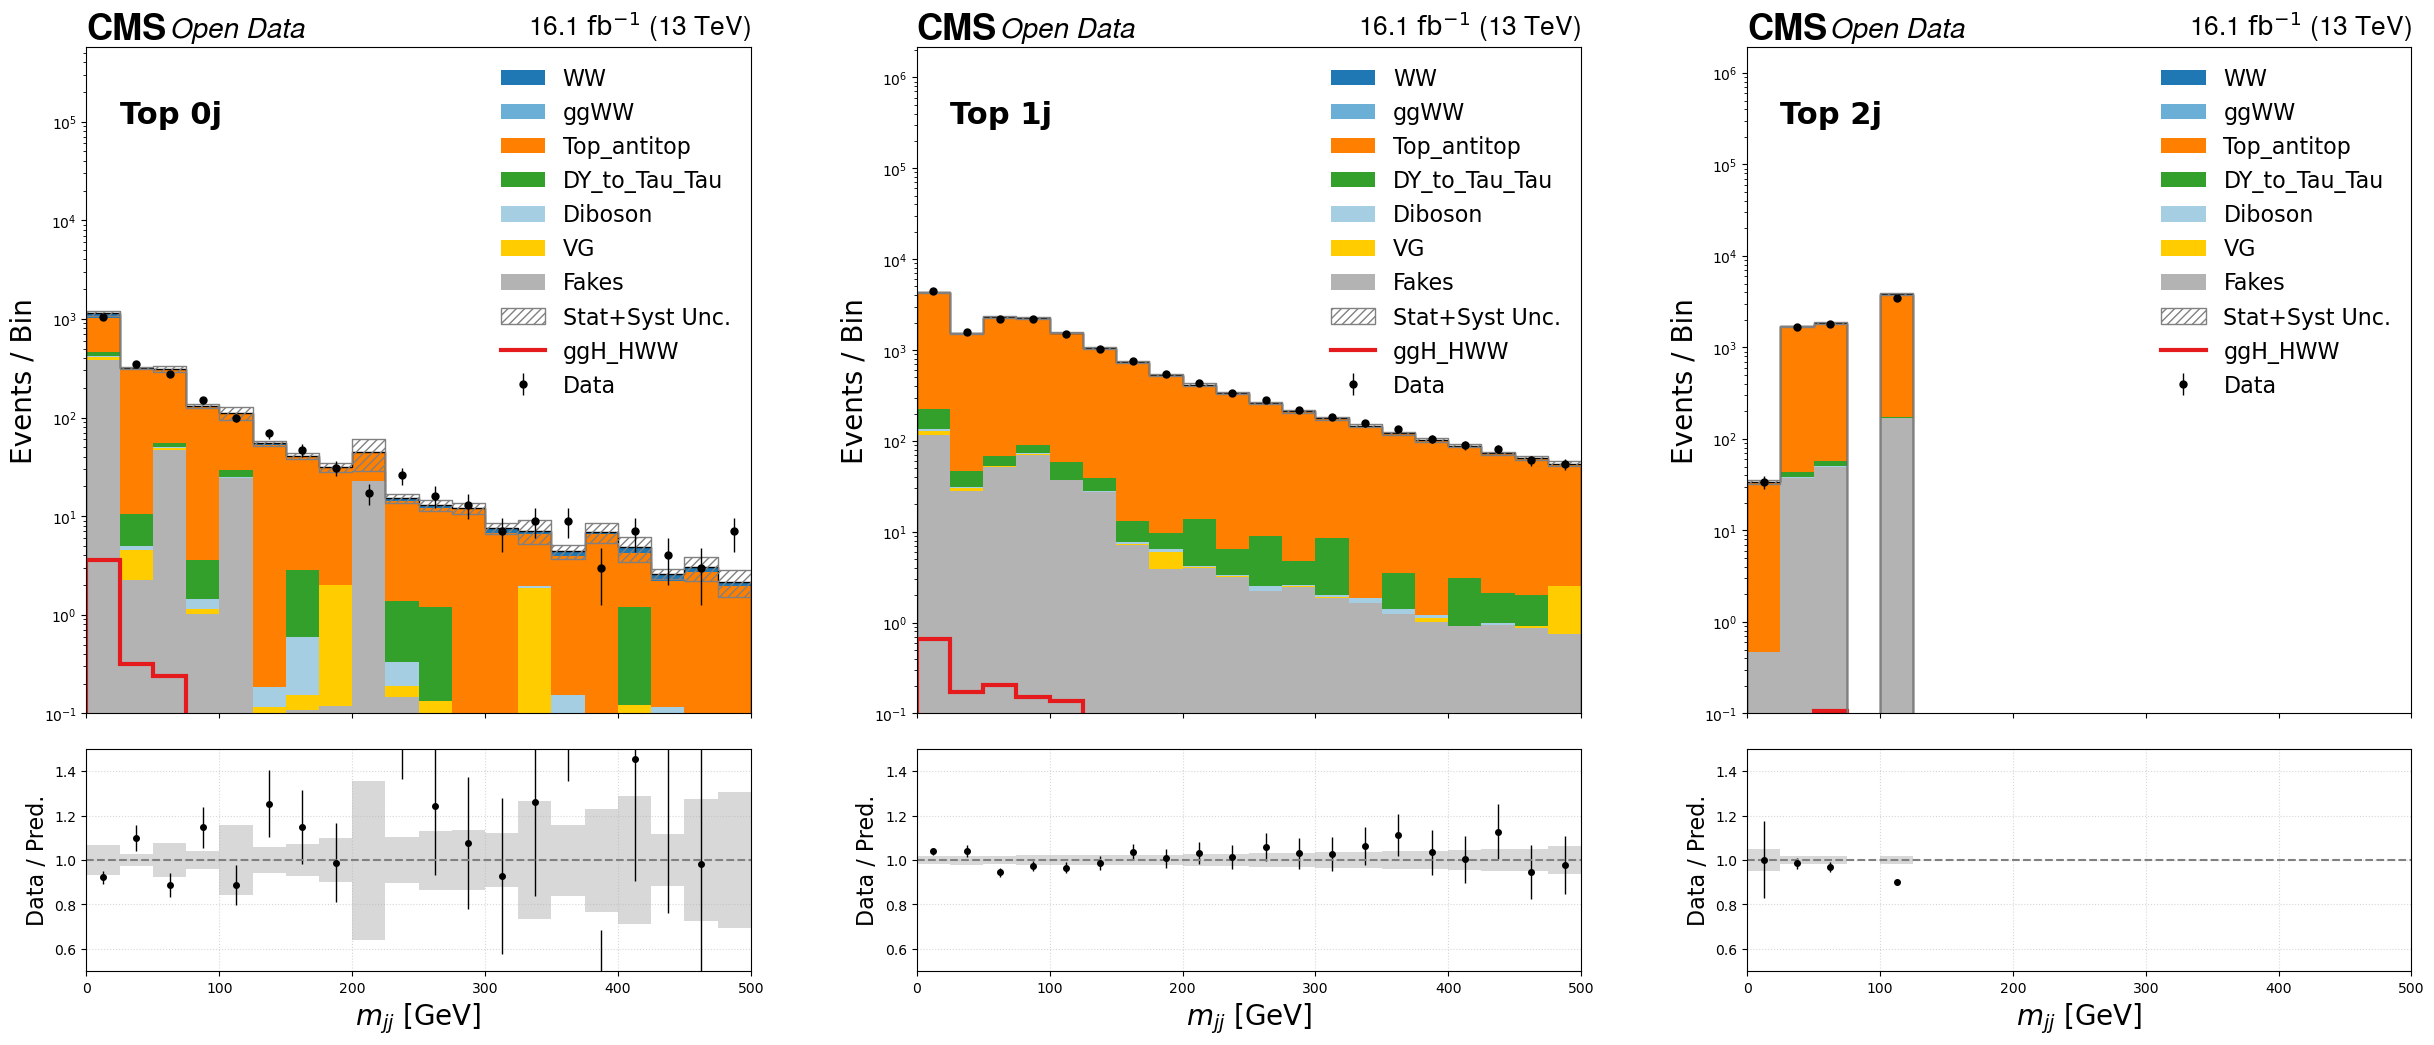

Plotting mjj in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_mjj.png


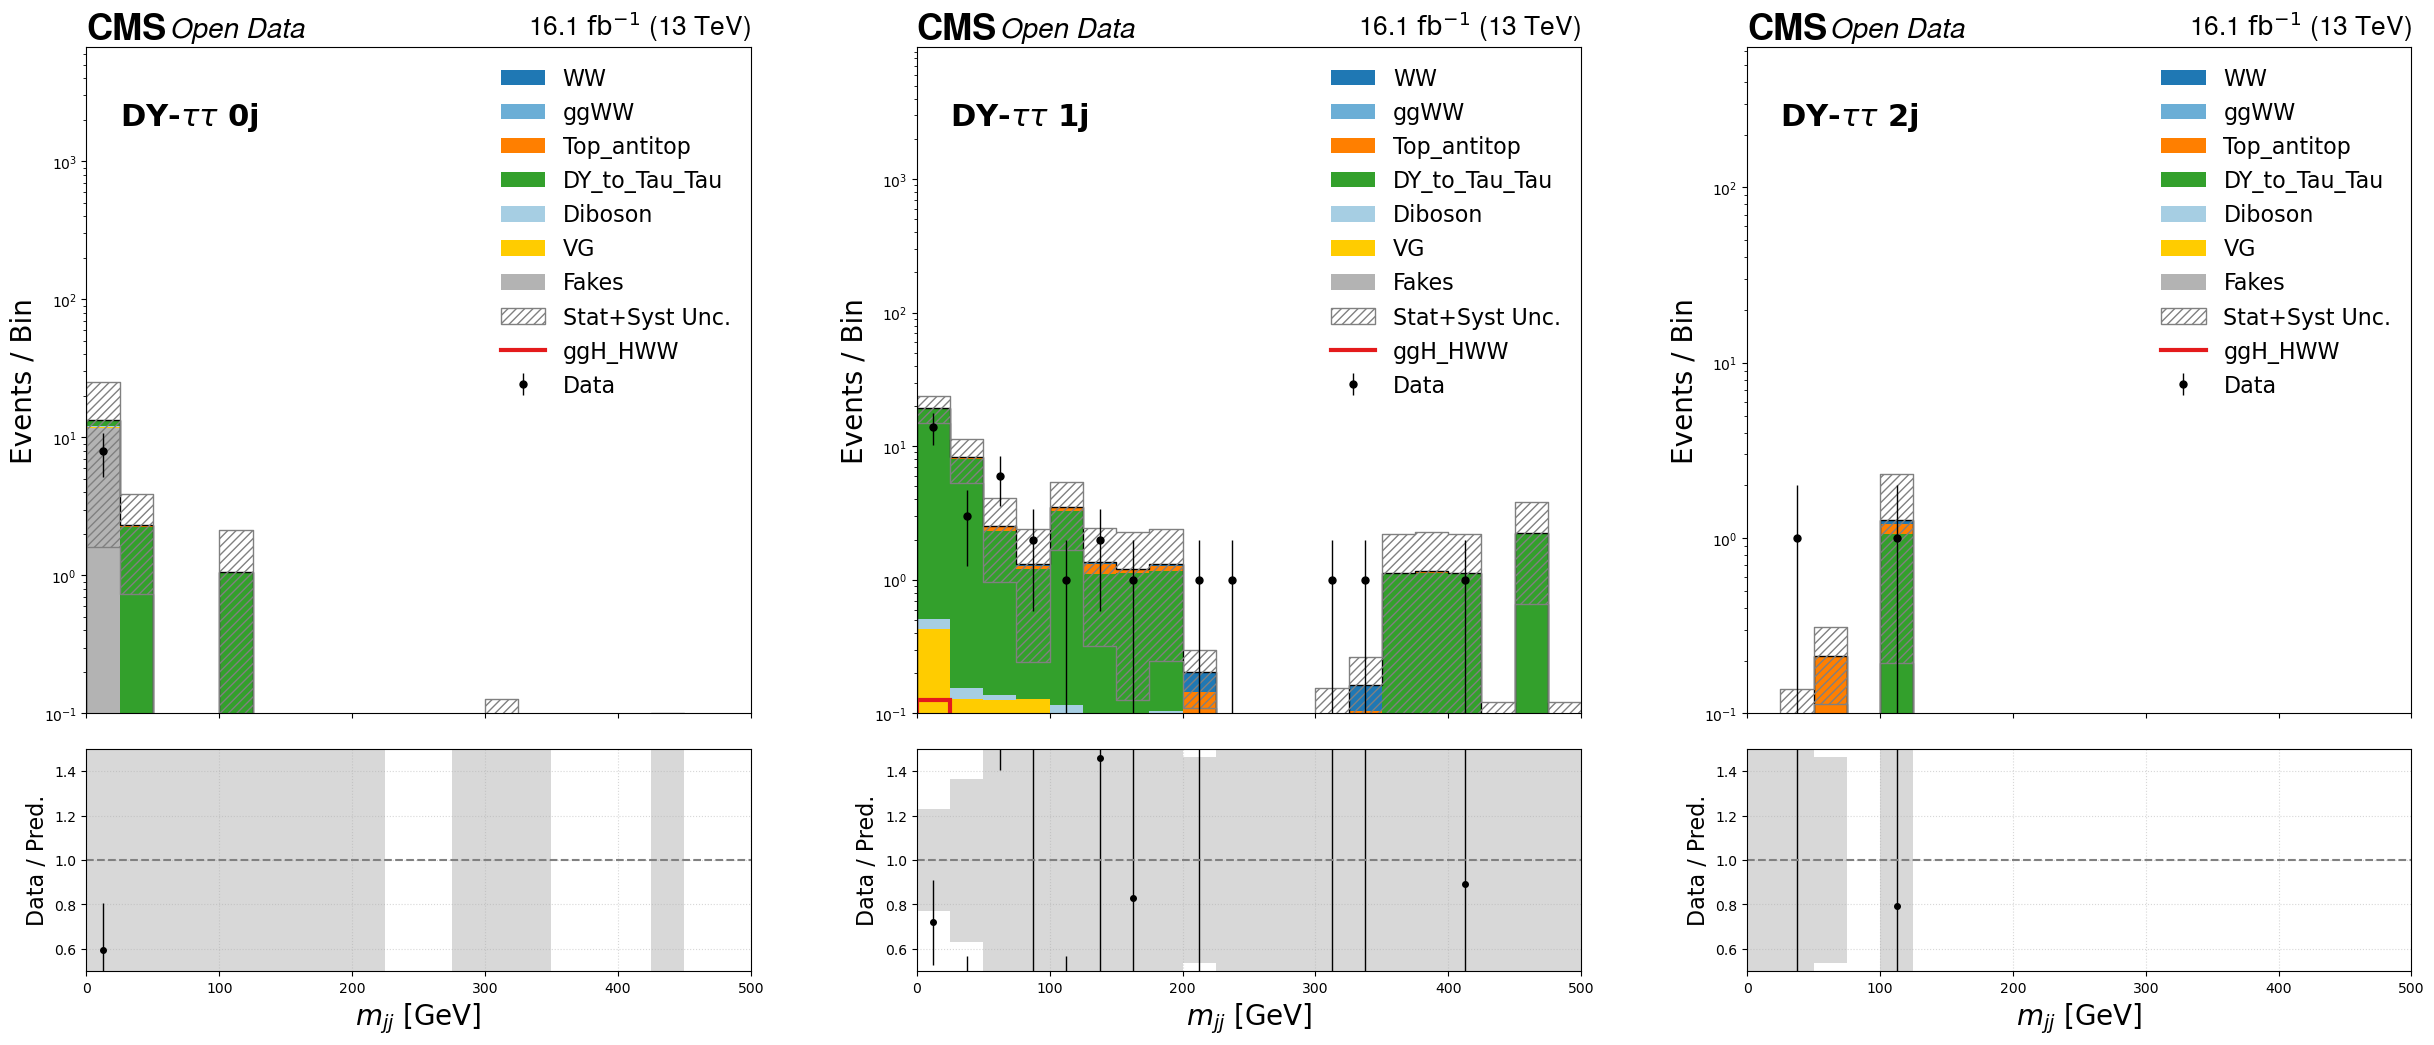

Plotting leading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_leading_pt.png


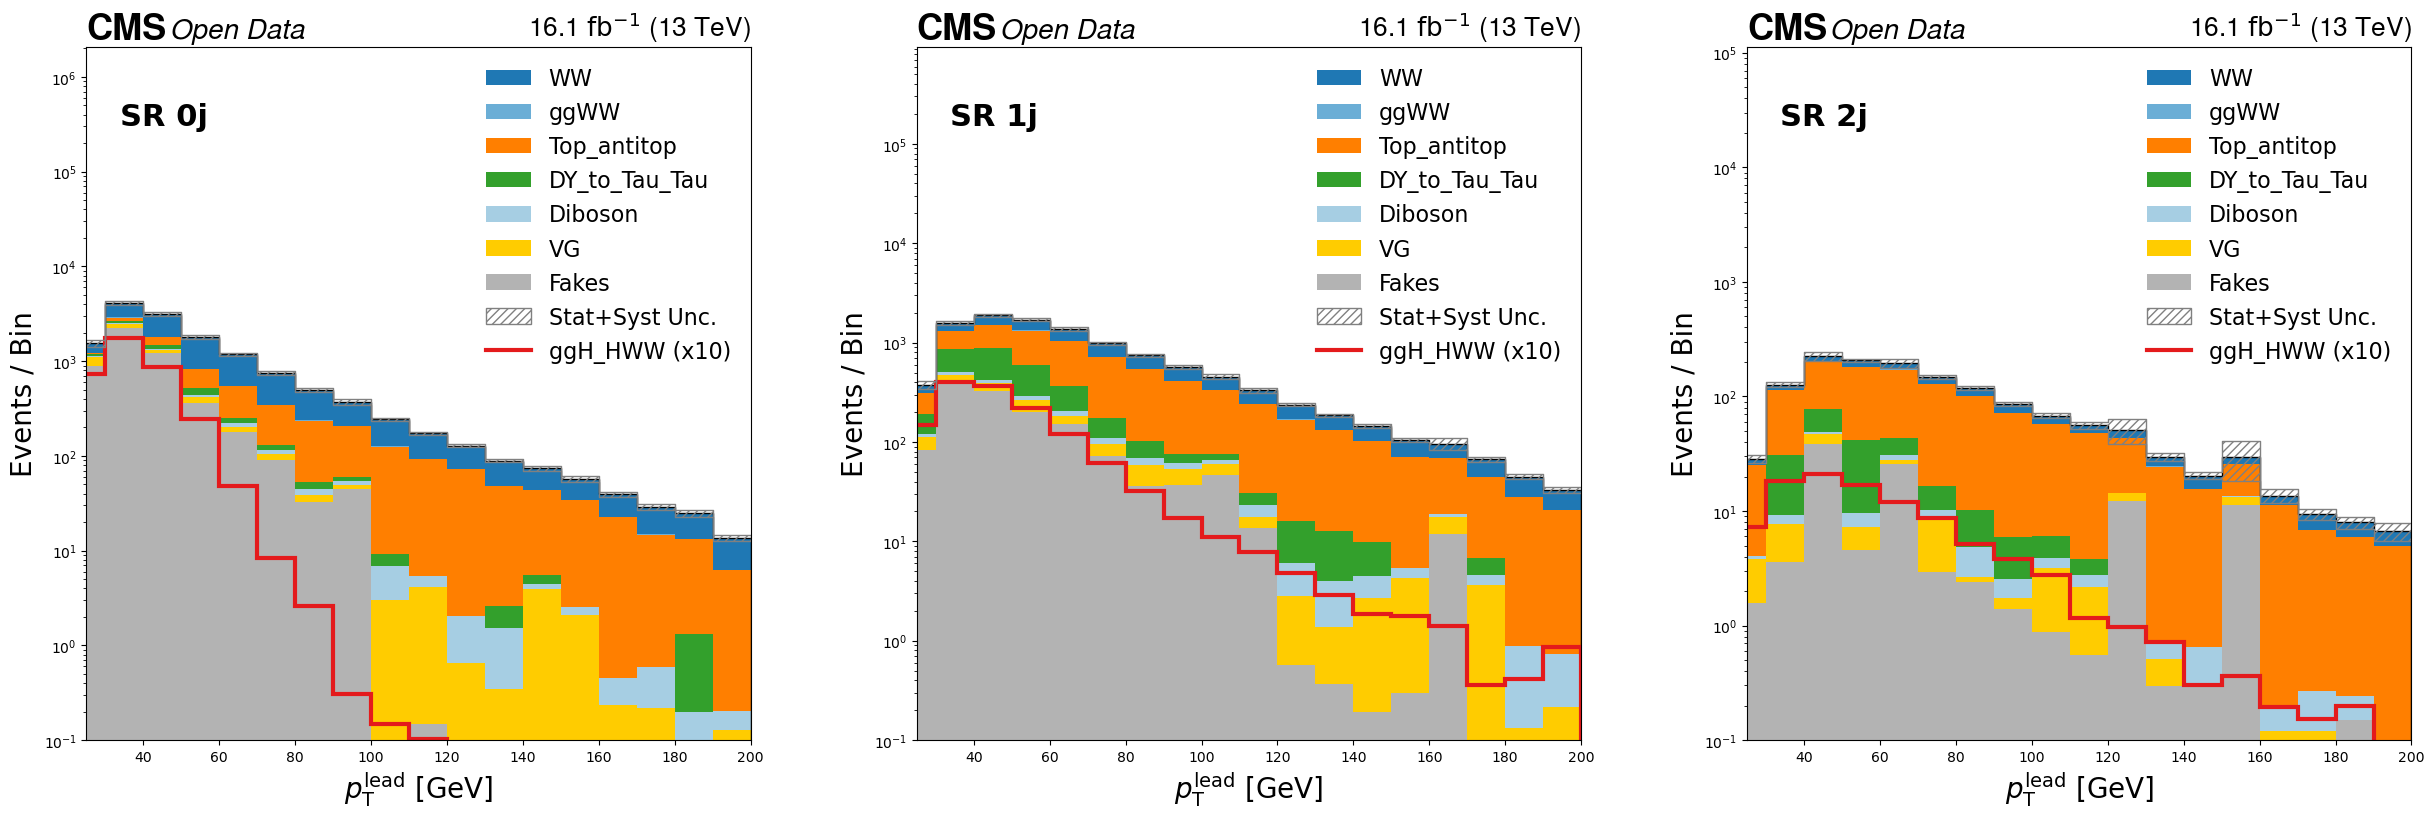

Plotting leading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_leading_pt.png


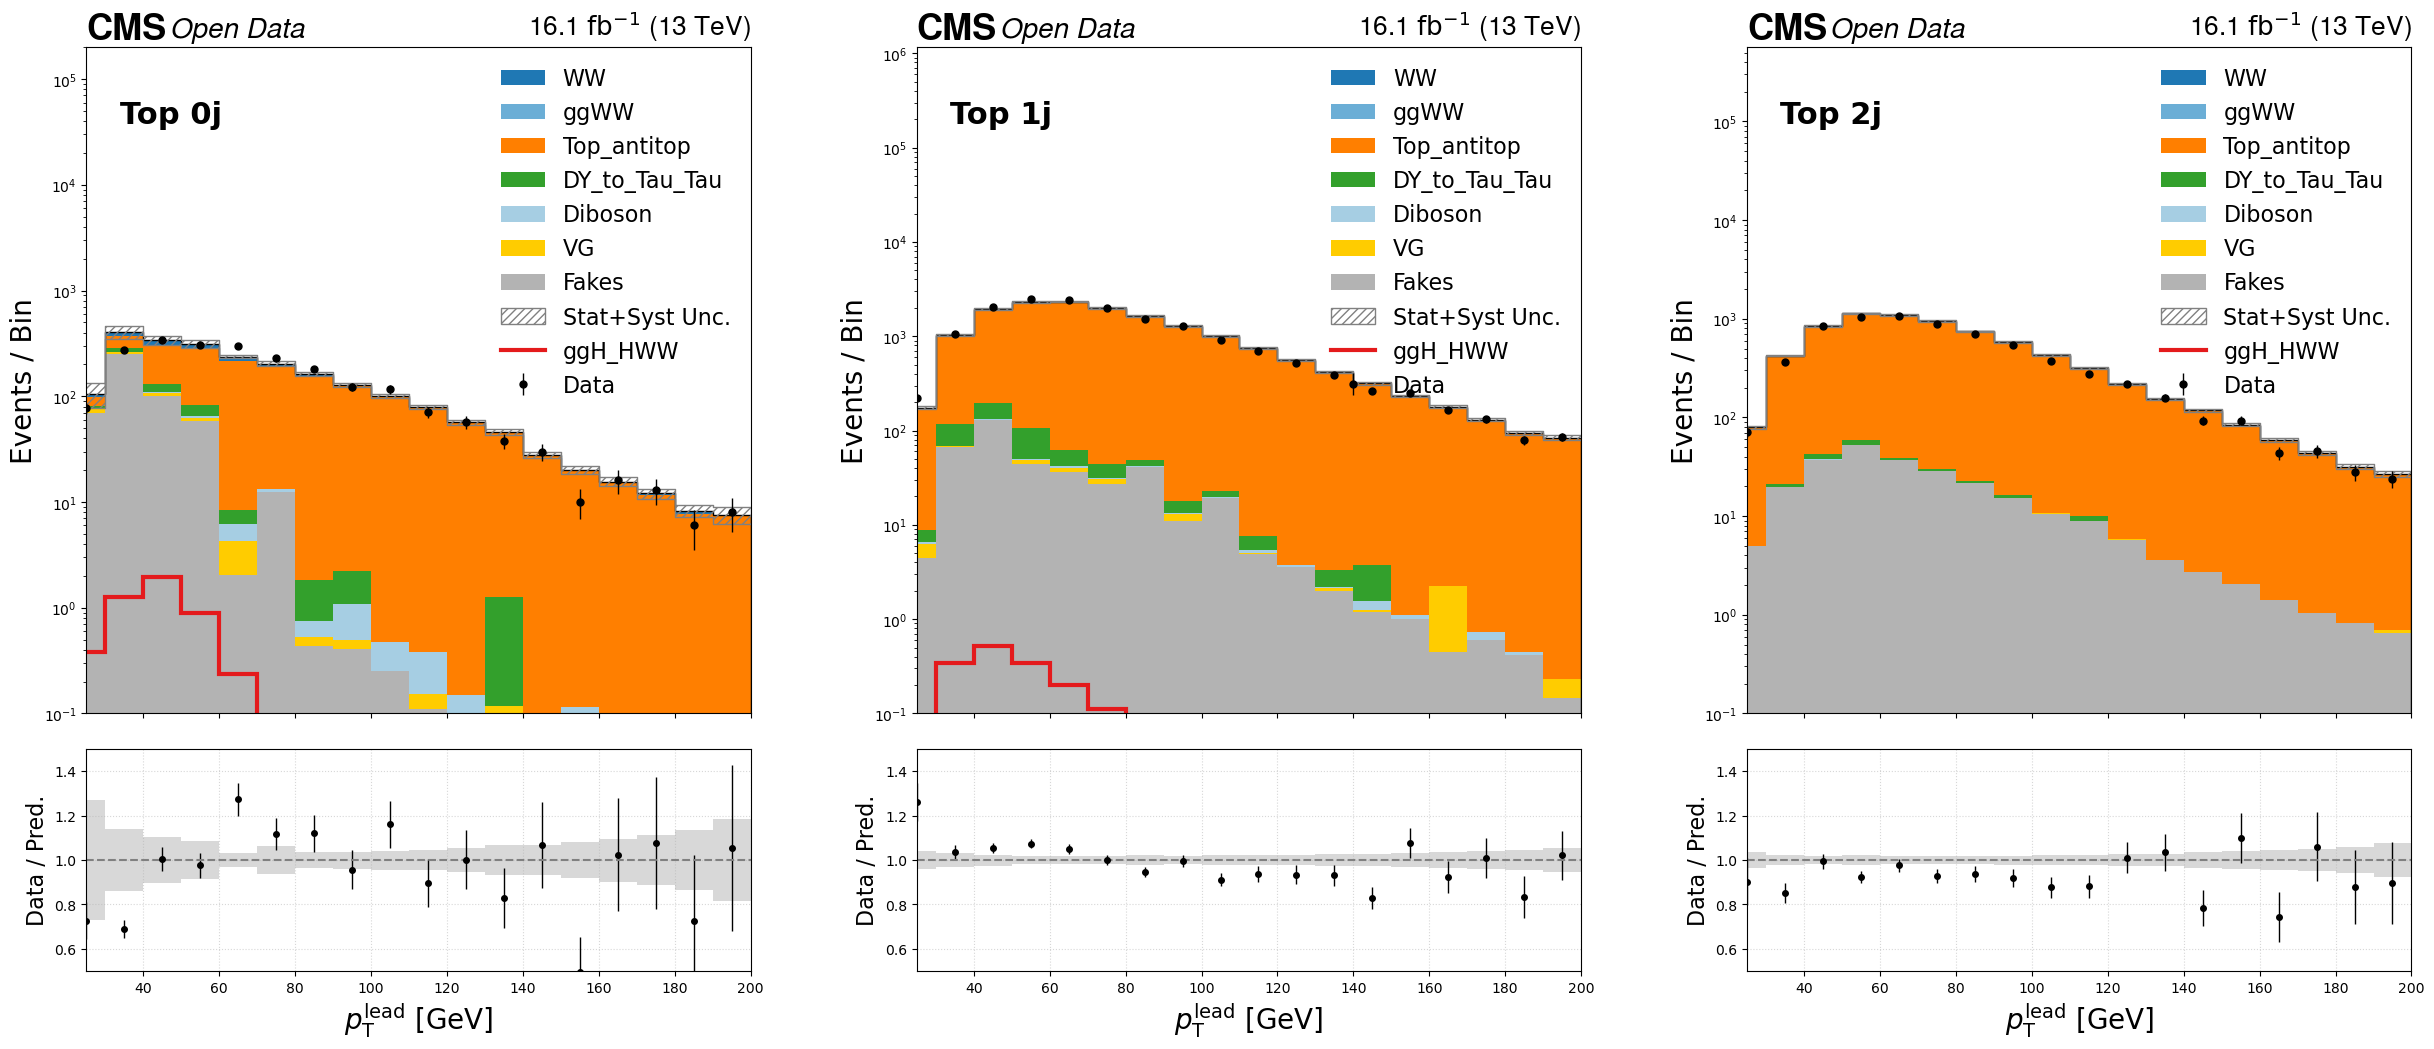

Plotting leading_pt in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_leading_pt.png


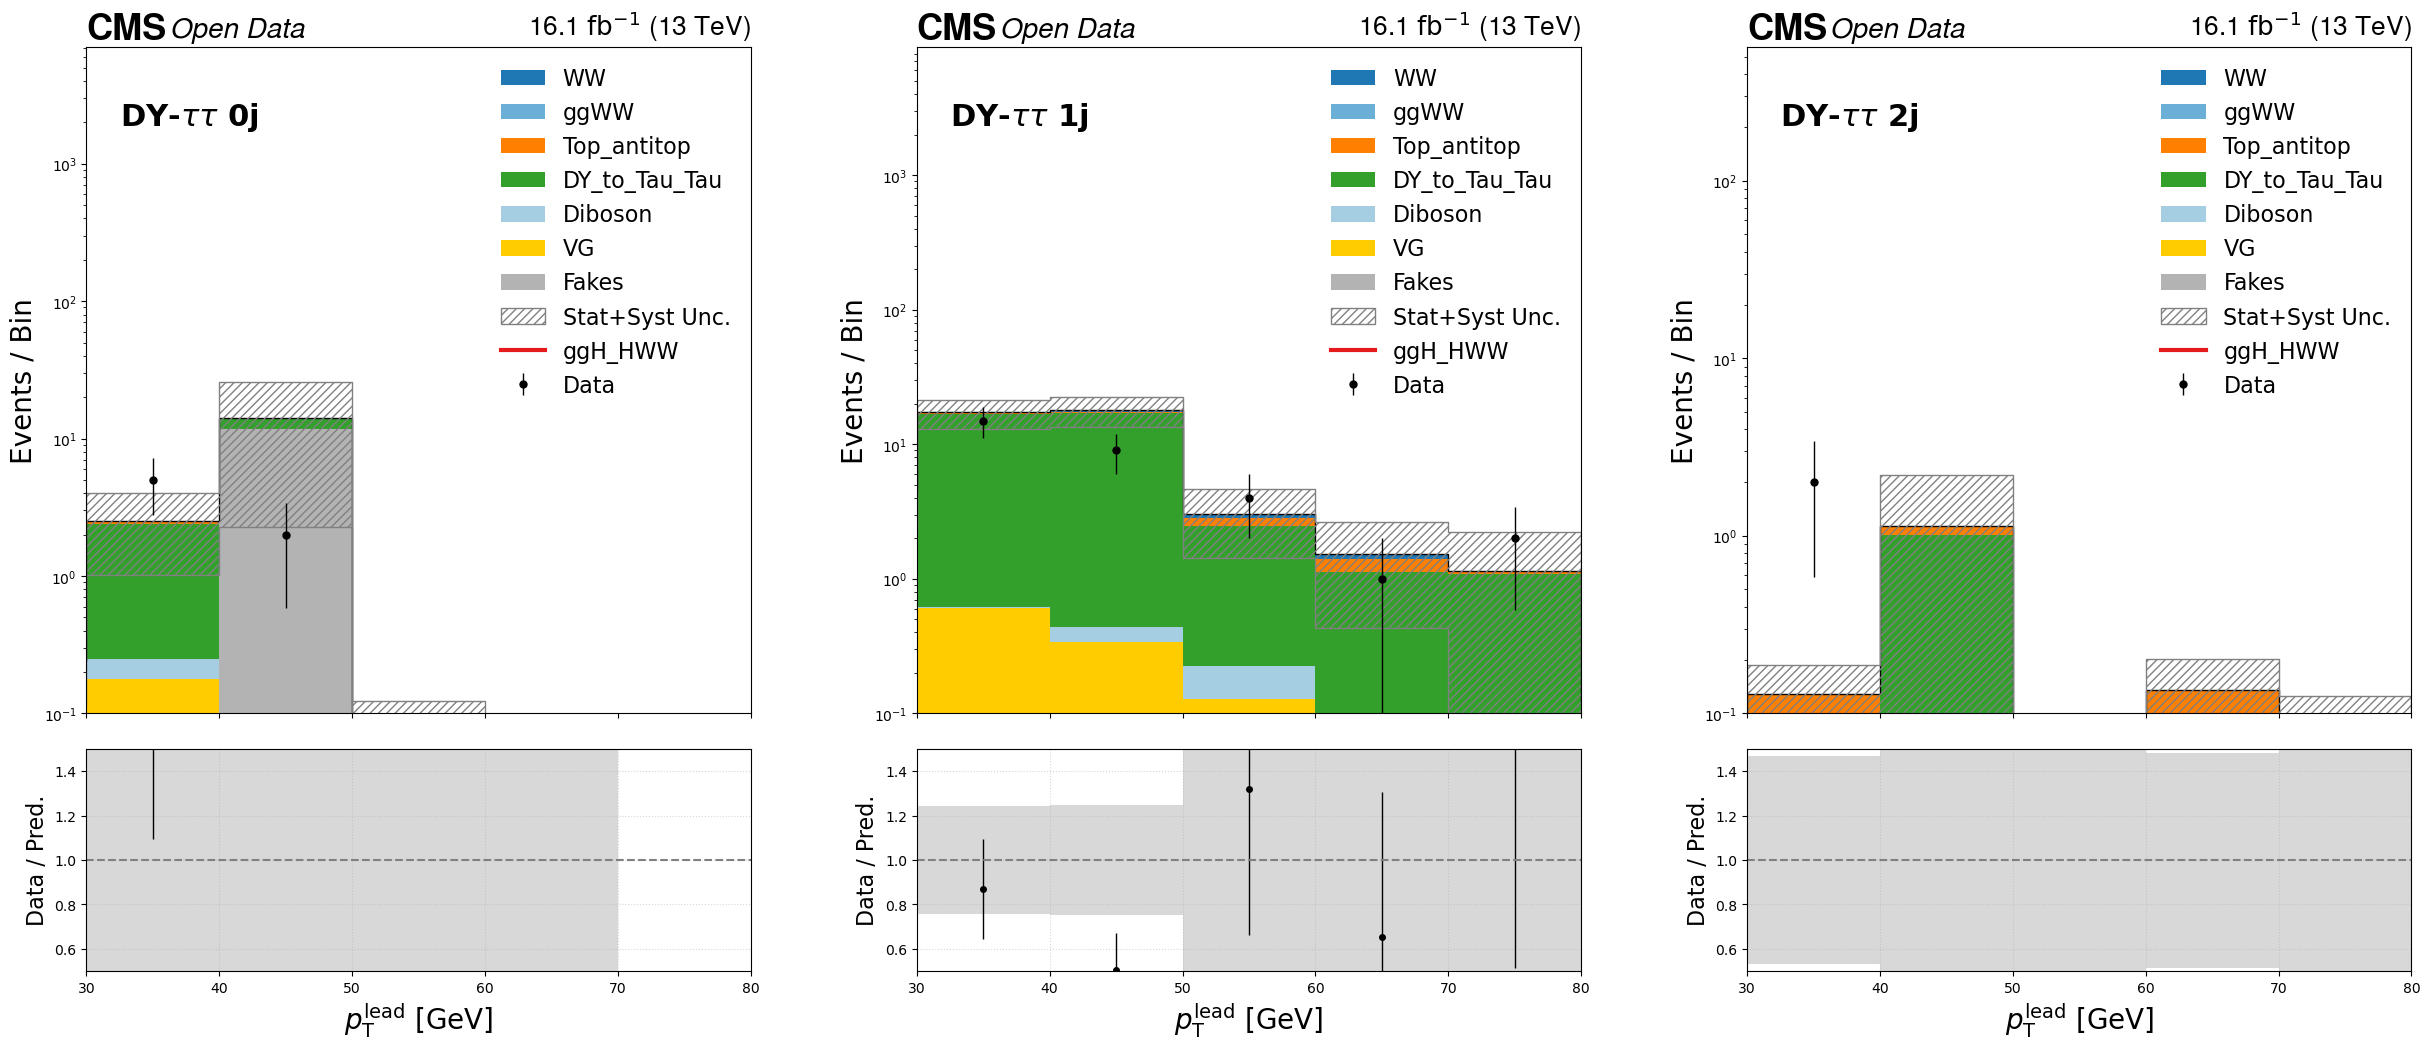

Plotting subleading_pt in Signal_Region...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Signal_Region_subleading_pt.png


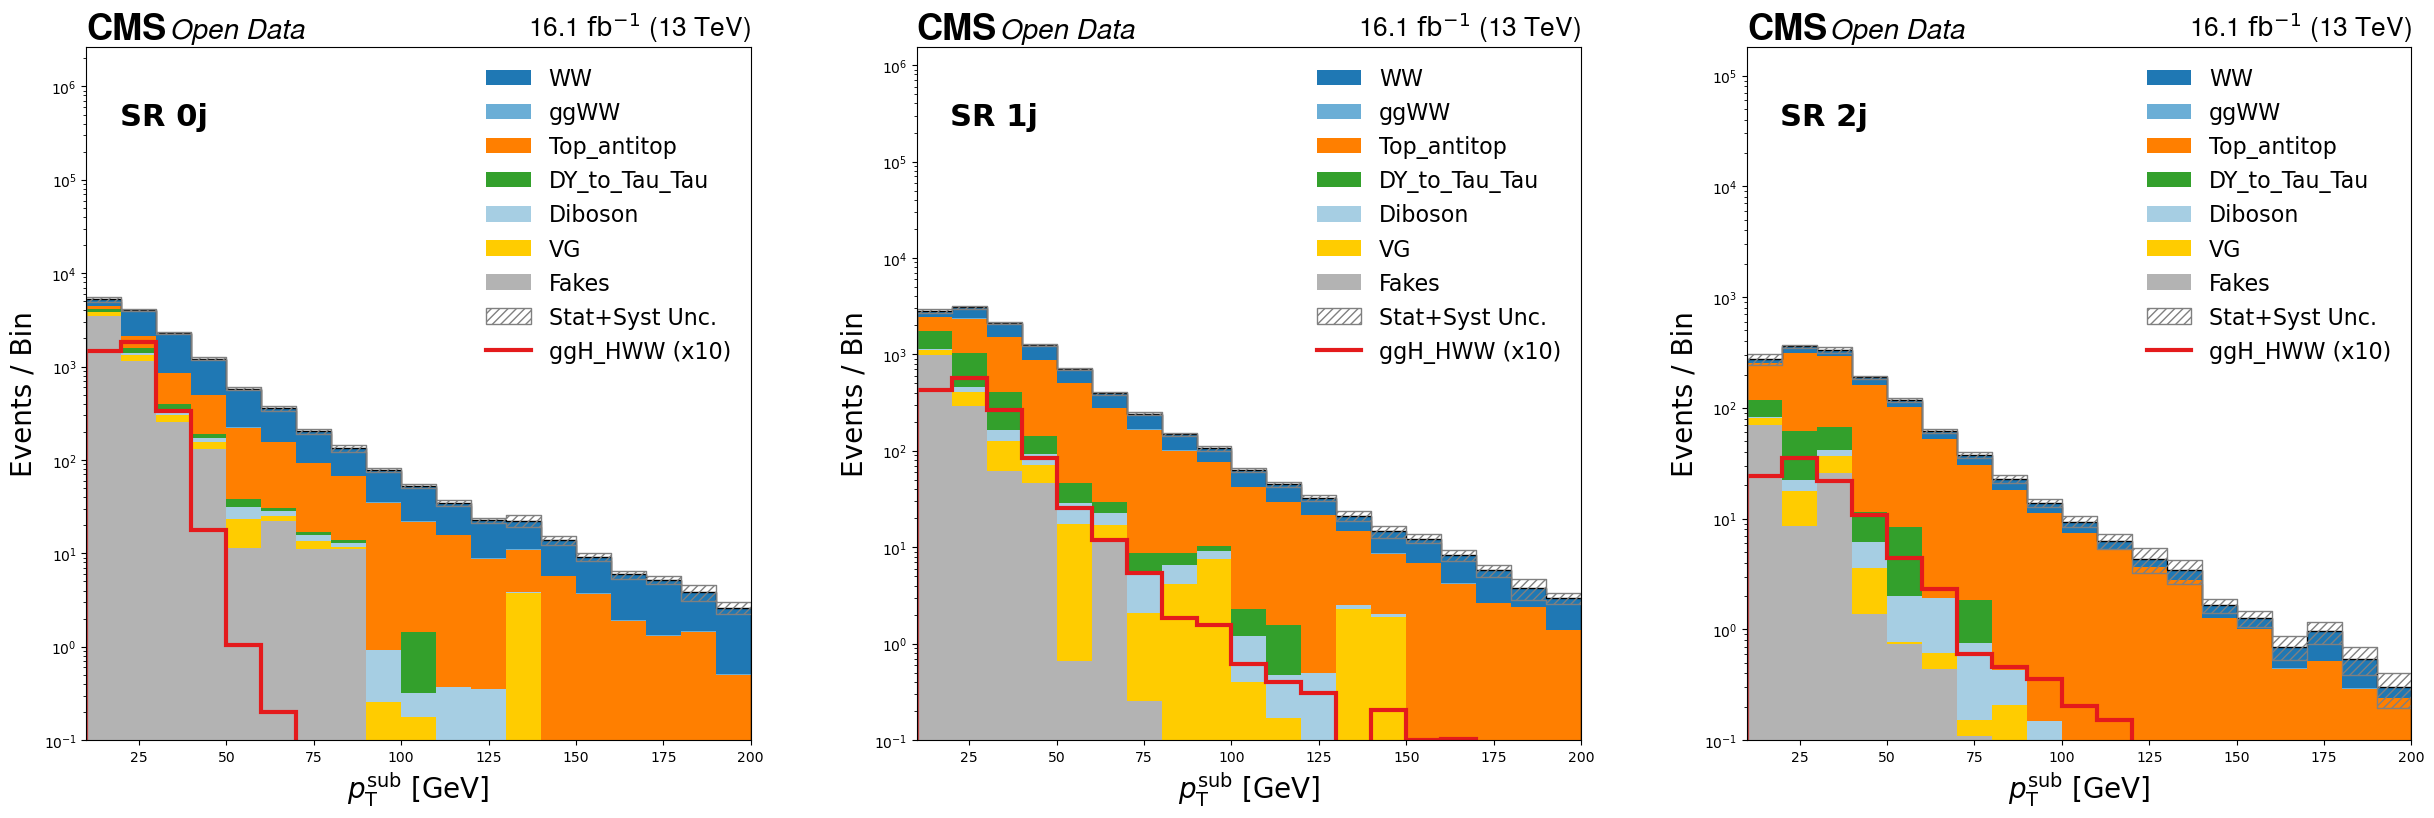

Plotting subleading_pt in Control_Region_Top...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Top_subleading_pt.png


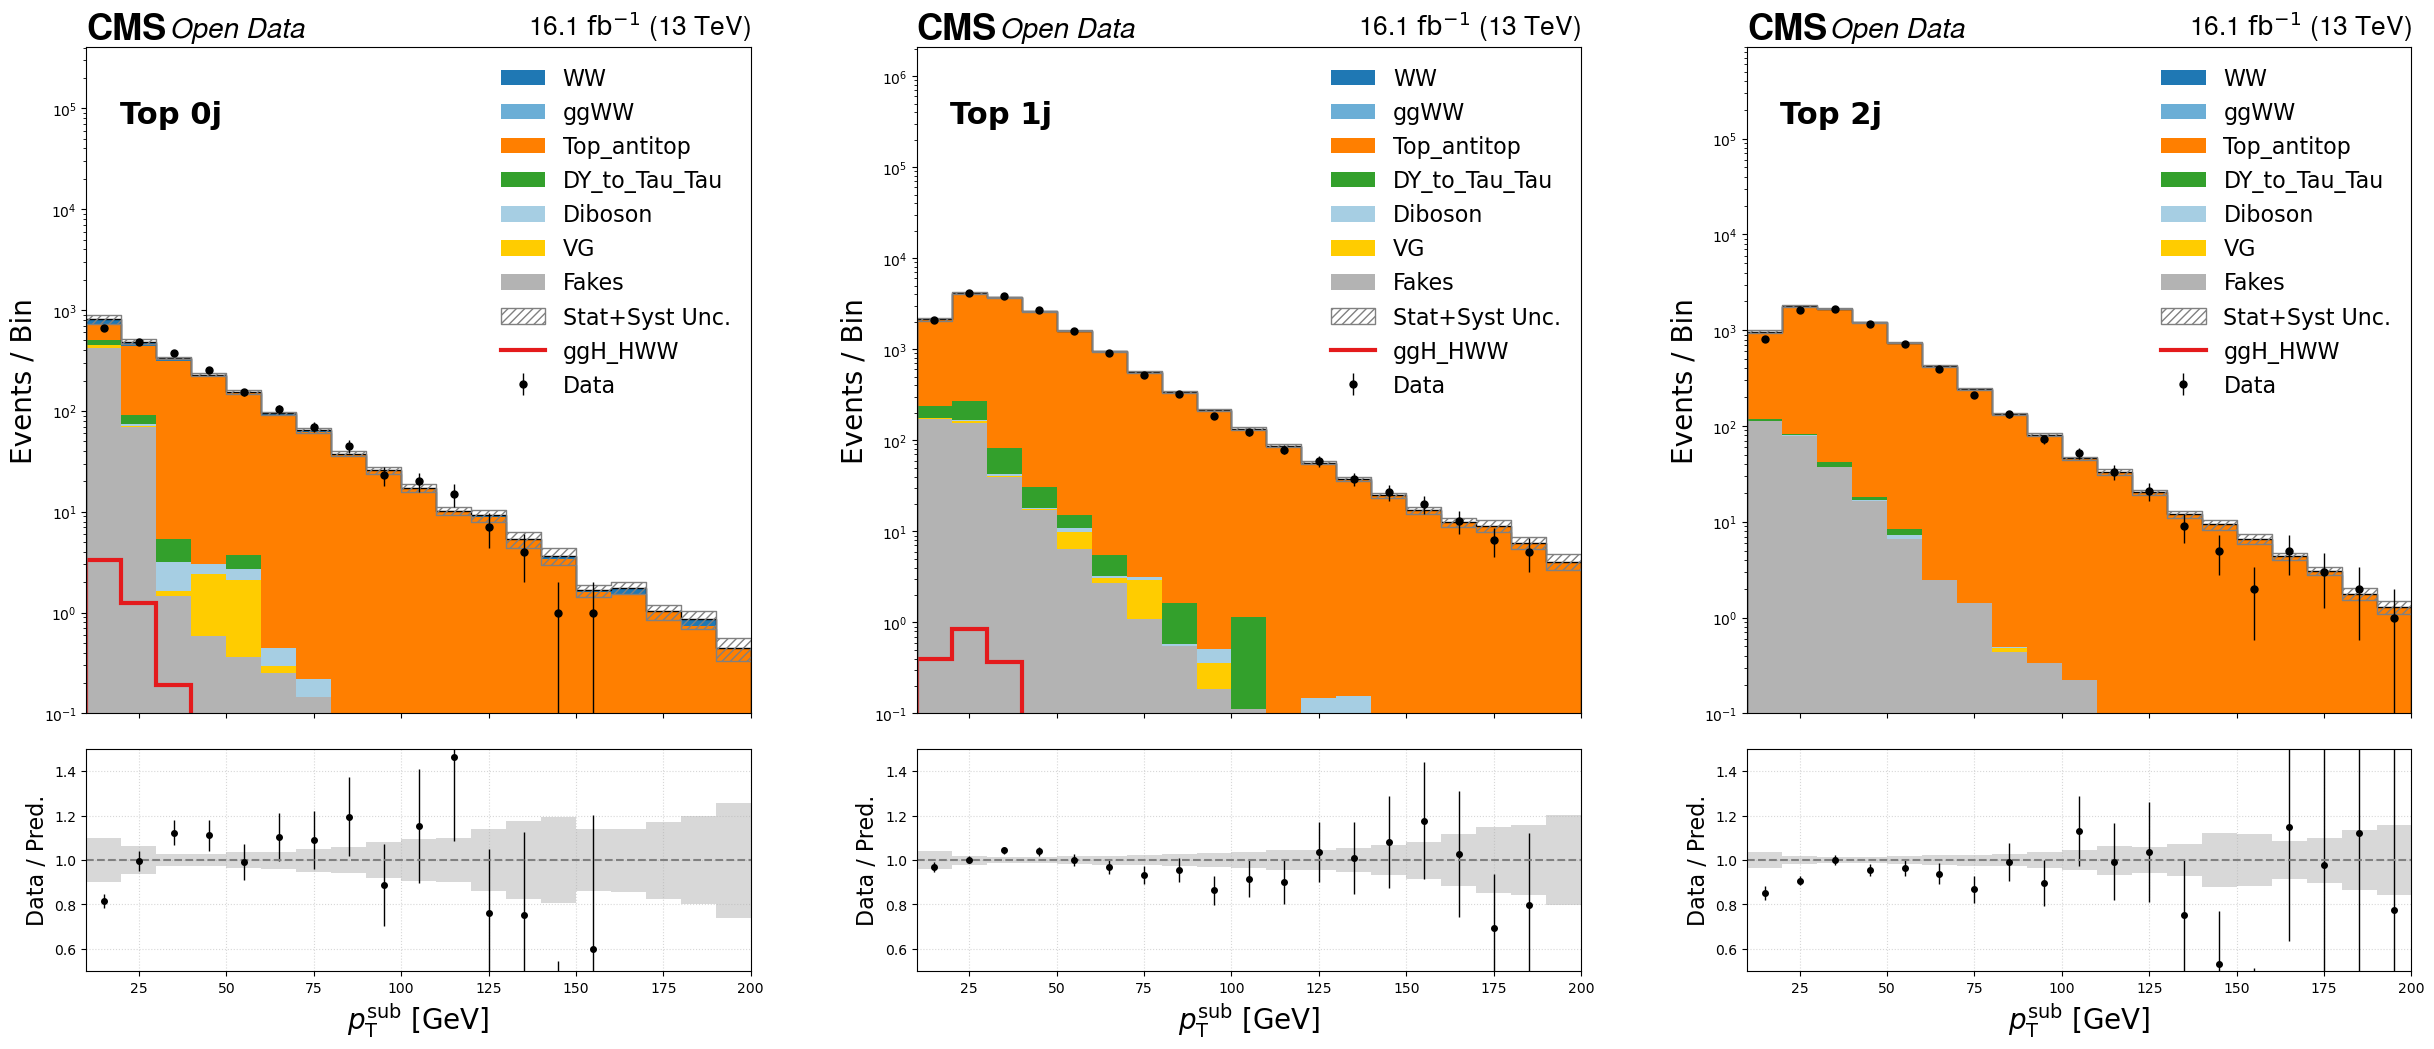

Plotting subleading_pt in Control_Region_Tau...
Saved: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked/CMS_Control_Region_Tau_subleading_pt.png


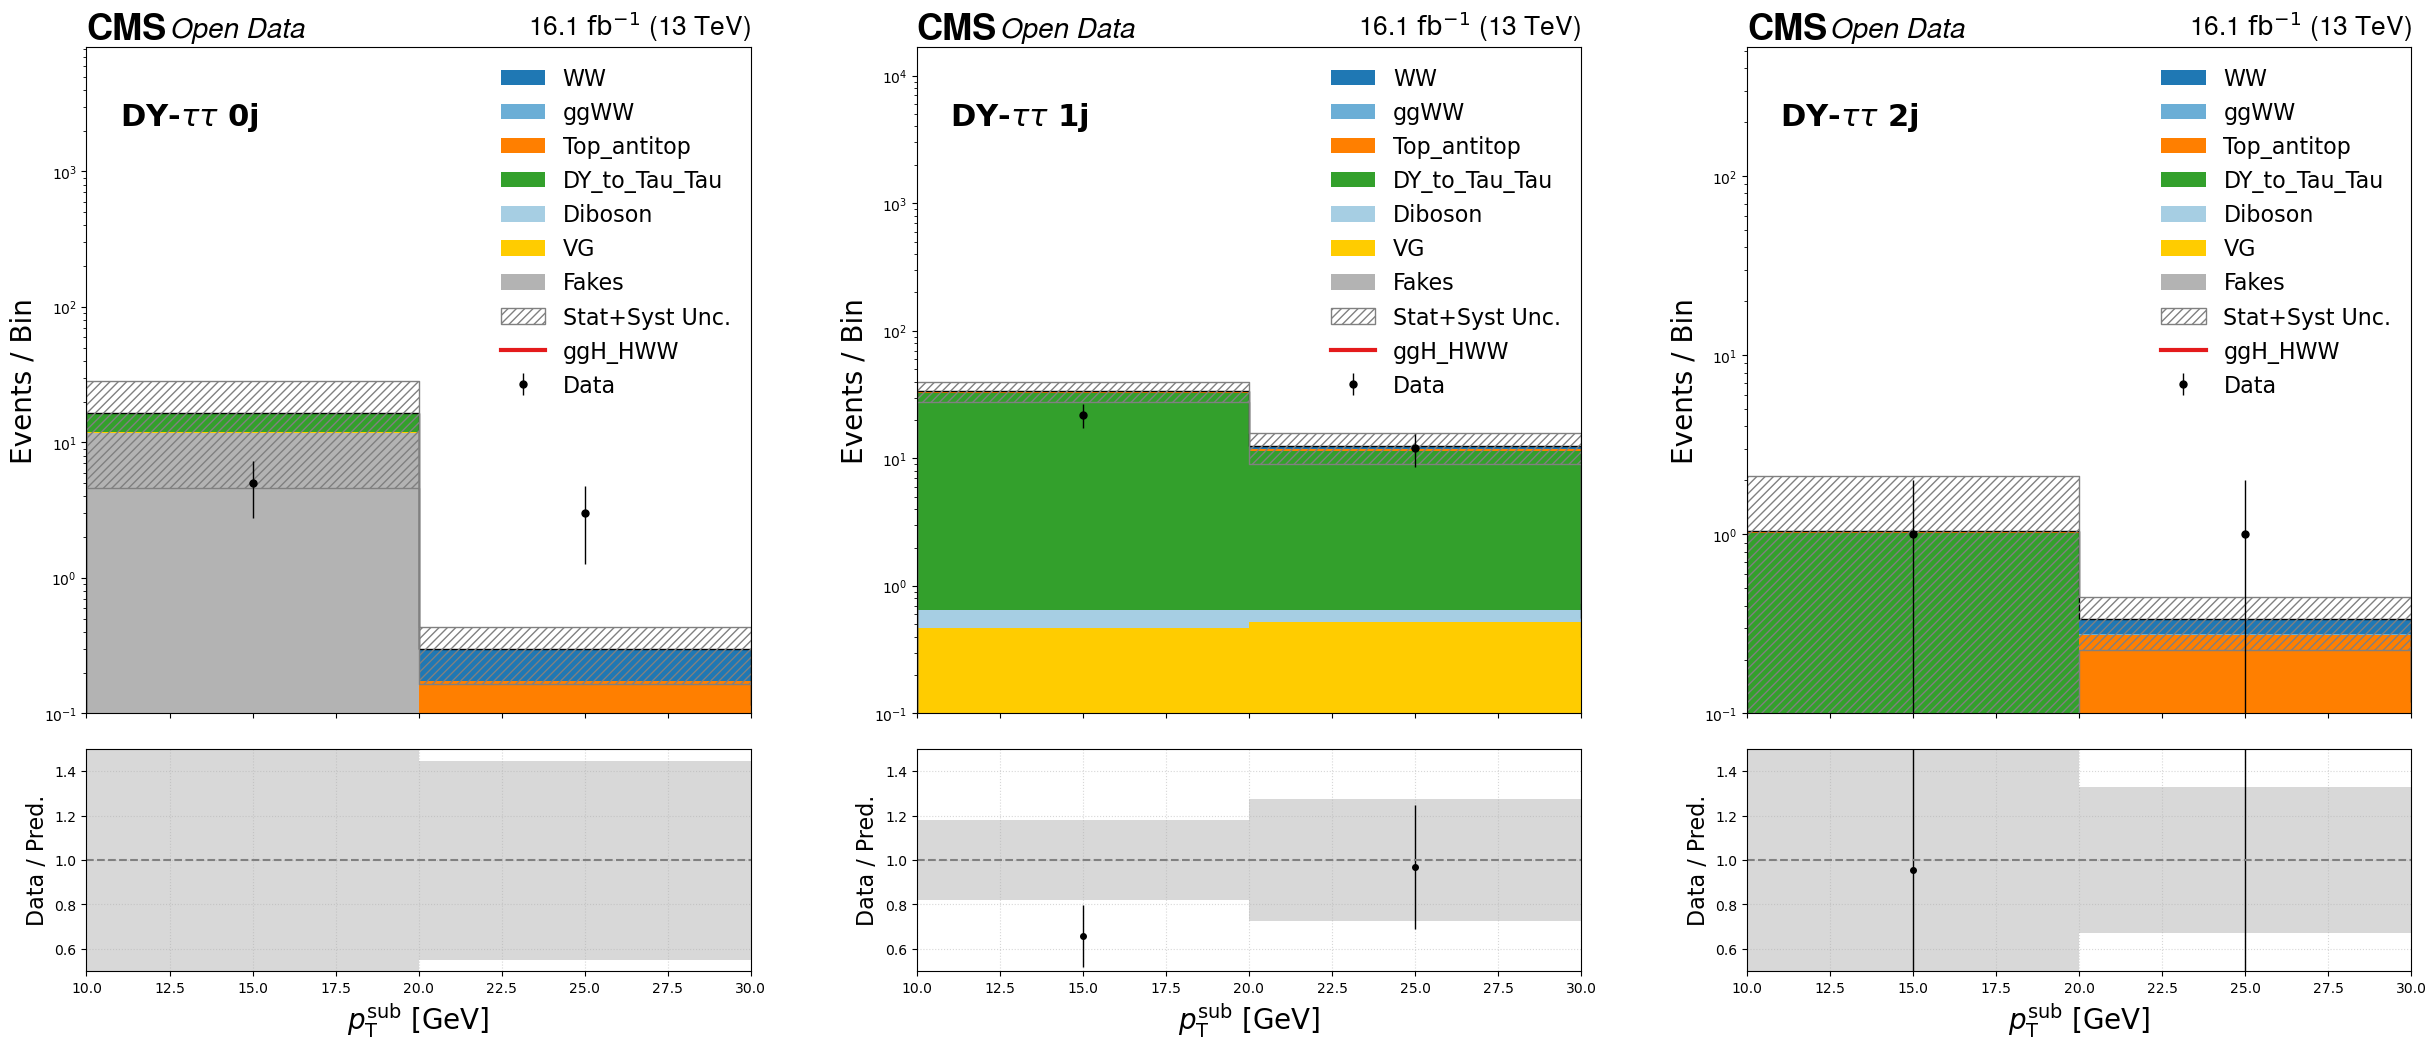


All plots saved to: /home/cms-jovyan/H-to-WW-NanoAOD-analysis/Outputs/Plots/Stacked


In [10]:
print("\n" + "="*70)
print("GENERATING STACKED PLOTS...")
print("="*70)

output_dir = PLOTS_DIR / "Stacked"
output_dir.mkdir(parents=True, exist_ok=True)

for variable in VAR_LABELS.keys():
    try:
        create_stacked_plots(
            variable=variable, 
            hist_data_all=hist_data_final, 
            output_dir=output_dir
        )
    except Exception as e:
        print(f"FAILED to plot {variable}: {e}")
        import traceback
        traceback.print_exc()

print(f"\nAll plots saved to: {output_dir}")

# Closing the Dask Client

Finally, it's always a good practice to cleanly shut down the Dask client we initialized at the start of the notebook and delete the variables associated with it.

**But why do we need to do this?**

Well, Dask workers reserves a lot of CPU and memory. If we don't explicitly close the client, those resources stay locked up, which can slow down your machine or leave "zombie" processes eating up your RAM in the background. Plus, failing to close the client can leave network ports blocked, meaning you might run into annoying port conflict errors the next time you try to run the notebook. 

In [12]:
client.close()

In [13]:
del client